In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection # For multi-coloured lines by time
from matplotlib.colors import ListedColormap, BoundaryNorm # For multi-coloured lines by time
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
from matplotlib.transforms import Affine2D
import glob
import scipy.stats
from scipy.stats import *
from scipy.signal import savgol_filter, find_peaks
import astropy.stats
from scipy.optimize import curve_fit
from IPython.display import display, HTML # For displaying pandas tables
import re

# Data paths
#path_data        = '../Ant_Cooling_Data/'
#path_output_csv  = '../Ant_Cooling_Data/Converted_to_CSV/'

# Camera recordings frame rate
fps = 25 # in frames per sec

# Plot styling
column_single = 89.0 / 25.4
column_double = 183.0 / 25.4
column_full = 247.0 / 25.4
column_80mm = 80 / 25.4
column_174mm = 174 / 25.4
column_210mm = 8.2
figsize = (3.8, 2.6)
figsize = (2.3, 1.6)

# Colors
line_props_full_traj     = dict(color='#444444', alpha=1.0)
point_props_nest         = dict(color='darkorange', alpha=1.0)
line_props_platform_traj = dict(color='#444444', alpha=1.0)
arrow_props_mean_traj    = dict(color='#444444', linewidth=2, alpha=1.0)
arrow_props_mean_all     = dict(color='darkorange', linewidth=2, alpha=1.0)
arrow_props_mean_all     = dict(color='darkorange', alpha=0.7)
time_props_errorbar      = dict(color='#444444', alpha=1.0)
stats_props_errorbar_1   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_2   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_3   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_4   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_5   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_6   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_7   = dict(color='#444444', alpha=1.0)

plot_style = {
    "font.family": "Arial",     # specify font family here
    "font.size"  : 10,
    "axes.spines.top"    : False, 
    "axes.spines.right"  : False, 
    "xtick.direction"     : "out",
    "ytick.direction"     : "out",
    "xtick.color"         : "black",
    "ytick.color"         : "black"
}
plt.rcParams.update(plot_style) # Update the style


# Some useful functions
def cart2pol(x, y):
    """ 
    Convert from Cartesian to polar coordinates.
    Based on https://ocefpaf.github.io/python4oceanographers/blog/2015/02/09/compass/

    Example
    -------
    >>> theta, radius = pol2cart(x, y)
    """
    
    radius = np.hypot(x, y)
    theta = np.arctan2(y, x)
    theta[theta<0] += 2*np.pi
    return theta, radius


def compass(u, v, ax, arrowprops=None):
    """
    compass draws a graph that displays the vectors with
    components `u` and `v` as arrows from the origin.

    Examples
    --------
    >>> import numpy as np
    >>> u = [+0, +0.5, -0.50, -0.90]
    >>> v = [+1, +0.5, -0.45, +0.85]
    >>> compass(u, v)
    """

    angles, radii = cart2pol(u, v)

    kw = dict(arrowstyle="->", color='k')
    if arrowprops:
        kw.update(arrowprops)
    [ax.annotate("", xy=(angle, radius), xytext=(0, 0), arrowprops=kw) for angle, radius in zip(angles, radii)]


def compass_pol(angles, radii, ax, arrowprops=None):
    """
    compass_pol draws a graph that displays the vectors with
    components `angles` and `radii` as arrows from the origin.

    Examples
    --------
    >>> import numpy as np
    >>> compass(angles, radii)
    """

    kw = dict(arrowstyle="->", color='k')
    if arrowprops:
        kw.update(arrowprops)
    [ax.annotate("", xy=(angle, radius), xytext=(0, 0), arrowprops=kw) for angle, radius in zip(angles, radii)]
    
    ax.set_ylim(0, np.max(radii))

    
def compass_sector_pol(angle_from, angle_to, radius, ax, sectorprops=None):
    """
    Plots a solid sector on a polar graph. The sector start and end angles 
    angle_from and angle_to are in radians. The radius of the sector is radius. 

    Examples
    --------
    >>> import numpy as np
    >>> compass(np.pi-np.pi/36, np.pi+np.pi/36, 1.0)
    """

    kw = dict()
    if sectorprops:
        color = sectorprops.get('color', 'black')
        alpha = sectorprops.get('alpha', 1.0)
    else:
        color = 'black'
        alpha = 1.0

    ax.add_artist(Wedge((.5,.5), radius, np.degrees(angle_from), np.degrees(angle_to), transform=ax.transAxes, color=color, alpha=alpha))
    ax.set_ylim(0, np.max(radius))


def circ_r_alpha(alpha, w=None):
    """ Based on matlab circular statistics toolbox 
        https://uk.mathworks.com/matlabcentral/fileexchange/10676-circular-statistics-toolbox-directional-statistics 
    """
    if w is None:
        w = np.ones(alpha.shape)
    
    x_total = np.sum(np.cos(alpha) * w)
    y_total = np.sum(np.sin(alpha) * w)
    r = np.sqrt(x_total**2 + y_total**2)
    return r / np.sum(w)


def circ_r_xy(x, y, w=None):
    """ Based on matlab circular statistics toolbox 
        https://uk.mathworks.com/matlabcentral/fileexchange/10676-circular-statistics-toolbox-directional-statistics 
    """
    if w is None:
        w = np.ones(x.shape)
    
    x_total = np.sum(x * w)
    y_total = np.sum(y * w)
    r = np.sqrt(x_total**2 + y_total**2)
    return r / np.sum(w)

# This is wrong delete
def circ_mean_vector_v_alt(x, y):
    """ 
        My alternative version of calculating v without needing the 
        trajectory to be rediscretized. Redisretized trajectories 
        (equal step lengths) are a requirement of standard methods. 
    """    
    dx = np.diff(x)
    dy = np.diff(y)

    dx_total = np.sum(dx)
    dy_total = np.sum(dy)
    r = np.sqrt(dx_total**2 + dy_total**2)

    dh = np.hypot(dx, dy)
    path_length = np.sum(dh)

    # Mean vector length
    v = r / path_length
    
    # The angle of the vector
    dx = x.iloc[-1] - x[0]
    dy = y.iloc[-1] - y[0]
    theta = np.arctan2(dy, dx) # The angle of the vector
    if theta < 0:
        theta += 2*np.pi # Convert all angles to be only positive 0 to 2*pi

    return (v, theta)

def circ_mean_vector_v(x, y, rediscretization_step=0.01, ref_dir=None):
    """ 
        Calculates the mean vector v after rediscretizing the
        trajectory (equal step lengths) according to o Batschelet (1981). 
    """    
    trj = pd.DataFrame(data = {'x': x, 'y': y})
    
    # Redisretize the trajectory to make all segments equal in length
    resampled = rediscretize_points(trj, rediscretization_step)
    
    # Calculate the mean vector length and angle
    r, theta = TrajMeanVectorOfTurningAngles(resampled, ref_dir=ref_dir)

    if theta < 0:
        theta += 2*np.pi # Convert all angles to be only positive 0 to 2*pi

    return (r, theta)

def reject_outliers(data):
    """ Rejects outliers from a dataset """
    
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]

    # remove outliers
    without_outliers = [x for x in data if x >= lower and x <= upper]
    
    return (without_outliers, outliers)


def circ_stat_tests(data, print_data=True):
    """ Calculates statistical significance of circular data between multiple conditions.
        data: a dictionary with each entry being the measurements in radians for each condition as 1D arrays. 
        The keys of the dict are the names of the conditions. 
        Returns the stats in a dictionary with structure stat_test_dict[<TEST>][<COND_ROW>][<COND_COLUMN>]
    """

    # The conditions
    conditions = list(data.keys())

    if print_data: 
        print()
        header_string = ' {:^10} ' * (len(conditions)+1)
        row_string = ' {:^10} ' + ' {:^10.3f} ' * len(conditions)
        print(header_string.format(*([' '] + conditions)))

    # Test Circular Distribution Uniformity
    # The stats to apply
    stat_test_str = ['V test']
    stat_test = [astropy.stats.circstats.vtest]

    # Initialise uniformity stats dict
    # uniformity_test_dict[<TEST>][<COLUMN>]
    uniformity_test_dict = {}
    
    # For each statistic test
    for i, test in enumerate(stat_test):
        uniformity_test_dict[stat_test_str[i]] = {}
        
        list_p = [] # p-values list
        list_n = [] # sample size n list
        
        # Try for each condition
        for condition_i in conditions:
            if test == astropy.stats.circstats.vtest:
                p = test(data[condition_i], mu = np.radians(100.0))
            else:    
                p = test(data[condition_i])
            
            # Store p-value
            uniformity_test_dict[stat_test_str[i]][condition_i] = p
            list_p.append(p) # For printing
            list_n.append(len(data[condition_i])) # For printing
            
        if print_data: 
            print(row_string.format(*([stat_test_str[i]] + list_p)))
            print(row_string.format(*([stat_test_str[i] + '(n)'] + list_n)))
            
    return uniformity_test_dict
            

def stat_tests(data, print_data=True):
    """ Calculates statistical significance between multiple conditions.
        data: a dictionary with each entry being the measurements for each condition as 1D arrays. 
        The keys of the dict are the names of the conditions. 
        Returns the stats in a dictionary with structure stat_test_dict[<TEST>][<COND_ROW>][<COND_COLUMN>]
    """
    
    # The stats to apply
    stat_test_str = ['Mann-Whitney U']
    stat_test = [mannwhitneyu]
    # From ranksums doc: It does not handle ties between measurements in x and y. For tie-handling and an optional continuity correction see scipy.stats.mannwhitneyu.
    
    # The conditions
    conditions = list(data.keys())
    
    # Initialise stats dict
    # stat_test_dict[<TEST>][<ROW>][<COLUMN>]
    stat_test_dict = {}
    
    # For each statistic test
    for i, test in enumerate(stat_test):
        stat_test_dict[stat_test_str[i]] = {}
        if print_data: 
            print()
            print(stat_test_str[i])
        if print_data: 
            header_string = ' {:^10} ' * (len(conditions)+1)
            row_string = ' {:^10} ' + ' {:^10.3f} ' * len(conditions)
            print(header_string.format(*([' '] + conditions)))
        
        # Try all combinations of conditions
        for condition_j in conditions:
            list_p = [] # p-values list
            stat_test_dict[stat_test_str[i]][condition_j] = {}
            for condition_i in conditions:
                if test != wilcoxon: # Wilcoxon test needs special treatment
                    stat, p = test(data[condition_j], data[condition_i])
                    #print('stat={:3f}, p={:3f}'.format(stat, p))
                else:
                    if condition_j != condition_i:
                        keep = min(len(data[condition_j]), len(data[condition_i]))
                        stat, p = test(data[condition_j][:keep], data[condition_i][:keep])
                        #print('stat={:3f}, p={:3f}'.format(stat, p))
                    else:
                        p = 1.0
                
                # Store p-value
                stat_test_dict[stat_test_str[i]][condition_j][condition_i] = p
                list_p.append(p) # For printing
            
            if print_data: 
                print(row_string.format(*([condition_j] + list_p)))
        
    return stat_test_dict


def stars(p):
    """ For returning stars string according to p value """
    
    if p < 0.0001:
        return "****"
    elif (p < 0.001):
        return "***"
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "-"


def split_exp_condition_column(lst):
    """ 
    Splits the strings in a list into two lists one with only the 
    experimental condition part (string) and the second the numerical 
    value if exists or empty string otherwise. Used for processing
    the file names. 
    """
    
    r=re.compile(r"(\D+)([\d+.]*)")
    res = []
    for item in lst:
        m = r.match(item)
        res.append([m.group(1), m.group(2)])
    exp_cond, exp_val = zip(*res)
    exp_val = list(exp_val)
    for i,v in enumerate(exp_val):
        try: 
            exp_val[i] = float(v)
        except:
            exp_val[i] = None
    return exp_cond, exp_val


def draw_sizebar(ax, size=1.0, label='1m', location='lower center', label_top=False):
    """
    Draws a horizontal scale bar with length size in plot coordinates,
    with a scale label underneath.
    """
    
    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
    asb = AnchoredSizeBar(ax.transData,           # transform, 
                          size,                   # size, 
                          label,                  # label, 
                          loc=location,           # loc
                          label_top=label_top,    # 
                          pad=0.1, borderpad=0.5, sep=5, 
                          color = 'black', 
                          frameon=False)
    ax.add_artist(asb)


def adjust_spines(ax, spines, x_values=None, y_values=None, margin=10):
    """ 
    Adjusts the appearance of axis spines on a plot. 
    The spines will not touch at the corner and the ticks will be outward. 
        spines: a list of strings specifying the spines to keep.
        x_values: the min and max range of the plot. Needed when ticks do nto appear at the ends of the spines.
        y_values: the min and max range of the plot. Needed when ticks do nto appear at the ends of the spines.
    """
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', margin)) # outward by 10 points
            #spine.set_smart_bounds(True)
            if (loc=='bottom' or loc=='top') and x_values is not None:
                spine.set_bounds(x_values.min(), x_values.max())
            if (loc=='left' or loc=='right') and y_values is not None:
                spine.set_bounds(y_values.min(), y_values.max())
        else:
            spine.set_visible(False) # don't draw spine


def get_start_end_of_path(filename):
    """ Returns the coordinates of the beginning and the end of a path """
    
    filename_csv = filename.replace('.npz', '.csv')            
    pd_i = pd.read_csv(filename_csv)

    x = pd_i["x"]
    y = pd_i["y"]
    
    start = (x.iloc[0], y.iloc[0])
    end = (x.iloc[-1], y.iloc[-1])
    
    return (start, end)

def get_center_of_path(x, y, beyond=2):
    """ Estimates the x,y coordinates of the center of the ant search pattern. """
    # Get point of moving <beyond> distance away from start
    h = np.hypot(x-x[0], y-y[0])
    beyond_crossing = np.argmax(h > beyond)
    # print(beyond_crossing)
    
    # Get the median location boyond that point
    x_med = np.median(x[beyond_crossing:])
    y_med = np.median(y[beyond_crossing:])
    
    return (x_med, y_med)

def spread_of_2D_points(x_list, y_list):
    # Calculate the dispersion of x,y points
    x_med = np.median(x_list)
    y_med = np.median(y_list)
    h = np.hypot(x_list-x_med, y_list-y_med)
    dispersion = np.median(h)
    return dispersion

def homing_distance_spread(x_list, y_list):
    """ Spread of homing distance """    
    h = np.hypot(x_list, y_list)
    distance_median = np.median(h)
    distance_std = np.std(h)
    return (distance_median, distance_std, h)

def homing_heading_spread(x_list, y_list):
    """ Spread of homing distance """    
    h = np.hypot(x_list, y_list)
    angles = np.arctan2(y_list, x_list)
    angles[angles<0] += 2*np.pi

    heading_mean = scipy.stats.circmean(angles)
    heading_std = scipy.stats.circstd(angles)
    #heading_std = astropy.stats.circstats.circstd(angles)
    
    return (heading_mean, heading_std)


def calc_angle(trj, ref_dir=None):
    """ Turning angles of a Trajectory
        Calculates the step angles (in radians) of each segment, either relative to 
        the previous segment or relative to the specified compass direction.
        The turning angle before and after every zero-length segment will be NaN, 
        since the angle of a zero-length segment is undefined.
    Args:
       trj: The trajectory whose angles to calculate.
       ref_dir: If not None, step angles are calculated relative to this angle (in radians), 
       otherwise they are calculated relative to the previous step angle.
       unit (str): return angle in radians or degrees (Default value: 'degrees')
       lag (int) : time steps between angle calculation (Default value: 1)
    Returns:
      angle: The angles between steps in radians, normalised to -pi<angle<=pi. 
      If ref_dir is None (the default), the returned array will have length len(trj)-2, 
      i.e. one angle for every pair of adjacent segments. If ref_dir is not None, the 
      returned array will have length len(trj)-1, i.e. one angle for every segment.
      Based on trajr TrajAngles function.
    """
    dx = np.diff(trj['x'])
    dy = np.diff(trj['y'])
    if ref_dir is None:
        angles = np.diff(np.arctan2(dy, dx))
    else:
        angles = np.arctan2(dy, dx) - ref_dir
    
    # Normalise to +/-0-360deg
    angles = angles % (2*np.pi)
    
    # Normalise to -pi<angle<=pi
    angles[angles<=-np.pi] += 2*np.pi
    angles[angles>np.pi]   -= 2*np.pi

    return angles


def TrajMeanVectorOfTurningAngles(trj, ref_dir=None):
    # Angular changes
    angles = calc_angle(trj, ref_dir=ref_dir)
    
    # Mean vector
    # The value as defined in Batschelet
    phi = np.arctan2(np.sum(np.sin(angles)), np.sum(np.cos(angles)))

    r = np.sqrt(np.sum(np.cos(angles))**2 + np.sum(np.sin(angles))**2) / len(angles)
    # complex(modulus = r, argument = phi)
    return (r, phi)


def rediscretize_points(trj, R, time_out=False):
    """Returns a ``TrajaDataFrame`` rediscretized to a constant step length `R`.
    Args:
      trj (:class:`traja.frame.TrajaDataFrame`): Trajectory
      R (float): Rediscretized step length (eg, 0.02)
      time_out (bool): Include time corresponding to time intervals in output
    Returns:
      rt (:class:`numpy.ndarray`): rediscretized trajectory
    """
    if not isinstance(R, (float, int)):
        raise TypeError(f"R should be float or int, but is {type(R)}")

    results = _rediscretize_points(trj, R, time_out)
    rt = {}
    rt['x'] = results["rt"][:,0]
    rt['y'] = results["rt"][:,1]
    if len(rt) < 2:
        raise RuntimeError(
            f"Step length {R} is too large for path (path length {len(trj)})"
        )

    if time_out:
        rt["time"] = results["time"]
    return rt

def _rediscretize_points(
    trj, R, time_out=False
):
    """Helper function for :func:`traja.trajectory.rediscretize`.
    Args:
      trj (:class:`traja.frame.TrajaDataFrame`): Trajectory
      R (float): Rediscretized step length (eg, 0.02)
    Returns:
      output (dict): Containing:
        result (:class:`numpy.ndarray`): Rediscretized coordinates
        time_vals (optional, list of floats or datetimes): Time points corresponding to result
    """
    # TODO: Implement with complex numbers
    points = trj[["x", "y"]].dropna().values.astype("float64")
    n_points = len(points)
    result = np.empty((128, 2))
    p0 = points[0]
    result[0] = p0
    step_nr = 0
    candidate_start = 1  # running index of candidate

    time_vals = []
    if time_out:
        time_col = _get_time_col(trj)
        time = trj[time_col][0]
        time_vals.append(time)

    while candidate_start <= n_points:
        # Find the first point `curr_ind` for which |points[curr_ind] - p_0| >= R
        curr_ind = np.NaN
        for i in range(
            candidate_start, n_points
        ):  # range of search space for next point
            d = np.linalg.norm(points[i] - result[step_nr])
            if d >= R:
                curr_ind = i  # curr_ind is in [candidate, n_points)
                if time_out:
                    time = trj[time_col][i]
                    time_vals.append(time)
                break
        if np.isnan(curr_ind):
            # End of path
            break

        # The next point may lie on the same segment
        candidate_start = curr_ind

        # The next point lies on the segment p[k-1], p[k]
        curr_result_x = result[step_nr][0]
        prev_x = points[curr_ind - 1, 0]
        curr_result_y = result[step_nr][1]
        prev_y = points[curr_ind - 1, 1]

        # a = 1 if points[k, 0] <= xk_1 else 0
        lambda_ = np.arctan2(
            points[curr_ind, 1] - prev_y, points[curr_ind, 0] - prev_x
        )  # angle
        cos_l = np.cos(lambda_)
        sin_l = np.sin(lambda_)
        U = (curr_result_x - prev_x) * cos_l + (curr_result_y - prev_y) * sin_l
        V = (curr_result_y - prev_y) * cos_l - (curr_result_x - prev_x) * sin_l

        # Compute distance H between (X_{i+1}, Y_{i+1}) and (x_{k-1}, y_{k-1})
        H = U + np.sqrt(abs(R ** 2 - V ** 2))
        XIp1 = H * cos_l + prev_x
        YIp1 = H * sin_l + prev_y

        # Increase array size progressively to make the code run (significantly) faster
        if len(result) <= step_nr + 1:
            result = np.concatenate((result, np.empty_like(result)))

        # Save the point
        result[step_nr + 1] = np.array([XIp1, YIp1])
        step_nr += 1

    # Truncate result
    result = result[: step_nr + 1]
    output = {"rt": result}
    if time_out:
        output["time"] = time_vals
    return output



# Plots the full trajectories of simulated agents for all conditions and calculates statistics
def calc_stats_plot_trajectories(
    path,                         # Path where the input files are located
    outbound_path_filename,       # Path to the file that was used in the simulations as the outbound path
    first_file_num_id=1001,       # ID number in the filename of the first path file
    num_of_files=100,             # Number of path files/paths. The file name IDs are first_file_num_id+i in {0, num_of_files}
    show_labels = True,           # Show labels on plots
    show_axis = False,            # Show axes on plots
    distance_scaling_factor = 3,  # Path coordinates must be scaled by this factor to be in meters
    conditions = [],              # Experimental conditions list
    conditions_labels = [],       # Labels to be used to refer to the experimental conditions
    filename_extra=None,          # String to append to the saved plot filename
    get_center_of_path_beyond=0,  # Distance from the release point to ignore in the center calculation
    show_plots=True,              # Plot paths
    plot_centers_of_paths = True, # Plot the center of the trajectories
    plot_end_of_straight_paths = False): # Plot the point of first significant turn
    
    # Plots the full trajectories of simulated agents for all conditions and calculates statistics
    
    # Dictionary to store stats results
    search_dispersion_list = {"Wait": [], "Dispersion": [], "Distance_Median": [], "Distance_Median_tocntr": [], "Distance_Median_toturn": [], "Distance_Dispersion": [], "Distance_Dispersion_tocntr": [], "Distance_Dispersion_toturn": [], "Exit_Angle_Median": [], "Exit_Angle_Median_Dev": [], "Angle_Dispersion": [], "Angle_Dispersion_tocntr": [], "Angle_Dispersion_toturn": [], "Distance_hypot": [], "Distance_hypot_tocntr": [], "Distance_hypot_toturn": [], "Mean_vector_v": [], "Mean_vector_v_proj": [], "Distance_to_Nest_Dispersion": [], "Distance_to_Nest_Dispersion_tocntr": [], "Distance_to_Nest_Dispersion_toturn": []}
    
    if show_plots:
        #fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full/4*len(conditions), column_full/5))
        fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full/8*len(conditions), column_full/5))
    
    # Get the outbound path beginning and end points
    path_start, path_end = get_start_end_of_path(outbound_path_filename)
    outbound_distance = np.hypot(path_end[0]-path_start[0], path_end[1]-path_start[1])*distance_scaling_factor
    print('Outbound distance is {:}'.format(outbound_distance))
    
    # The outbound direction calculated end-to-end
    outbound_traj_vector = pd.DataFrame({'x': [0, path_end[0]-path_start[0]], 'y': [0, path_end[1]-path_start[1]]})
    outbound_angle = calc_angle(outbound_traj_vector, ref_dir=0)
    # The corresponding inbound direction (release point to fictive nest) is outbound_traj_vector+180deg
    homing_ref_vector = (outbound_angle + np.pi) % (2*np.pi)
    print('Outbound angle is {:}'.format(np.degrees(outbound_angle[0])))
    
    # Plot the trajectories of simulated agent
    # ----------------------------------------
    print('{:8} {:13} {:16} {:13} {:20} {:16} {:13} {:18}'.format('Wait (h)', '2D dispersion', 'Hom. dist median', 'Hom. dist std', 'Hom. exit ang median', 'Hom. heading std', 'Mean vect len', 'Mean vect len proj'))
    # Plot the simulated trajectories
    for idx_i,condition in enumerate(conditions):
        if show_plots:
            if isinstance(axs, np.ndarray):
                ax = axs[idx_i]
            else:
                ax = axs
            axs_row = axs
    
        start = first_file_num_id
        num = num_of_files
        noise_syn=0.1
        noise_rot = 2.0
        noiseSlope = 9.0
        sampling_rate = 25
        plot_npz_or_csv = 'csv' # 'npz' or 'csv' which files to use original or preprocessed
        condition_sim = condition
        if condition_sim == 'FVNoIce':
            condition_sim = 'FV'
        if condition_sim == 'ZVNoIce':
            condition_sim = 'FVIce=0.5'
            condition_sim = 'ZV'
        if condition_sim == 'FVIce':
            condition_sim = 'FVIcex0.85'
        
        # For storing the center of each search
        path_ends_list = {}
        path_ends_list['x'] = []
        path_ends_list['y'] = []
        center_of_search = {}
        center_of_search['x'] = []
        center_of_search['y'] = []
        mean_vector_v = {}
        mean_vector_v['length'] = []
        mean_vector_v['theta'] = []
        mean_vector_v['length_exit'] = []
        mean_vector_v['theta_exit'] = []
    
        for i in range(start, start+num):
            filename = path + condition_sim + '/with_Pontin_Holonomic_noiseSyn' + str(noise_syn) + '_noiseRot' + str(noise_rot) + '_noiseSlope' + str(noiseSlope) + '_route_' + condition_sim + '_' + str(i) + '.npz'
        
            # If we use the already processed files (data/Converted_to_CSV/)
            if plot_npz_or_csv == 'csv':
                filename_csv = filename.replace('.npz', '.csv')            
                pd_i = pd.read_csv(filename_csv)

            # Get the path coordinates and make the end of the outbound trip the origin
            x = pd_i["x"] + path_end[0]
            y = pd_i["y"] + path_end[1]
            x = x * distance_scaling_factor
            y = y * distance_scaling_factor
            if show_plots:
                ax.plot(x, y, color='#444444', alpha=0.3)
            
            # We cannot reliably detect the beginning of the search phase for all conditions so we calculate both
            # the point of first significant turn and the center of the path. 
            # Get the start of the search
            x_end, y_end, first_turn_index, first_turn_indeces_lst = get_start_of_search(x, y) # First turn point
            # Get the center of the search (considers the whole path but most of it is the search)
            x_centre, y_centre = get_center_of_path(x, y, beyond=get_center_of_path_beyond) # Center of path
            # Get the point where the agent first exits the circle with radius around the release point
            #first_cross_index = get_first_cross_radius(x, y, radius=5)
            
            # Some agents make a U-turn in the beginning of the path to turn towards the nest, 
            # if the detected first turn is too near the release point use go through the subsequent turning points
            # until finding the one that is further than 0.25 of the start to end path straight line distance
            #if first_turn_index is not None and len(first_turn_indeces_lst) > 1: # Have we found turning points?
            #    if np.hypot(x[0]-x[first_turn_index], y[0]-y[first_turn_index]) < 0.25*np.hypot(x[0]-x.iloc[-1], y[0]-y.iloc[-1]): # Too near to the release point is relative to start-end distance to avoid messing up with ZV paths
            #        x_end, y_end, first_turn_index = (x[first_turn_indeces_lst[1]], y[first_turn_indeces_lst[1]], first_turn_indeces_lst[1])        
            if first_turn_index is not None and len(first_turn_indeces_lst) > 1: # Have we found turning points?
                j = 0
                while (j<len(first_turn_indeces_lst)) and (np.hypot(x[0]-x[first_turn_indeces_lst[j]], y[0]-y[first_turn_indeces_lst[j]]) < 0.25*np.hypot(x[0]-x.iloc[-1], y[0]-y.iloc[-1])):
                    j += 1
                x_end, y_end, first_turn_index = (x[first_turn_indeces_lst[j]], y[first_turn_indeces_lst[j]], first_turn_indeces_lst[j])           
            # Later we use this variable, if no turning points were found point to the end of the path
            if first_turn_index is None:
                first_turn_index = -1
            
            path_ends_list['x'].append(x_end)
            path_ends_list['y'].append(y_end)
            center_of_search['x'].append(x_centre)
            center_of_search['y'].append(y_centre)
            
            # Get the mean vector length
            #homing_heading_v, homing_heading_theta = circ_mean_vector_v(x[:first_turn_index], y[:first_turn_index], rediscretization_step=0.1, ref_dir=homing_ref_vector)
            # Alternative
            radius = 4
            first_cross_index = get_first_cross_radius(x, y, radius=radius)
            homing_heading_v, homing_heading_theta = circ_mean_vector_v(x[:first_cross_index], y[:first_cross_index], rediscretization_step=0.1, ref_dir=homing_ref_vector)
            mean_vector_v['length'].append(homing_heading_v)
            mean_vector_v['theta'].append(homing_heading_theta)
            # Calculate the exit angle
            exit_angle = np.arctan2(y[first_cross_index]-y[0], x[first_cross_index]-x[0])
            mean_vector_v['length_exit'].append(radius)
            mean_vector_v['theta_exit'].append(exit_angle)
        
        # Get the mean vector of all mean vectors
        median_x = np.median(np.array(mean_vector_v['length']) * np.cos(np.array(mean_vector_v['theta'])))
        median_y = np.median(np.array(mean_vector_v['length']) * np.sin(np.array(mean_vector_v['theta'])))
        total_mean_homing_vec_length = np.hypot(median_x, median_y)
        
        # Get the mean vector of all mean exit vectors
        median_exit_x = np.median(np.array(mean_vector_v['length_exit']) * np.cos(np.array(mean_vector_v['theta_exit'])))
        median_exit_y = np.median(np.array(mean_vector_v['length_exit']) * np.sin(np.array(mean_vector_v['theta_exit'])))
        total_mean_homing_vec_exit_length = np.hypot(median_x, median_y)
        #total_mean_homing_vec_exit_angle = np.arctan2(median_exit_y, median_exit_x)
        total_mean_homing_vec_exit_angle = scipy.stats.circmean(mean_vector_v['theta_exit'])
        # Projection on the homing direction
        total_mean_homing_vec_exit_angle = total_mean_homing_vec_exit_angle - homing_ref_vector
        # Normalise to 0-2*pi
        total_mean_homing_vec_exit_angle = total_mean_homing_vec_exit_angle % (2*np.pi)

        # Calculate the deviation of the mean exit angle from the homing_ref_vector
        total_mean_homing_vec_exit_angle_dev = total_mean_homing_vec_exit_angle.copy()
        # Normalise to -pi<angle<=pi
        total_mean_homing_vec_exit_angle_dev[total_mean_homing_vec_exit_angle_dev<=-np.pi] += 2*np.pi
        total_mean_homing_vec_exit_angle_dev[total_mean_homing_vec_exit_angle_dev>np.pi]   -= 2*np.pi
        #total_mean_homing_vec_exit_angle_dev = np.abs(total_mean_homing_vec_exit_angle_dev)
        # Keep only the element from the array with one element
        total_mean_homing_vec_exit_angle_dev = total_mean_homing_vec_exit_angle_dev[0]
        
        # Keep only the element from the array with one element
        total_mean_homing_vec_exit_angle = total_mean_homing_vec_exit_angle[0]
        # Project the vector to the release-nest direction and get the length
        total_mean_homing_vec_projection_length_v = total_mean_homing_vec_exit_length * np.cos(total_mean_homing_vec_exit_angle)

        # Dispersion of the search center distance across trials (dispersion)
        homing_distance_median_tocntr, homing_distance_std_tocntr, homing_distance_h_tocntr = homing_distance_spread(np.array(center_of_search['x'])-path_end[0]*distance_scaling_factor, np.array(center_of_search['y'])-path_end[1]*distance_scaling_factor)
        # Dispersion of the first turn distance across trials (dispersion)
        homing_distance_median_toturn, homing_distance_std_toturn, homing_distance_h_toturn = homing_distance_spread(np.array(path_ends_list['x'])-path_end[0]*distance_scaling_factor, np.array(path_ends_list['y'])-path_end[1]*distance_scaling_factor)
    
        # Dispersion of the distance between the search center and the nest location across trials (dispersion)
        homing_distance_error_MAD_tocntr = np.median(np.abs(np.hypot(np.array(center_of_search['x'])-path_start[0]*distance_scaling_factor, np.array(center_of_search['y'])-path_start[1]*distance_scaling_factor)))
        # Dispersion of the distance between the first turn and the nest location across trials (dispersion)
        homing_distance_error_MAD_toturn = np.median(np.abs(np.hypot(np.array(path_ends_list['x'])-path_start[0]*distance_scaling_factor, np.array(path_ends_list['y'])-path_start[1]*distance_scaling_factor)))
    
        # Dispersion of the search center angle across trials (dispersion)
        homing_heading_median_tocntr, homing_heading_std_tocntr = homing_heading_spread(np.array(center_of_search['x'])-path_end[0]*distance_scaling_factor, np.array(center_of_search['y'])-path_end[1]*distance_scaling_factor)
        # Dispersion of the first turn angle across trials (dispersion)
        homing_heading_median_toturn, homing_heading_std_toturn = homing_heading_spread(np.array(path_ends_list['x'])-path_end[0]*distance_scaling_factor, np.array(path_ends_list['y'])-path_end[1]*distance_scaling_factor)
    
        # How precise is the search center across trials (dispersion)
        search_dispersion = spread_of_2D_points(center_of_search['x'], center_of_search['y'])
    
        # Store results
        #print('{:^8} {:^13.6} {:^16.6} {:^13.6}  {:^8.2f} ({:^8.2f}) {:^16.6} {:^13.6} {:^18.6}'.format(conditions_labels[idx_i], search_dispersion, homing_distance_median_tocntr, homing_distance_std_tocntr, np.degrees(total_mean_homing_vec_exit_angle), np.degrees(total_mean_homing_vec_exit_angle_dev), np.degrees(homing_heading_std_tocntr), total_mean_homing_vec_length, total_mean_homing_vec_projection_length_v))
        print('{:^8} {:^13.6f} {:^8.3f}/{:^8.3f} {:^6.2f}/{:^6.2f} {:^8.2f} ({:^8.2f}) {:^8.1f}/{:^8.1f} {:^13.3f} {:^18.3f}'.format(conditions_labels[idx_i], search_dispersion, homing_distance_median_tocntr, homing_distance_median_toturn, homing_distance_std_tocntr, homing_distance_std_toturn, np.degrees(total_mean_homing_vec_exit_angle), np.degrees(total_mean_homing_vec_exit_angle_dev), np.degrees(homing_heading_std_tocntr), np.degrees(homing_heading_std_toturn), total_mean_homing_vec_length, total_mean_homing_vec_projection_length_v))
        search_dispersion_list["Wait"].append(conditions_labels[idx_i])
        search_dispersion_list["Dispersion"].append(search_dispersion)
        search_dispersion_list["Distance_Median"].append(homing_distance_median_tocntr)
        search_dispersion_list["Distance_Median_tocntr"].append(homing_distance_median_tocntr)
        search_dispersion_list["Distance_Median_toturn"].append(homing_distance_median_toturn)
        search_dispersion_list["Distance_Dispersion"].append(homing_distance_std_tocntr)
        search_dispersion_list["Distance_Dispersion_tocntr"].append(homing_distance_std_tocntr)
        search_dispersion_list["Distance_Dispersion_toturn"].append(homing_distance_std_toturn)
        search_dispersion_list["Exit_Angle_Median"].append(total_mean_homing_vec_exit_angle)
        search_dispersion_list["Exit_Angle_Median_Dev"].append(total_mean_homing_vec_exit_angle_dev)
        search_dispersion_list["Angle_Dispersion"].append(homing_heading_std_tocntr)
        search_dispersion_list["Angle_Dispersion_tocntr"].append(homing_heading_std_tocntr)
        search_dispersion_list["Angle_Dispersion_toturn"].append(homing_heading_std_toturn)
        search_dispersion_list["Distance_hypot"].append(homing_distance_h_tocntr)
        search_dispersion_list["Distance_hypot_tocntr"].append(homing_distance_h_tocntr)
        search_dispersion_list["Distance_hypot_toturn"].append(homing_distance_h_toturn)
        search_dispersion_list["Mean_vector_v"].append(total_mean_homing_vec_length)
        search_dispersion_list["Mean_vector_v_proj"].append(total_mean_homing_vec_projection_length_v)
        search_dispersion_list["Distance_to_Nest_Dispersion"].append(homing_distance_error_MAD_tocntr)
        search_dispersion_list["Distance_to_Nest_Dispersion_tocntr"].append(homing_distance_error_MAD_tocntr)
        search_dispersion_list["Distance_to_Nest_Dispersion_toturn"].append(homing_distance_error_MAD_toturn)
        
        if show_plots:
            ax.axis('scaled')
            draw_sizebar(ax, size=5.0, label='5m', location='lower center')
        
        if show_plots:
            # Plot the nest location
            nest_x, nest_y = path_start[0]*distance_scaling_factor, path_start[1]*distance_scaling_factor
            ax.plot(nest_x, nest_y, '.', color='darkorange')
            # Plot the release location
            ax.plot(path_end[0]*distance_scaling_factor, path_end[1]*distance_scaling_factor, '+', color='darkorange')

            if plot_centers_of_paths:
                ax.scatter(center_of_search['x'],center_of_search['y'], marker='x', color='darkorange', zorder=10000)    
            if plot_end_of_straight_paths:
                ax.scatter(path_ends_list['x'],path_ends_list['y'], marker='+', color='b', zorder=10000)    
    
            # Beautify the axes
            if show_axis:
                adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-5, 5]), y_values=np.array([-5, 10]), margin=1)
            else:
                ax.set_axis_off()

            if show_labels:
                ax.set_xlabel("x (m)")
                if idx_i == 0:
                    ax.set_ylabel("y (m)")

            if show_labels:
                ax.set_title(str(conditions_labels[idx_i])+' hours')

            ax.set_aspect('equal')
            ax.grid(color="0.9", linestyle='-', linewidth=1)
    
    if show_plots:
        if filename_extra is not None:
            filename_extra = '_' + filename_extra
        else:
            filename_extra = ''

        if save_figures:
            fig.savefig(images_path + 'simulated_fullRelease_' + 'routes_vs_waiting_time' + filename_extra + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0
    
    if show_plots:
        return (search_dispersion_list, outbound_distance, fig, axs)
    else:
        return (search_dispersion_list, outbound_distance)


# Map between strings and printed labels
measures_labels = {
    'Emax_a': 'Emax$_a$', 
    'Emax_b': 'Emax$_b$',
    'Emax_b_100deg': 'Emax$_b$', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness (r)'
}


save_figures = False # True
save_figures_as_filetype = '.svg' # '.pdf'
images_path = 'images/'
if save_figures:
    Path(images_path).mkdir(parents=True, exist_ok=True)

search_dispersion_list = {}

np.set_printoptions(threshold=np.inf)

get_center_of_path_beyond = 0


In [2]:
"""
The Ramer-Douglas-Peucker algorithm simplifies a polyline 
(a curve made of multiple linear segments) 
by replacing multiple segments with fewer. 
Copied from https://github.com/sebleier/RDP/
roughly ported from the pseudo-code provided
by http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm
and used by https://stackoverflow.com/questions/14631776/calculate-turning-points-pivot-points-in-trajectory-path
"""
from math import sqrt


def distance(a, b):
    return  sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)


def point_line_distance(point, start, end):
    if (start == end):
        return distance(point, start)
    else:
        n = abs(
            (end[0] - start[0]) * (start[1] - point[1]) -
            (start[0] - point[0]) * (end[1] - start[1])
        )
        d = sqrt(
            (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2
        )
        return n / d


def rdp(points, epsilon):
    """Reduces a series of points to a simplified version that loses detail, but
    maintains the general shape of the series.
    """
    dmax = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d

    if dmax >= epsilon:
        results = rdp(points[:index+1], epsilon)[:-1] + rdp(points[index:], epsilon)
    else:
        results = [points[0], points[-1]]

    return results


def angle(dir):
    """
    Returns the angles between vectors.

    Parameters:
    dir is a 2D-array of shape (N,M) representing N vectors in M-dimensional space.

    The return value is a 1D-array of values of shape (N-1,), with each value
    between 0 and pi.

    0 implies the vectors point in the same direction
    pi/2 implies the vectors are orthogonal
    pi implies the vectors point in opposite directions
    """
    dir2 = dir[1:]
    dir1 = dir[:-1]
    return np.arccos((dir1*dir2).sum(axis=1)/(
        np.sqrt((dir1**2).sum(axis=1)*(dir2**2).sum(axis=1))))

def find_turning_points_1(x, y, tolerance=70, min_angle = np.pi*0.3, plot=False):
    """ Detects turning points when the direction changes more than min_angle.
    x, y      : 1D lists or arrays with the paired x and y coordinates of points of the trajectory.
    tolerance : the maximum distance the simplified path can stray from the original path.
    min_angle : the minimum change in direction considered a turning point.
    Returns   : the x,y cordinates of the points of turning more than min_angle as two lists. 
    """
    
    # Convert the two 1D lists of length N into a 2D Nx2 list. 
    points = np.array(list(zip(x, y)))

    # Use the Ramer-Douglas-Peucker algorithm to simplify the path
    # http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm
    # Python implementation: https://github.com/sebleier/RDP/
    simplified = np.array(rdp(points.tolist(), tolerance))
    
    sx, sy = simplified.T
    
    # compute the direction vectors on the simplified curve
    directions = np.diff(simplified, axis=0)
    theta_diff = angle(directions)
    
    # Select the index of the points with the greatest theta_diff
    # Large theta_diff is associated with greatest change in direction.
    idx = np.where(theta_diff>min_angle)[0]
    
    if plot:
        fig = plt.figure(figsize=(7,7))
        ax =fig.add_subplot(111)
        
        # Plot the start to fictious nest line
        ax.plot(x[0], y[0], '+', color='darkorange')   # Plot the start of the path
        ax.plot(path_start[0], path_start[1], 'o', color='darkorange') # Plot the fictious nest
        ax.plot([x[0], path_start[0]], [y[0], path_start[1]], '--', color='darkorange', alpha=0.5) # Plot line from release point to fictious nest
        
        # Plot the path
        #ax.plot(x, y, '-', color='black', alpha=0.3, label='original path')
        # Plot the path with varied alpha from 0 to 1
        for i in range(0, x.shape[0]-1, 100):
            ax.plot(x[i:i+100], y[i:i+100], '-', color='black', alpha=1-float(i)/(x.shape[0]+1))
        # Plot the simplified line path
        #ax.plot(sx, sy, '--', color='green', alpha=0.3, label='simplified path')
        # Plot the simplified line path with varied alpha from 0 to 1
        for i in range(0, sx.shape[0]-1):
            ax.plot(sx[i:i+2], sy[i:i+2], '--', color='black', alpha=1-float(i)/(sx.shape[0]+1))
        # Plot the detected turning points
        ax.plot(sx[idx], sy[idx], 'rx', label='turning points')
        # Plot the last detected turning point
        ax.plot(sx[-1], sy[-1], 'o', color='darkorange', label='turning points')
        #ax.invert_yaxis()
        #plt.legend(loc='best')
        #plt.show()
    
    return (sx[idx], sy[idx])


def find_turning_points_2(x, y, tolerance=70, min_angle = np.pi*0.3, plot=False):
    """ Detects turning points when the direction is more than min_angle away from the release-nest direction.
    x, y      : 1D lists or arrays with the paired x and y coordinates of points of the trajectory.
    tolerance : the maximum distance the simplified path can stray from the original path.
    min_angle : the minimum angle away from the homing direction considered a turning point.
    Returns   : the x,y cordinates of the points of turning more than min_angle as two lists. 
    """
    
    # Get the outbound path beginning and end points
    path_start, path_end = get_start_end_of_path(outbound_path_filename)
    outbound_distance = np.hypot(path_end[0]-path_start[0], path_end[1]-path_start[1])*distance_scaling_factor

    # The outbound direction calculated end-to-end
    outbound_traj_vector = pd.DataFrame({'x': [0, path_end[0]-path_start[0]], 'y': [0, path_end[1]-path_start[1]]})
    outbound_angle = calc_angle(outbound_traj_vector, ref_dir=0)
    # The corresponding inbound direction (release point to fictive nest) is outbound_traj_vector+180deg
    homing_ref_vector = (outbound_angle + np.pi) % (2*np.pi)
    
    # Convert the two 1D lists of length N into a 2D Nx2 list. 
    points = np.array(list(zip(x, y)))

    # Use the Ramer-Douglas-Peucker algorithm to simplify the path
    # http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm
    # Python implementation: https://github.com/sebleier/RDP/
    simplified = np.array(rdp(points.tolist(), tolerance))
    
    sx, sy = simplified.T
    
    # compute the direction vectors on the simplified curve in respect to the home direction
    directions = pd.DataFrame({'x': simplified[:,0], 'y': simplified[:,1]})
    #print('Directions =', np.degrees(np.arctan2(directions['y'], directions['x'])))
    theta_diff = calc_angle(directions, ref_dir=homing_ref_vector)
    
    # Select the index of the heading that points at least min_angle away from the homing direction
    idx = np.where(np.abs(theta_diff)>np.abs(min_angle))[0]
    
    if plot:
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        
        # Plot the start to fictious nest line
        ax.plot(x[0], y[0], '+', color='darkorange')   # Plot the start of the path
        ax.plot(path_start[0], path_start[1], 'o', color='darkorange') # Plot the fictious nest
        ax.plot([x[0], path_start[0]], [y[0], path_start[1]], '--', color='darkorange', alpha=0.5) # Plot line from release point to fictious nest
        
        # Plot the path
        #ax.plot(x, y, '-', color='black', alpha=0.3, label='original path')
        # Plot the path with varied alpha from 0 to 1
        for i in range(0, x.shape[0]-1, 100):
            ax.plot(x[i:i+100], y[i:i+100], '-', color='black', alpha=1-float(i)/(x.shape[0]+1))
        # Plot the simplified line path
        #ax.plot(sx, sy, '--', color='green', alpha=0.3, label='simplified path')
        # Plot the simplified line path with varied alpha from 0 to 1
        for i in range(0, sx.shape[0]-1):
            ax.plot(sx[i:i+2], sy[i:i+2], '--', color='black', alpha=1-float(i)/(sx.shape[0]+1))
        # Plot the detected turning points
        ax.plot(sx[idx], sy[idx], 'rx', label='turning points')
        # Plot the last detected turning point
        ax.plot(sx[-1], sy[-1], 'o', color='darkorange', label='turning points')
        #ax.invert_yaxis()
        #plt.legend(loc='best')
        #plt.show()
    
    return (sx[idx], sy[idx])


In [3]:
def get_start_of_search(x, y):
    """ Attempts to estimate the x,y coordinates where the ant starts searching for its nest. 
        First attempts to find the point of first big turn and if it cannot estimates the center 
        of the search pattern. """
    # Try to estimate the start of the search by finding the first turning point of the ant
    # A big turn is considered as a turn at least 90degrees
    #tx, ty = find_turning_points_1(x, y, tolerance=0.8, min_angle = np.pi*0.75, plot=False)
    
    #tx, ty = find_turning_points_2(x, y, tolerance=0.5, min_angle = np.pi*0.75, plot=False)
    tx, ty = find_turning_points_2(x, y, tolerance=0.5, min_angle = np.radians(91), plot=False)
    
    if len(tx) > 0:
        nearest_point = np.hypot(x - tx[0], y - ty[0])
        turning_point_idx = np.argmin(nearest_point)
        #return (x[turning_point_idx], y[turning_point_idx], turning_point_idx)
        
        turning_point_idx_lst = []
        for i in range(len(tx)):
            nearest_point = np.hypot(x - tx[i], y - ty[i])
            turning_point_idx_lst.append(np.argmin(nearest_point))
        return (x[turning_point_idx], y[turning_point_idx], turning_point_idx, turning_point_idx_lst)
    else:
        # If the first turn was not found get the center of the search as a suboptimal estimate of the start of search
        x_med, y_med = get_center_of_path(x, y, beyond=2)
        return (x_med, y_med, None, None)

def get_first_cross_radius(x, y, radius=3):
    first_cross_index = np.argmax(np.abs(np.hypot(x - x[0], y - y[0]) - radius).to_numpy() < 0.05)
    # If no crossing of the circle at radius was foudn return the index of the last item
    if first_cross_index == 0: first_cross_index = len(x)-1
    return first_cross_index


##Trying to estimate the spread of the search of ZV ants to use as the max noise level (which determines the search pattern of ZV ants and thus the floor of the logistic function for t->large modelling the homing distance)

##Try to find out what is the spread of the ZV ants search pattern

Outbound distance is 13.785538511658402
Outbound angle is 90.92611938128069
Wait (h) 2D dispersion Hom. dist median Hom. dist std Hom. exit ang median Hom. heading std Mean vect len Mean vect len proj
   FV      1.312596     13.219 / 12.800   1.18 / 2.69   358.89  ( -1.11  )   4.4   /  7.9    0.928  0.928   0.928


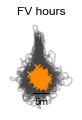

In [88]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

# Conditions
conditions = ['FV']
conditions_labels = ['FV']

filename_extra=''

search_dispersion_list['FV'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels=show_labels, show_axis=show_axis, distance_scaling_factor=distance_scaling_factor, conditions=conditions, conditions_labels=conditions_labels, filename_extra=filename_extra)


Outbound distance is 13.785538511658402
Outbound angle is 90.92611938128069
Wait (h) 2D dispersion Hom. dist median Hom. dist std Hom. exit ang median Hom. heading std Mean vect len Mean vect len proj
   ZV      1.094898     1.102  / 2.033    0.60 / 1.31   163.65  ( 163.65 )  139.1  /  74.7   0.022  -0.021  0.022


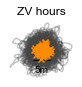

In [89]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

# Conditions
conditions = ['ZV']
conditions_labels = ['ZV']

filename_extra=''

search_dispersion_list['ZV'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels=show_labels, show_axis=show_axis, distance_scaling_factor=distance_scaling_factor, conditions=conditions, conditions_labels=conditions_labels, filename_extra=filename_extra)


Outbound distance is 13.785538511658402
Outbound angle is 90.92611938128069
Wait (h) 2D dispersion Hom. dist median Hom. dist std Hom. exit ang median Hom. heading std Mean vect len Mean vect len proj
   0       1.312596     13.219 / 12.800   1.18 / 2.69   358.89  ( -1.11  )   4.4   /  7.9    0.928  0.928   0.928
   1       1.143468     13.412 / 13.447   1.14 / 2.84    0.77   (  0.77  )   4.7   /  7.7    0.879  0.878   0.879
   24      1.728946     13.274 / 14.458   1.49 / 3.00   358.62  ( -1.38  )   6.8   /  8.9    0.914  0.914   0.914
   48      2.493199     13.924 / 14.392   1.82 / 2.99   359.17  ( -0.83  )   9.3   /  9.9    0.882  0.882   0.882
   96      3.199465     14.025 / 15.483   3.03 / 4.29    0.76   (  0.76  )   12.2  /  12.6   0.920  0.920   0.920
  144      3.553398     14.325 / 16.934   2.93 / 3.69    1.94   (  1.94  )   13.9  /  15.0   0.904  0.904   0.904
  192      4.570931     14.119 / 16.144   4.10 / 4.84    4.25   (  4.25  )   17.1  /  17.0   0.862  0.860   0.862
 

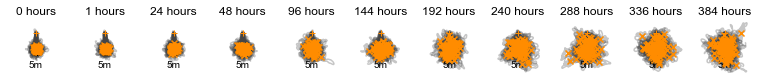

In [90]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

# Conditions
conditions = ['FV', 'FVIcen0.00257812', 'FVIcen0.01263018', 'FVIcen0.01786177', 'FVIcen0.02526036', 'FVIcen0.0309375', 'FVIcen0.03572355', 'FVIcen0.03994014', 'FVIcen0.04375223', 'FVIcen0.04725781', 'FVIcen0.05052073']
conditions_labels = [0, 1, 24, 48, 96, 144, 192, 240, 288, 336, 384] # Wait hours

filename_extra='withDiffusion'

search_dispersion_list['FVIcen'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels=show_labels, show_axis=show_axis, distance_scaling_factor=distance_scaling_factor, conditions=conditions, conditions_labels=conditions_labels, filename_extra=filename_extra)


Outbound distance is 13.785538511658402
Outbound angle is 90.92611938128069
Wait (h) 2D dispersion Hom. dist median Hom. dist std Hom. exit ang median Hom. heading std Mean vect len Mean vect len proj
   0       1.280300     13.266 / 13.107   1.21 / 2.60   359.42  ( -0.58  )   4.2   /  7.7    0.894  0.894   0.894
   1       1.246999     13.508 / 13.525   1.20 / 2.72   359.56  ( -0.44  )   4.6   /  9.0    0.914  0.914   0.914
   24      1.272905     13.408 / 13.643   1.20 / 2.78   359.30  ( -0.70  )   4.3   /  7.7    0.915  0.915   0.915
   48      1.325080     13.052 / 13.074   1.12 / 2.53   358.49  ( -1.51  )   4.9   /  7.3    0.894  0.894   0.894
   96      1.242092     12.670 / 12.941   0.98 / 2.57   359.86  ( -0.14  )   4.2   /  7.8    0.886  0.886   0.886
  144      1.138903     11.230 / 11.036   1.07 / 2.59   359.93  ( -0.07  )   5.7   /  10.4   0.885  0.885   0.885
  192      1.259561     8.709  / 7.973    1.09 / 2.59    0.38   (  0.38  )   7.4   /  14.7   0.738  0.738   0.738
 

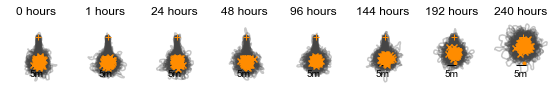

In [91]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

# Conditions
conditions = ['FVWaitl0', 'FVWaitl1', 'FVWaitl24', 'FVWaitl48', 'FVWaitl96', 'FVWaitl144', 'FVWaitl192', 'FVWaitl240']
conditions_labels = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours

filename_extra='withLogisticLoss'

search_dispersion_list['FVWaitl'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels=show_labels, show_axis=show_axis, distance_scaling_factor=distance_scaling_factor, conditions=conditions, conditions_labels=conditions_labels, filename_extra=filename_extra)


For wait_noise_sd = 0.0
Outbound distance is 13.785538511658402
Outbound angle is 90.92611938128069
Wait (h) 2D dispersion Hom. dist median Hom. dist std Hom. exit ang median Hom. heading std Mean vect len Mean vect len proj
   0       1.352805     13.085 / 13.582   1.22 / 2.70    0.40   (  0.40  )   4.4   /  7.7        0.891           0.891       
   1       1.246125     13.323 / 13.292   1.12 / 2.49   358.14  ( -1.86  )   4.4   /  7.5        0.917           0.917       
   24      1.351611     12.951 / 12.999   1.20 / 2.54    0.67   (  0.67  )   4.5   /  8.2        0.907           0.907       
   48      1.487253     13.024 / 13.540   1.35 / 2.52   358.17  ( -1.83  )   4.6   /  7.6        0.912           0.912       
   96      1.295923     12.380 / 12.038   1.23 / 2.49   359.02  ( -0.98  )   4.5   /  7.8        0.907           0.907       
  144      1.143693     11.040 / 10.845   1.02 / 2.33   358.58  ( -1.42  )   5.3   /  8.6        0.873           0.873       
  192      1.532379

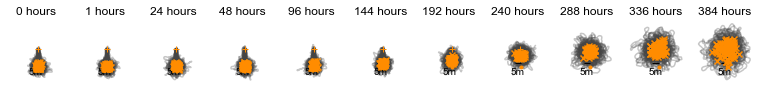

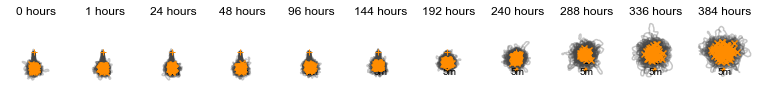

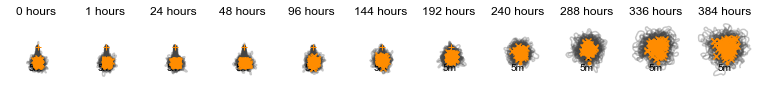

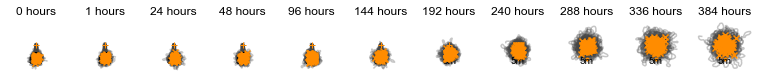

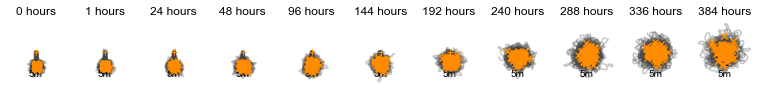

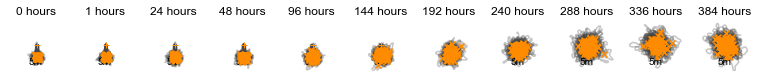

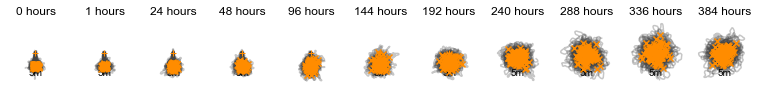

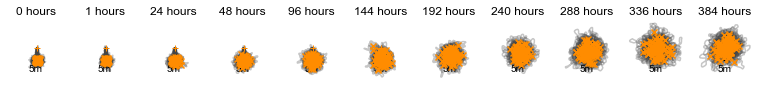

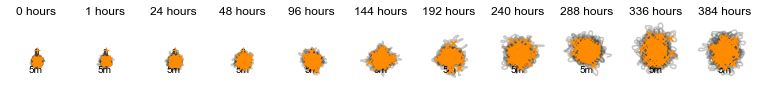

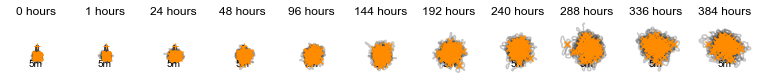

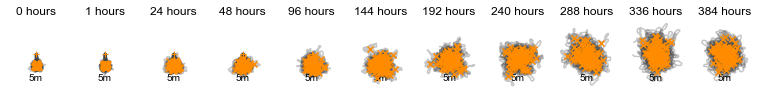

In [64]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

wait_hours = [0, 1, 24, 48, 96, 144, 192, 240] + [288, 336, 384] # Wait hours
conditions_labels = wait_hours # Wait hours
wait_noise_sd_list = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
for wait_noise_sd in wait_noise_sd_list:
    wait_noise_sd_str = str(wait_noise_sd)
    # Create conditions list
    #conditions = ['FVWaitNoise' + wait_noise_sd + 'b0', 'FVWaitNoise' + wait_noise_sd + 'b1', 'FVWaitNoise' + wait_noise_sd + 'b24', 'FVWaitNoise' + wait_noise_sd + 'b48', 'FVWaitNoise' + wait_noise_sd + 'b96', 'FVWaitNoise' + wait_noise_sd + 'b144', 'FVWaitNoise' + wait_noise_sd + 'b192', 'FVWaitNoise' + wait_noise_sd + 'b240']
    conditions = []
    for c in conditions_labels:
        conditions.append('FVWait' + str(float(c)) + 'h' + 'Noise' + wait_noise_sd_str)

    filename_extra='withLogisticLossAndNoise' + wait_noise_sd_str
    
    print('For wait_noise_sd = ' + wait_noise_sd_str)
    search_dispersion_list['FVWaitNoise' + wait_noise_sd_str + 'b'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels=show_labels, show_axis=show_axis, distance_scaling_factor=distance_scaling_factor, conditions=conditions, conditions_labels=conditions_labels, filename_extra=filename_extra)


### Store data to file

In [65]:
# Store the search_dispersion_list dict with the calculated path statistics to avoid recalculating them
filename_results_npz = 'path-integration-forget/data/path_analysis_calculation_results.npz'
# Do not overwrite np.savez(filename_results_npz, search_dispersion_list)

### Load data from file

In [13]:
# Load the data (search_dispersion_list dict) from previous run
filename_results_npz = 'path-integration-forget/data/path_analysis_calculation_results.npz'
search_dispersion_list = np.load(filename_results_npz, allow_pickle=True)['arr_0'][()]

Outbound distance is 13.785538511658402
Wait (h) 2D dispersion Homing distance std Homing heading std Homing distance median Mean vector length    
   0        1.35281          1.22066           0.0772853             13.0849                0.998384       
   1        1.24612          1.11961           0.0759863             13.3233                0.998647       
   24       1.35161          1.1967            0.0787731             12.9512                0.998742       
   48       1.48725          1.3519            0.0807855             13.0235                0.99859        
   96       1.29592          1.23226           0.0787077             12.3802                0.998382       
  144       1.14369          1.02281           0.0929926             11.0402                0.998185       
  192       1.53238          1.30776            0.123793             8.55316                0.998039       
  240       1.59943          1.17403            0.316054             4.99805                0.99

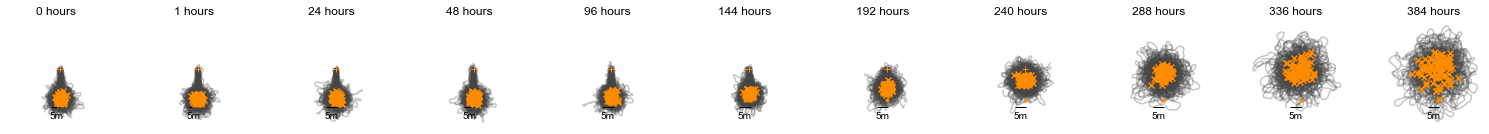

In [46]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

wait_noise_sd = 0.0
wait_noise_sd = str(wait_noise_sd)
# Conditions
#conditions = ['FVWaitNoise' + wait_noise_sd + 'b0', 'FVWaitNoise' + wait_noise_sd + 'b1', 'FVWaitNoise' + wait_noise_sd + 'b24', 'FVWaitNoise' + wait_noise_sd + 'b48', 'FVWaitNoise' + wait_noise_sd + 'b96', 'FVWaitNoise' + wait_noise_sd + 'b144', 'FVWaitNoise' + wait_noise_sd + 'b192', 'FVWaitNoise' + wait_noise_sd + 'b240']
wait_hours = [0, 1, 24, 48, 96, 144, 192, 240] + [288, 336, 384] # Wait hours
conditions_labels = [0, 1, 24, 48, 96, 144, 192, 240] + [288, 336, 384] # Wait hours
conditions = []
for c in conditions_labels:
    conditions.append('FVWait' + str(float(c)) + 'h' + 'Noise' + wait_noise_sd)
    
filename_extra='withLogisticLossAndNoise' + wait_noise_sd

search_dispersion_list['FVWaitNoise' + wait_noise_sd + 'b'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels, show_axis, distance_scaling_factor, conditions, conditions_labels, filename_extra)


Outbound distance is 13.785538511658402
Wait (h) 2D dispersion Homing distance std Homing heading std Homing distance median Mean vector length    
   0        1.27625          1.16607           0.0785936             13.4085                0.99873        
   1        1.47014          1.26779           0.0871151             13.2145                0.998592       
   24       3.35029          2.70395            0.20648              13.6564                0.999028       
   48       4.2985           3.31789            0.261877             14.1591                0.999221       
   96       5.76373          4.64682            0.39071              13.9743                0.999539       
  144       7.73226          5.63421            0.606953             13.9776                0.999623       
  192       8.32467          5.55805            1.06205              9.68149                0.999874       
  240       9.20675          5.59904            1.37798              10.2711                0.99

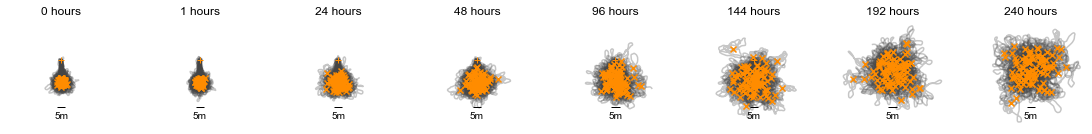

In [43]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

wait_noise_sd = 0.01
wait_noise_sd = str(wait_noise_sd)
# Conditions
#conditions = ['FVWaitNoise' + wait_noise_sd + 'b0', 'FVWaitNoise' + wait_noise_sd + 'b1', 'FVWaitNoise' + wait_noise_sd + 'b24', 'FVWaitNoise' + wait_noise_sd + 'b48', 'FVWaitNoise' + wait_noise_sd + 'b96', 'FVWaitNoise' + wait_noise_sd + 'b144', 'FVWaitNoise' + wait_noise_sd + 'b192', 'FVWaitNoise' + wait_noise_sd + 'b240']
wait_hours = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions_labels = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions = []
for c in conditions_labels:
    conditions.append('FVWait' + str(float(c)) + 'h' + 'Noise' + wait_noise_sd)

filename_extra='withLogisticLossAndNoise' + wait_noise_sd

search_dispersion_list['FVWaitNoise' + wait_noise_sd + 'b'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels=show_labels, show_axis=show_axis, distance_scaling_factor=distance_scaling_factor, conditions=conditions, conditions_labels=conditions_labels, filename_extra=filename_extra)


Outbound distance is 13.785538511658402
Wait (h) 2D dispersion Homing distance std Homing heading std Homing distance median Mean vector length    


FileNotFoundError: [Errno 2] No such file or directory: 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/FVWait0.0hNoise0.00275/with_Pontin_Holonomic_noiseSyn0.1_noiseRot2.0_noiseSlope9.0_route_FVWait0.0hNoise0.00275_1001.csv'

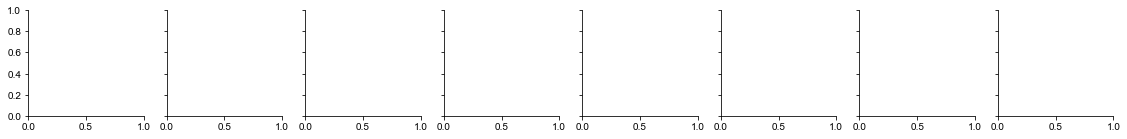

In [44]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

wait_noise_sd = 0.00275
wait_noise_sd = str(wait_noise_sd)
# Conditions
#conditions = ['FVWaitNoise' + wait_noise_sd + 'b0', 'FVWaitNoise' + wait_noise_sd + 'b1', 'FVWaitNoise' + wait_noise_sd + 'b24', 'FVWaitNoise' + wait_noise_sd + 'b48', 'FVWaitNoise' + wait_noise_sd + 'b96', 'FVWaitNoise' + wait_noise_sd + 'b144', 'FVWaitNoise' + wait_noise_sd + 'b192', 'FVWaitNoise' + wait_noise_sd + 'b240']
wait_hours = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions_labels = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions = []
for c in conditions_labels:
    conditions.append('FVWait' + str(float(c)) + 'h' + 'Noise' + wait_noise_sd)

filename_extra='withLogisticLossAndNoise' + wait_noise_sd

search_dispersion_list['FVWaitNoise' + wait_noise_sd + 'b'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels=show_labels, show_axis=show_axis, distance_scaling_factor=distance_scaling_factor, conditions=conditions, conditions_labels=conditions_labels, filename_extra=filename_extra)


In [ ]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

wait_noise_sd = 0.0055
wait_noise_sd = str(wait_noise_sd)
# Conditions
#conditions = ['FVWaitNoise' + wait_noise_sd + 'b0', 'FVWaitNoise' + wait_noise_sd + 'b1', 'FVWaitNoise' + wait_noise_sd + 'b24', 'FVWaitNoise' + wait_noise_sd + 'b48', 'FVWaitNoise' + wait_noise_sd + 'b96', 'FVWaitNoise' + wait_noise_sd + 'b144', 'FVWaitNoise' + wait_noise_sd + 'b192', 'FVWaitNoise' + wait_noise_sd + 'b240']
wait_hours = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions_labels = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions = []
for c in conditions_labels:
    conditions.append('FVWait' + str(float(c)) + 'h' + 'Noise' + wait_noise_sd)

filename_extra='withLogisticLossAndNoise' + wait_noise_sd

search_dispersion_list['FVWaitNoise' + wait_noise_sd + 'b'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels, show_axis, distance_scaling_factor, conditions, conditions_labels, filename_extra)


In [ ]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

wait_noise_sd = 0.006875
wait_noise_sd = str(wait_noise_sd)
# Conditions
#conditions = ['FVWaitNoise' + wait_noise_sd + 'b0', 'FVWaitNoise' + wait_noise_sd + 'b1', 'FVWaitNoise' + wait_noise_sd + 'b24', 'FVWaitNoise' + wait_noise_sd + 'b48', 'FVWaitNoise' + wait_noise_sd + 'b96', 'FVWaitNoise' + wait_noise_sd + 'b144', 'FVWaitNoise' + wait_noise_sd + 'b192', 'FVWaitNoise' + wait_noise_sd + 'b240']
wait_hours = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions_labels = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions = []
for c in conditions_labels:
    conditions.append('FVWait' + str(float(c)) + 'h' + 'Noise' + wait_noise_sd)

filename_extra='withLogisticLossAndNoise' + wait_noise_sd

search_dispersion_list['FVWaitNoise' + wait_noise_sd + 'b'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels, show_axis, distance_scaling_factor, conditions, conditions_labels, filename_extra)


In [ ]:
# Plot the full trajectories of simulated agents for all conditions

path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False
distance_scaling_factor = 3

wait_noise_sd = 0.00825
wait_noise_sd = str(wait_noise_sd)
# Conditions
#conditions = ['FVWaitNoise' + wait_noise_sd + 'b0', 'FVWaitNoise' + wait_noise_sd + 'b1', 'FVWaitNoise' + wait_noise_sd + 'b24', 'FVWaitNoise' + wait_noise_sd + 'b48', 'FVWaitNoise' + wait_noise_sd + 'b96', 'FVWaitNoise' + wait_noise_sd + 'b144', 'FVWaitNoise' + wait_noise_sd + 'b192', 'FVWaitNoise' + wait_noise_sd + 'b240']
wait_hours = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions_labels = [0, 1, 24, 48, 96, 144, 192, 240] # Wait hours
conditions = []
for c in conditions_labels:
    conditions.append('FVWait' + str(float(c)) + 'h' + 'Noise' + wait_noise_sd)

filename_extra='withLogisticLossAndNoise' + wait_noise_sd

search_dispersion_list['FVWaitNoise' + wait_noise_sd + 'b'], outbound_distance, fig, axs = calc_stats_plot_trajectories(path, outbound_path_filename, show_labels, show_axis, distance_scaling_factor, conditions, conditions_labels, filename_extra)


In [118]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def fit_data_points(ax, xdata, ydata, func, func_str='', init_vals=None, color=None):
    xvalues = np.linspace(np.min(xdata), np.max(xdata))
    popt, pcov = curve_fit(func, xdata, ydata, p0=init_vals)
    yvalues = func(xvalues, *popt)
    ax.plot(xvalues, yvalues, '-', color=color)
    print('The fitted curve parameters ' + func_str + ' are:', *popt)
    print('R^2 = {}'.format(r2_score(ydata, func(np.array(xdata), *popt))))

# Functions to use for regression to data
func_line_str = 'a*x + b'
def func_line(x, a, b):
    return a * x + b

func_exp_str='a * exp(-b*x) + c'
def func_exp(x, a, b, c):
    return a * np.exp(-b*x) + c

func_exp1_str='exp(b*x) + c'
def func_exp1(x, b, c):
    return np.exp(b*x) + c


func_sigmoid_logistic_modified_2_str = 'a / (1 + k * np.exp(r*x))'
def func_sigmoid_logistic_modified_2(x, a, r, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    return a / (1 + k * np.exp(r*x))

PopulationLoss_str = 'K / (1 + Nl/(K - Nl) * np.exp(-r * t))'
def PopulationLoss(t, K, Nl, r):
    return K / (1 + Nl/(K - Nl) * np.exp(-r * t))


In [119]:
def make_plot(ax, x, y, x_label='', y_label='', xticks=None, title=None, filename_extra_str='', func=func_exp, func_str=func_exp_str, init_vals=None):
    """
        ax                 : A figure axis object to plot in
        x, y               : The x and y values are lists or arrays
        x_label,           
        y_label            : The x and y axis labels
        xticks             : The tick values to show on the x axis
        filename_extra_str : Extra string to add to the filename when saving the figure
        func               : Function to regress to the data points
        func_str           : The funciton as a string for displaying
        init_vals          : None or a list with the initial regression function parameters
    """
    ax.plot(x, y, 'x', color='#444444') # Plot the data points
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if isinstance(xticks, list):
        ax.set_xticks(xticks) # eg [0, 24, 48, 96, 144, 192, 240]
    if title:
        ax.set_title(title)

    # Regress the function func to the data points
    fit_data_points(ax, x, y, func, func_str, init_vals=init_vals, color='#444444')


def plot_data_analysis(measure,                                                   # Dict key of measure data points to use 
                       wait_noise_sd_values,                                      # 
                       slice_t_max,                                               # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                       squared               = False,                             # Raise the y values to the power or 2
                       inverse               = False,                             # Plot the 1 / y of the data
                       normalise             = False,                             # Normalise data by plotting the y/max(y)
                       y_label               = '',                                # 
                       y_lim                 = [None, None],                      # Do not limit the y axis range
                       make_plot_func_list   = None,                              # list of dicts specifying the regression function to use for make_plot functions
                       common_figure         = None,                              # Plot each plot in a separate figure
                       file_spec_str         = 'homing_distance_vs_waiting_time', # Filename substring to use in the saved figures
                       func_predict          = None,                              # Function for producing target y values
                       func_plot_predictions = None                               # Function to plot the target y values
                       ):
    
    MSE_homing_dist = [] # To store the MSE values

    if common_figure:
        cols = common_figure.get('cols', 3) # Use the provided number of columns or 3 as default value
        rows = int(np.ceil((len(wait_noise_sd_values)+1) / cols))
        fig, axs = plt.subplots(rows, cols, figsize=(figsize[0]*cols, figsize[1]*rows)) # , figsize=figsize

    # Plot the Gaussian diffusion effect
    print('Noise(t)')
    if common_figure:
        ax = axs[0, 0] # Get the first subplot
    else:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Get the data and plot  
    wait_t = search_dispersion_list['FVIcen']["Wait"][0:slice_t_max]
    y = search_dispersion_list['FVIcen'][measure][0:slice_t_max]
    if squared:
        y = np.array(y)**2
    if inverse:
        y = 1 / np.array(y)
    if normalise:
        y = y / np.max(y)
    
    try:
        make_plot(ax, wait_t, y, x_label='Waiting time (h)', y_label=y_label, title='Diffusion', func=make_plot_func_list[0].get('func', None), func_str=make_plot_func_list[0].get('func_str', None), init_vals=make_plot_func_list[0].get('init_vals', None))
        ax.set_ylim(y_lim)
        if func_predict:
            func_plot_predictions(ax, wait_t)
            y_pred = func_predict(np.array(wait_t))
            MSE = mean_squared_error(y, y_pred)
            print('MSE =', MSE)
            MSE_homing_dist.append(MSE)
    except:
        ax.set_title('Diffusion')
        ax.set_ylim(y_lim)
        print('Exception: Issue plotting for Diffusion')
    if not common_figure and save_figures:
        fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_withDiffusion' + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0

    # Plot the logistic loss and noise effect
    for i,v in enumerate(wait_noise_sd_values):
        j = i+1 # Consider the preceding plots
        print()
        print('LogisticLoss(t) + Noise = ', v)
        if common_figure:
            ax = axs[int(j/cols), j%cols]
        else:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
    
        wait_t = search_dispersion_list['FVWaitNoise' + str(v) + 'b']["Wait"][0:slice_t_max]
        y = search_dispersion_list['FVWaitNoise' + str(v) + 'b'][measure][0:slice_t_max]
        if squared:
            y = np.array(y)**2
        if inverse:
            y = 1 / np.array(y)
        if normalise:
            y = y / np.max(y)
        
        try:
            make_plot(ax, wait_t, y, x_label='Waiting time (h)', y_label=y_label, title='LogisticLoss + Noise ' + str(v), func=make_plot_func_list[j].get('func', None), func_str=make_plot_func_list[j].get('func_str', None), init_vals=make_plot_func_list[j].get('init_vals', None))
            ax.set_ylim(y_lim)
            if func_predict:
                func_plot_predictions(ax, wait_t)
                y_pred = func_predict(np.array(wait_t))
                MSE = mean_squared_error(y, y_pred)
                print('MSE =', MSE)
                MSE_homing_dist.append(MSE)
        except:
            ax.set_title('LogisticLoss(t) + Noise ' + str(v))
            ax.set_ylim(y_lim)
            print('Exception: Issue plotting for noise =', v)

        if not common_figure and save_figures:
            fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_withLogisticLoss_And_Noise' + str(v) + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0

    # Plot the MSE of the fits
    if func_predict:
        fig2 = plt.figure()
        plt.plot(['Diff']+wait_noise_sd_values, MSE_homing_dist)
        plt.ylabel('MSE')
        plt.xlabel('Condition')

    if common_figure:
        plt.tight_layout()
        if save_figures:
            fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0
            if func_predict:
                fig2.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_MSE_' + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0



In [120]:
save_figures = False
save_figures_as_filetype = '.pdf'
figsize = figsize = (1.5*2.3, 1.5*2.0)

Noise(t)
The fitted curve parameters a * exp(-b*x) + c are: 0.7144358485221733 0.019115964705637263 0.21899758255090104
R^2 = 0.9781167724761106

LogisticLoss(t) + Noise =  0.0
Exception: Issue plotting for noise = 0.0

LogisticLoss(t) + Noise =  0.001
Exception: Issue plotting for noise = 0.001

LogisticLoss(t) + Noise =  0.002
Exception: Issue plotting for noise = 0.002

LogisticLoss(t) + Noise =  0.003
The fitted curve parameters a * exp(-b*x) + c are: 0.8867045177851365 0.003905693456113663 0.03430672545931525
R^2 = 0.9650815149673884

LogisticLoss(t) + Noise =  0.004
The fitted curve parameters a * exp(-b*x) + c are: 0.6973419153211463 0.010862243598363401 0.26543639090889204
R^2 = 0.9683331051939055

LogisticLoss(t) + Noise =  0.005
The fitted curve parameters a * exp(-b*x) + c are: 0.6715523705963093 0.011998486772529017 0.23894266802127187
R^2 = 0.9716600716685065

LogisticLoss(t) + Noise =  0.006
The fitted curve parameters a * exp(-b*x) + c are: 0.7269391503812561 0.019664295

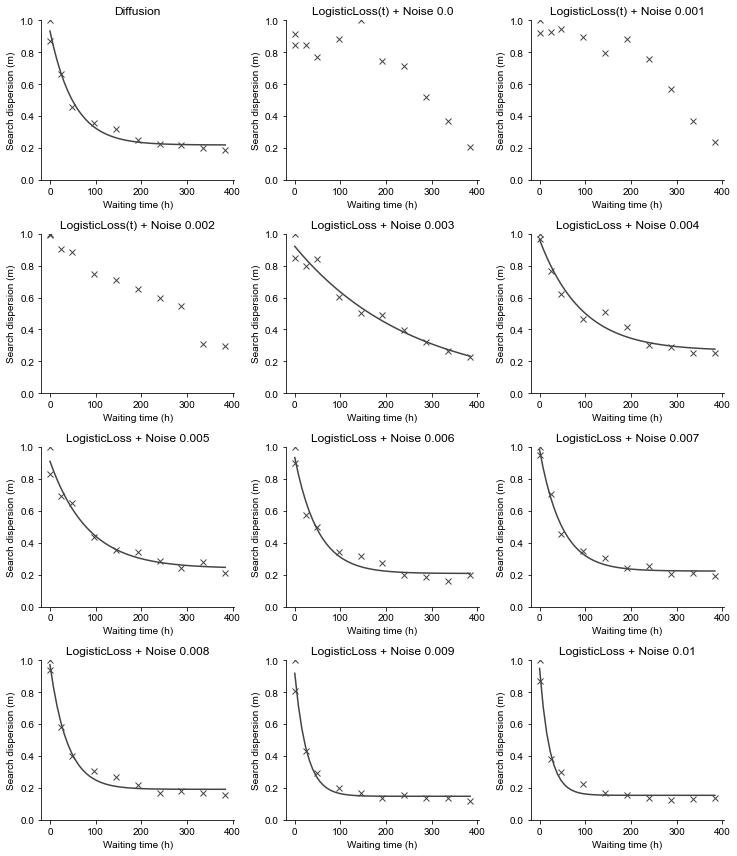

In [121]:
# Plot the search dispersion vs waiting time

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_exp, 'func_str': func_exp_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]

plot_data_analysis(measure               = "Dispersion",            # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 11,                      # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = False,                   # Raise the y values to the power or 2
                   inverse               = True,                    # Plot the 1 / y of the data
                   normalise             = True,                    # Normalise data by plotting the y/max(y)
                   y_label               = 'Search dispersion (m)', 
                   # y_lim               = [None, None],            # Do not limit the y axis range
                   y_lim                 = [0, 1],                 # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,     # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                    # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},             # Plot all plots in one figure
                   file_spec_str         = 'search_dispersion_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = None,                    # Function for producing target y values
                   func_plot_predictions = None                     # Function to plot the target y values
)


Noise(t)
The fitted curve parameters a*x + b are: 0.004118620177268162 13.428878456099048
R^2 = 0.7181201569445923
MSE = 17.356421649014038

LogisticLoss(t) + Noise =  0.0
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 13.259363355457351 0.022101735804039013 0.00810739102212593
R^2 = 0.998899762949057
MSE = 0.15159152036799367

LogisticLoss(t) + Noise =  0.001
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 13.381618515856474 0.021353852409311876 0.008975694644701137
R^2 = 0.9969528150646585
MSE = 0.26989513201309917

LogisticLoss(t) + Noise =  0.002
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 13.342733553240155 0.02172882529703406 0.007767489148529254
R^2 = 0.9980842380806502
MSE = 0.31530783760071235

LogisticLoss(t) + Noise =  0.003
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 13.27139020662438 0.02372060819079587 0.004854369056841083
R^2 = 0.9977838556533926
MSE = 0.395591271118658

LogisticLoss(t) + Noise =  0.004
The fitted curv

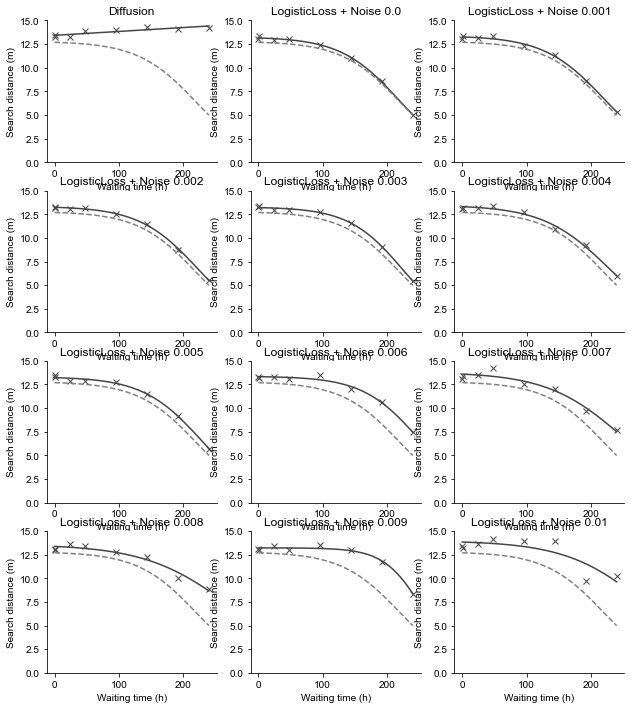

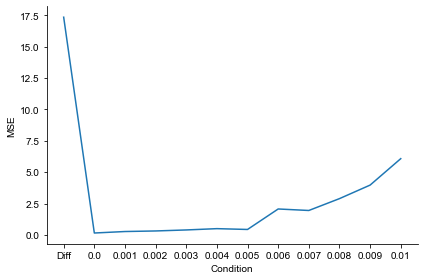

In [122]:
# Plot the median homing distance vs waiting time

def predict_PopulationLoss(wait_t):
    K, Nl, r = 12.79111889, 0.09954786, -0.0220668
    y_1 = PopulationLoss(wait_t, K, Nl, r)
    return y_1

def plot_ant_homing_distance(ax, wait_t):
    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
    y_1 = predict_PopulationLoss(x_1)
    ax.plot(x_1, y_1, '--', color='grey')

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_sigmoid_logistic_modified_2, 'func_str': func_sigmoid_logistic_modified_2_str, 'init_vals': [12.0, 0.0220667871, 0.00784362457]} for i in range(len(wait_noise_sd_values)+1)]
make_plot_func_list[0] = {'func': func_line, 'func_str': func_line_str, 'init_vals': None}


plot_data_analysis(measure               = "Distance_Median",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 8,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = False,                   # Raise the y values to the power or 2
                   inverse               = False,                 # Plot the 1 / y of the data
                   normalise             = False,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Search distance (m)', 
                   # y_lim               = [None, None],          # Do not limit the y axis range
                   y_lim                 = [0, 15],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_distance_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = predict_PopulationLoss,            # Function for producing target y values
                   func_plot_predictions = plot_ant_homing_distance           # Function to plot the target y values
)


The fitted curve parameters a*x + b are: 0.008999489146272584 0.8740822369339935
R^2 = 0.980819930531648
The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.402237699315801 1.1143745570987118 0.00022842045398192132
R^2 = 0.9988551347302513
The fitted curve parameters a*x + b are: 0.0006718677094633696 0.7870022862795758
R^2 = 0.13036729649673462


/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))
/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))


The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.190484054626449 1.0787448692293047 0.00029053965066425504
R^2 = 0.9987282413205455
The fitted curve parameters a*x + b are: -0.00012640276052355124 0.8324409558822371
R^2 = 0.008055982833286457


/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))


The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.299937462172158 1.0489715657429743 0.00034135086712783593
R^2 = 0.9963242305561731
The fitted curve parameters a*x + b are: 0.0003553753962107775 0.8542746562955007
R^2 = 0.0898976153083747


/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))
/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))


The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.275110065890328 1.062628087050038 0.00028958862951613477
R^2 = 0.9976274248143715
The fitted curve parameters a*x + b are: 0.0022806476080476923 0.8414839632289364
R^2 = 0.9291967043664935
The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.233632563157855 1.1478499976426835 0.0001475972018514762
R^2 = 0.9978578281888818
The fitted curve parameters a*x + b are: 0.0033659843145557033 0.8599556287040233
R^2 = 0.9250698036991443


/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))
/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))


The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.351915719069211 0.9662346655510498 0.0005431765794809583
R^2 = 0.9900141864108868
The fitted curve parameters a*x + b are: 0.00410620978468601 0.9331730205374922
R^2 = 0.7880321730967021
The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.257497045715262 1.069290724875544 0.0002533726002556335
R^2 = 0.9961850326437569
The fitted curve parameters a*x + b are: 0.005994188272914425 0.8950545059705372
R^2 = 0.9593956275995994


/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))
/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in multiply
  return a / (1 + k * np.exp(r*x))
/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))
/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/2840597670.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=figsize)


The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.33888769933581 1.1127977719330022 0.00010842557309014628
R^2 = 0.9861804900867077
The fitted curve parameters a*x + b are: 0.008410598335250784 0.9673279392284482
R^2 = 0.9184229555855659
The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.631725412939405 0.8679145926622499 0.0008011645809170385
R^2 = 0.9578869772827301
The fitted curve parameters a*x + b are: 0.009343502239645973 1.1058418276959194
R^2 = 0.8619212246087486


/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))
/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))


The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.43508882724451 0.764019713305454 0.0012372062800151316
R^2 = 0.9563234779910146
The fitted curve parameters a*x + b are: 0.010345910921920054 1.0915769924506946
R^2 = 0.8266270912344247
The fitted curve parameters a / (1 + k * exp(r*x)) are: 13.211591921826752 1.604873469729026 1.5396137321231712e-06
R^2 = 0.9846173982803949
The fitted curve parameters a*x + b are: 0.013554809257836253 1.18110052969645
R^2 = 0.7505304597547134
The fitted curve parameters a / (1 + k * exp(r*x)) are: -0.008304718652855073 2.0660824253084374e-05 -1.0005593573635327
R^2 = 0.360378869860835
The fitted curve parameters a*x + b are: 0.013459814141725479 1.4291821024796112
R^2 = 0.7880608782777083


/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_1313/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))


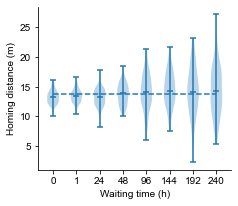

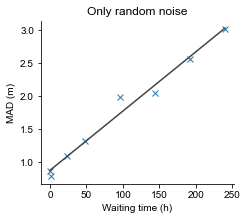

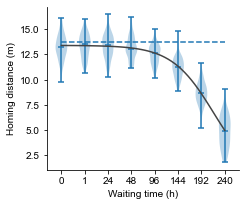

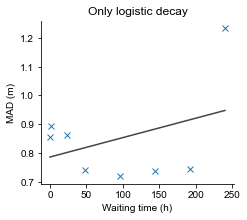

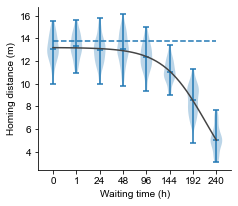

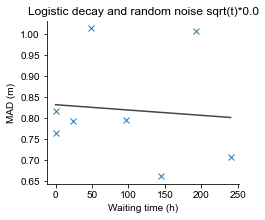

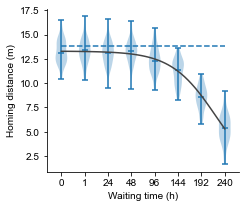

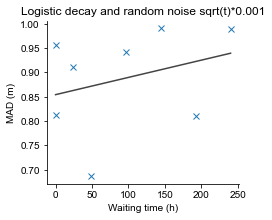

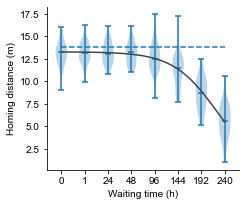

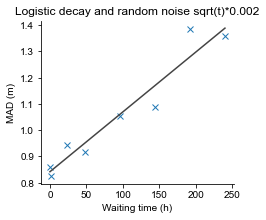

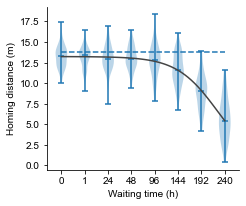

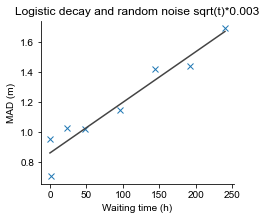

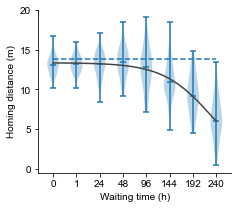

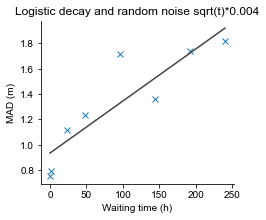

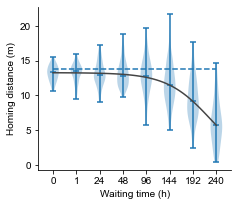

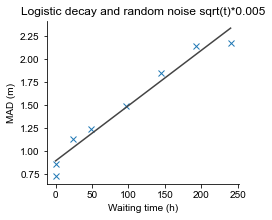

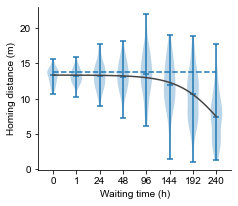

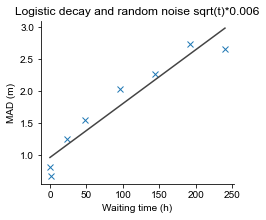

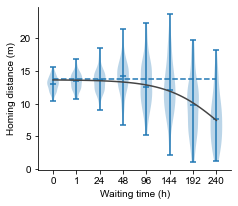

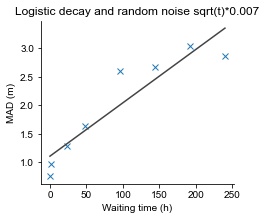

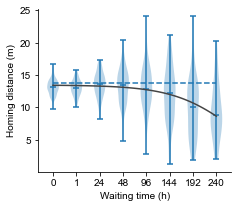

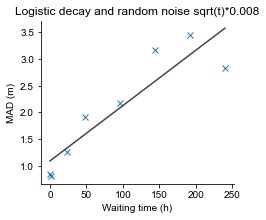

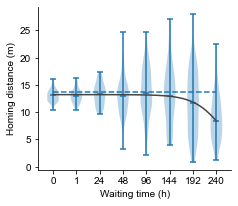

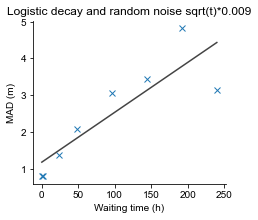

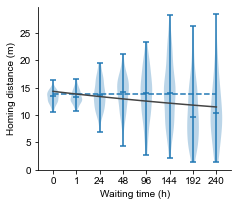

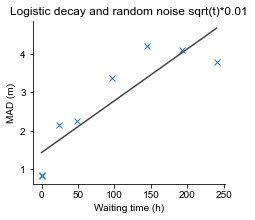

In [16]:
# Plot the homing distance data point spread vs waiting time

# Use only the first 8 wait_t times
slice_max = 8 # 11 to include all wait_t times (up to 400h)

def make_plot_violin(wait_t, search_distance_data, filename_extra_str):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    violin_parts = ax.violinplot(search_distance_data, showmedians=True)

    # Plot the nominal outbound distance
    ax.hlines(outbound_distance, 1, len(wait_t), linestyles='dashed')

    ax.set_xticks(np.arange(1, len(wait_t) + 1))
    ax.set_xticklabels(wait_t)

    ax.set_xlabel('Waiting time (h)')
    ax.set_ylabel('Homing distance (m)')

    if save_figures:
        fig.savefig(images_path + 'simulated_fullRelease_' + 'homing_distance_vs_waiting_time_violin' + filename_extra_str + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0
    return (fig, ax)

def func_pow(x, a, b):
    return a*x**2 + b

wait_t = search_dispersion_list['FVIcen']["Wait"][0:slice_max]
search_distance_data = search_dispersion_list['FVIcen']["Distance_hypot"][0:slice_max]
fig, ax = make_plot_violin(wait_t, search_distance_data, '_withDiffusion')
median_distance_hypot = np.median(search_distance_data, axis=1)
#fit_data_points(ax, range(1, len(wait_t)+1), median_distance_hypot, func_line, func_str='a*x + b', init_vals=None, color='#444444')
#plt.ylim([0, 25])

fig, ax = plt.subplots(1, 1, figsize=figsize)
#MofAD = np.median(np.abs(np.array(search_distance_data)-outbound_distance), axis=1)
MAD = []
median_search_distance_data = np.median(np.array(search_distance_data), axis=1)
for i in range(len(median_search_distance_data)):
    MAD.append(np.median(np.abs(np.array(search_distance_data)[i] - median_search_distance_data[i])))
ax.plot(wait_t, MAD, 'x')
ax.set_title('Only random noise')
ax.set_xlabel('Waiting time (h)')
ax.set_ylabel('MAD (m)')
fit_data_points(ax, wait_t, MAD, func_line, func_str='a*x + b', init_vals=None, color='#444444')
#ax.set_ylim([0, 8])

wait_t = search_dispersion_list['FVWaitl']["Wait"]
search_distance_data = search_dispersion_list['FVWaitl']["Distance_hypot"]
fig, ax = make_plot_violin(wait_t, search_distance_data, '_withLogisticLoss')
median_distance_hypot = np.median(search_distance_data, axis=1)
fit_data_points(ax, range(1, len(wait_t)+1), median_distance_hypot, func_sigmoid_logistic_modified_2, func_str='a / (1 + k * exp(r*x))', init_vals=[12.0, 0.0220667871, 0.00784362457], color='#444444')
#plt.ylim([0, 25])

fig, ax = plt.subplots(1, 1, figsize=figsize)
#MofAD = np.median(np.abs(np.array(search_distance_data)-outbound_distance), axis=1)
MAD = []
median_search_distance_data = np.median(np.array(search_distance_data), axis=1)
for i in range(len(median_search_distance_data)):
    MAD.append(np.median(np.abs(np.array(search_distance_data)[i] - median_search_distance_data[i])))
ax.plot(wait_t, MAD, 'x')
ax.set_title('Only logistic decay')
ax.set_xlabel('Waiting time (h)')
ax.set_ylabel('MAD (m)')
fit_data_points(ax, wait_t, MAD, func_line, func_str='a*x + b', init_vals=None, color='#444444')
#ax.set_ylim([0, 8])

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]


for v in wait_noise_sd_values:
    wait_t = search_dispersion_list['FVWaitNoise' + str(v) + 'b']["Wait"][0:slice_max]
    search_distance_data = search_dispersion_list['FVWaitNoise' + str(v) + 'b']["Distance_hypot"][0:slice_max]
    fig, ax = make_plot_violin(wait_t, search_distance_data, '_withLogisticLoss_And_Noise' + str(v))
    median_distance_hypot = np.median(search_distance_data, axis=1)
    fit_data_points(ax, range(1, len(wait_t)+1), median_distance_hypot, func_sigmoid_logistic_modified_2, func_str='a / (1 + k * exp(r*x))', init_vals=[12.0, 0.0220667871, 0.00784362457], color='#444444')
    #plt.ylim([0, 25])
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    #MofAD = np.median(np.abs(np.array(search_distance_data)-outbound_distance), axis=1)
    MAD = []
    median_search_distance_data = np.median(np.array(search_distance_data), axis=1)
    for i in range(len(median_search_distance_data)):
        MAD.append(np.median(np.abs(np.array(search_distance_data)[i] - median_search_distance_data[i])))
    ax.plot(wait_t, MAD, 'x')
    ax.set_title('Logistic decay and random noise sqrt(t)*' + str(v))
    ax.set_xlabel('Waiting time (h)')
    ax.set_ylabel('MAD (m)')
    fit_data_points(ax, wait_t, MAD, func_line, func_str='a*x + b', init_vals=None, color='#444444')
    #ax.set_ylim([0, 8])


Text(0.5, 1.0, 'Ziegler1995')

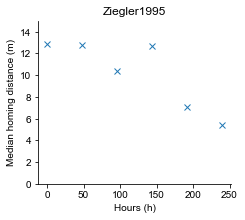

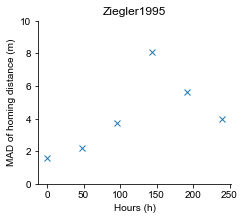

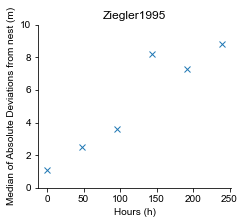

In [17]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot([0, 48, 96, 144, 192, 240 ], [12.9, 12.8, 10.4, 12.7, 7.1, 5.4], 'x')
ax.set_ylim([0, 15])
ax.set_ylabel('Median homing distance (m)')
ax.set_xlabel('Hours (h)')
ax.set_title('Ziegler1995')

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot([0, 48, 96, 144, 192, 240 ], [1.6, 2.2, 3.7, 8.1, 5.6, 4.0], 'x')
ax.set_ylim([0, 10])
ax.set_ylabel('MAD of homing distance (m)')
ax.set_xlabel('Hours (h)')
ax.set_title('Ziegler1995')

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot([0, 48, 96, 144, 192, 240 ], [1.1, 2.5, 3.6, 8.2, 7.3, 8.8], 'x')
ax.set_ylim([0, 10])
ax.set_ylabel('Median of Absolute Deviations from nest (m)')
ax.set_xlabel('Hours (h)')
ax.set_title('Ziegler1995')


Noise(t)
The fitted curve parameters a * exp(-b*x) + c are: 0.7410181077955034 0.014960761782221384 0.2503530250966653
R^2 = 0.9894493612117775

LogisticLoss(t) + Noise =  0.0
The fitted curve parameters a * exp(-b*x) + c are: -0.020389738281619243 19.750878321578355 0.8583024816534961
R^2 = 0.008953924421551407

LogisticLoss(t) + Noise =  0.001
The fitted curve parameters a * exp(-b*x) + c are: 0.03119367505347628 1.0089618438509893 0.9024751120469663
R^2 = 0.026206541383219872

LogisticLoss(t) + Noise =  0.002
The fitted curve parameters a * exp(-b*x) + c are: 0.7944495510262845 0.002854908840871034 0.19638836395987846
R^2 = 0.9004701294461241

LogisticLoss(t) + Noise =  0.003
The fitted curve parameters a * exp(-b*x) + c are: 0.5249305117730486 0.007094281294877697 0.4340232398081212
R^2 = 0.9119651155265239

LogisticLoss(t) + Noise =  0.004
The fitted curve parameters a * exp(-b*x) + c are: 0.5313217394441918 0.025421232159201394 0.46335405786049805
R^2 = 0.9845081504343612

Logist

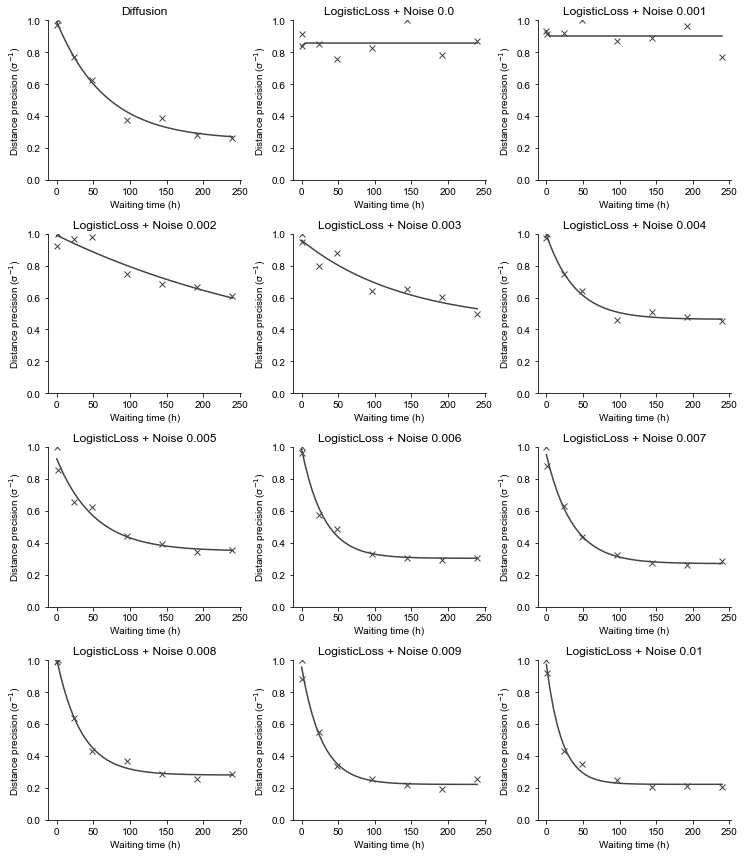

In [123]:
# Plot distance precision vs waiting time

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_exp, 'func_str': func_exp_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]
#make_plot_func_list[1]['init_vals'] = [0.03119367505347628, 1.0089618438509893, 0.9024751120469663]
#make_plot_func_list[2]['init_vals'] = [0.7944495510262845, 0.002854908840871034, 0.19638836395987846]
make_plot_func_list[6]['init_vals'] = [0.5, 0.02, 0.4]


plot_data_analysis(measure               = "Distance_Dispersion",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 8,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = False,                   # Raise the y values to the power or 2
                   inverse               = True,                 # Plot the 1 / y of the data
                   normalise             = True,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Distance precision (σ$^{-1}$)', 
                   # y_lim               = [None, None],          # Do not limit the y axis range
                   y_lim                 = [0, 1],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_distance_accuracy_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = None,            # Function for producing target y values
                   func_plot_predictions = None           # Function to plot the target y values
)


Noise(t)
The fitted curve parameters a*x + b are: 0.014622086025898762 1.5931559724057525
R^2 = 0.9606609182488969
MSE = 4.737358434202575

LogisticLoss(t) + Noise =  0.0
The fitted curve parameters a*x + b are: 0.027462657937301405 0.5593539203994566
R^2 = 0.8318629245793441
MSE = 2.9070644382126707

LogisticLoss(t) + Noise =  0.001
The fitted curve parameters a*x + b are: 0.025910017216397196 0.6592153667040668
R^2 = 0.8380142774375398
MSE = 3.022965422890687

LogisticLoss(t) + Noise =  0.002
The fitted curve parameters a*x + b are: 0.026302813614298204 0.6363491741898728
R^2 = 0.8475560070115719
MSE = 2.9038799748487314

LogisticLoss(t) + Noise =  0.003
The fitted curve parameters a*x + b are: 0.02730184454906362 0.658784926362746
R^2 = 0.82890759030751
MSE = 2.735426668600639

LogisticLoss(t) + Noise =  0.004
The fitted curve parameters a*x + b are: 0.02922299146488673 0.8530370057191671
R^2 = 0.9099382676551453
MSE = 1.3643141928053413

LogisticLoss(t) + Noise =  0.005
The fitted 

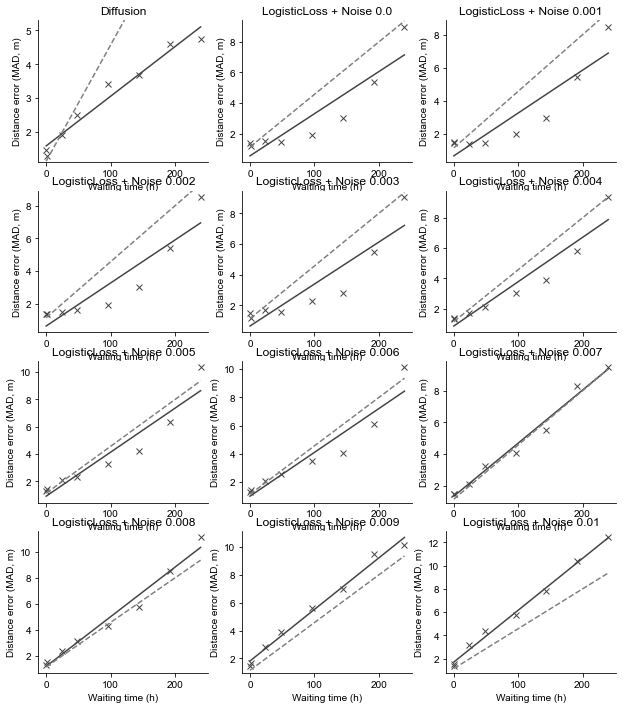

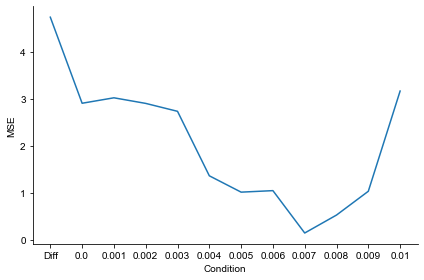

In [124]:
# Plot the homing distance error spread vs waiting time

# Plot the ant data slope
def plot_ant_homing_distance_error_slope(ax, wait_t):
    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
    y_1 = 0.03422619*x_1 + 1.14285714
    ax.plot(x_1, y_1, '--', color='grey')

def predict_homing_distance_error_MAD(x_1):
    y_1 = 0.03422619*x_1 + 1.14285714
    return y_1

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_line, 'func_str': func_line_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]
make_plot_func_list[0] = {'func': func_line, 'func_str': func_line_str, 'init_vals': None}


plot_data_analysis(measure               = "Distance_to_Nest_Dispersion",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 8,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = False,                   # Raise the y values to the power or 2
                   inverse               = False,                 # Plot the 1 / y of the data
                   normalise             = False,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Distance error (MAD, m)', 
                   y_lim               = [None, None],          # Do not limit the y axis range
                   #y_lim                 = [0, 15],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_distance_error_MAD_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = predict_homing_distance_error_MAD,            # Function for producing target y values
                   func_plot_predictions = plot_ant_homing_distance_error_slope           # Function to plot the target y values
)


Noise(t)
The fitted curve parameters a*x + b are: 0.09020470790879245 1.942061026135087
R^2 = 0.983836486725434
MSE = 747.6557002510101

LogisticLoss(t) + Noise =  0.0
The fitted curve parameters a*x + b are: 0.2515740453472407 -7.149380536200653
R^2 = 0.6898918816783106
MSE = 385.4657634275249

LogisticLoss(t) + Noise =  0.001
The fitted curve parameters a*x + b are: 0.2286640880616072 -6.05681794368344
R^2 = 0.714477298185695
MSE = 388.73835510032706

LogisticLoss(t) + Noise =  0.002
The fitted curve parameters a*x + b are: 0.2325224636342229 -6.221791270084096
R^2 = 0.7167533919882372
MSE = 381.2544752060811

LogisticLoss(t) + Noise =  0.003
The fitted curve parameters a*x + b are: 0.2547067205402622 -6.961034051940717
R^2 = 0.6865304743247191
MSE = 379.6440596529747

LogisticLoss(t) + Noise =  0.004
The fitted curve parameters a*x + b are: 0.2805015098181349 -6.550509823940635
R^2 = 0.749805870360208
MSE = 276.34489577136924

LogisticLoss(t) + Noise =  0.005
The fitted curve parame

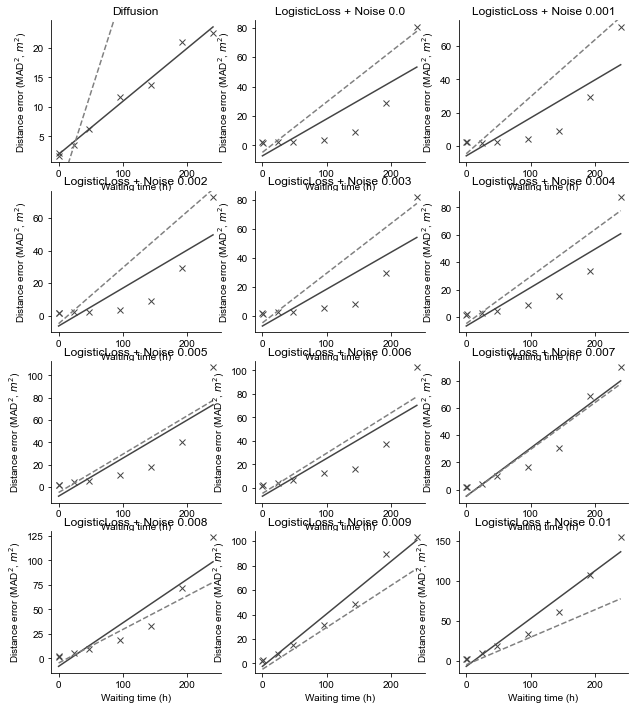

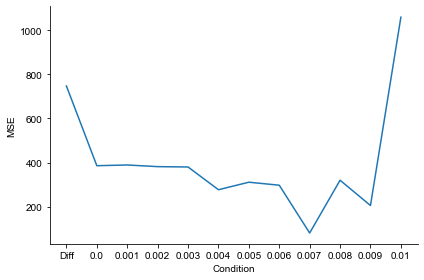

In [125]:
# Plot the homing distance error spread vs waiting time

# Plot the ant data slope
def plot_ant_homing_distance_error_slope_squared(ax, wait_t):
    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
    y_1 = 0.34318452*x_1 - 4.78380962
    ax.plot(x_1, y_1, '--', color='grey')

def predict_homing_distance_error_MAD_squared(x_1):
    y_1 = 0.34318452*x_1 - 4.78380962
    return y_1

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_line, 'func_str': func_line_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]
make_plot_func_list[0] = {'func': func_line, 'func_str': func_line_str, 'init_vals': None}


plot_data_analysis(measure               = "Distance_to_Nest_Dispersion",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 8,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = True,                  # Raise the y values to the power or 2
                   inverse               = False,                 # Plot the 1 / y of the data
                   normalise             = False,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Distance error (MAD$^2$, $m^2$)', 
                   y_lim                 = [None, None],          # Do not limit the y axis range
                   #y_lim                 = [0, 15],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_distance_error_MAD2_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = predict_homing_distance_error_MAD_squared,            # Function for producing target y values
                   func_plot_predictions = plot_ant_homing_distance_error_slope_squared           # Function to plot the target y values
)


Noise(t)
The fitted curve parameters exp(b*x) + c are: -0.005427184414979232 -0.1182646823018651
R^2 = 0.8803576657170947
MSE = 0.03149076390552771

LogisticLoss(t) + Noise =  0.0
The fitted curve parameters exp(b*x) + c are: -0.005640434753889006 -0.04241133084175726
R^2 = 0.940807633241822
MSE = 0.06694660536159142

LogisticLoss(t) + Noise =  0.001
The fitted curve parameters exp(b*x) + c are: -0.005670919031897471 0.027459256950497987
R^2 = 0.8865043859385034
MSE = 0.11037960295068369

LogisticLoss(t) + Noise =  0.002
The fitted curve parameters exp(b*x) + c are: -0.006105466321743852 0.02081518266503916
R^2 = 0.9514739435898731
MSE = 0.08352201090259265

LogisticLoss(t) + Noise =  0.003
The fitted curve parameters exp(b*x) + c are: -0.005266400773729492 -0.09963587117673615
R^2 = 0.9380211864238029
MSE = 0.05126364788717072

LogisticLoss(t) + Noise =  0.004
The fitted curve parameters exp(b*x) + c are: -0.007292502356352328 -0.04580411501245497
R^2 = 0.9902541791661628
MSE = 0.0264

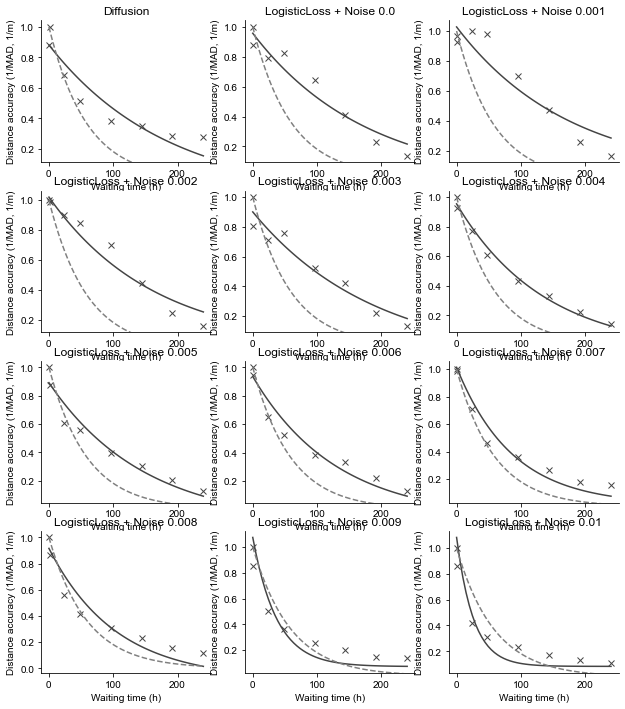

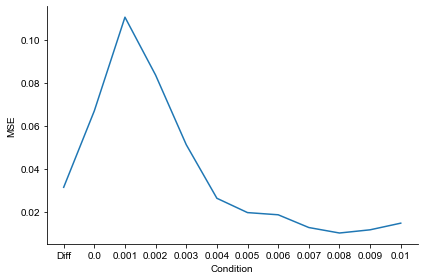

In [126]:
# Plot the homing distance error spread vs waiting time

# Plot the ant data slope
def plot_ant_homing_distance_accuracy_1_over_MAD_squared(ax, wait_t):
    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
    y_1 = np.exp(-0.41/24*x_1)
    ax.plot(x_1, y_1, '--', color='grey')

def predict_ant_homing_distance_accuracy_1_over_MAD_squared(x_1):
    y_1 = np.exp(-0.41/24*x_1)
    return y_1

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_exp1, 'func_str': func_exp1_str, 'init_vals': [-0.1, 0.0]} for i in range(len(wait_noise_sd_values)+1)]
make_plot_func_list[0]['init_vals'] = [-0.1, 0.0]
make_plot_func_list[1]['init_vals'] = [-0.1, 0.0]
make_plot_func_list[2]['init_vals'] = [-0.1, 0.0]

plot_data_analysis(measure               = "Distance_to_Nest_Dispersion",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 8,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = False,                  # Raise the y values to the power or 2
                   inverse               = True,                 # Plot the 1 / y of the data
                   normalise             = True,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Distance accuracy (1/MAD, 1/m)', 
                   y_lim                 = [None, None],          # Do not limit the y axis range
                   #y_lim                 = [0, 15],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_distance_accuracy_MAD-1_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = predict_ant_homing_distance_accuracy_1_over_MAD_squared,            # Function for producing target y values
                   func_plot_predictions = plot_ant_homing_distance_accuracy_1_over_MAD_squared           # Function to plot the target y values
)


Noise(t)
The fitted curve parameters exp(b*x) + c are: -0.02824130939167408 0.014063624508436224
R^2 = 0.9110464711992751

LogisticLoss(t) + Noise =  0.0
The fitted curve parameters exp(b*x) + c are: -0.007754919744424772 -0.12021100397867518
R^2 = 0.9405480680703843

LogisticLoss(t) + Noise =  0.001
The fitted curve parameters exp(b*x) + c are: -0.007704609912179476 -0.01924687407192611
R^2 = 0.8571335040529304

LogisticLoss(t) + Noise =  0.002
The fitted curve parameters exp(b*x) + c are: -0.00928282547982559 -0.013400866331387226
R^2 = 0.9706343826669528

LogisticLoss(t) + Noise =  0.003
The fitted curve parameters exp(b*x) + c are: -0.006991428570115813 -0.20398275964875764
R^2 = 0.8856502458337742

LogisticLoss(t) + Noise =  0.004
The fitted curve parameters exp(b*x) + c are: -0.01735537454016936 -0.025495133525305864
R^2 = 0.9812115548381389

LogisticLoss(t) + Noise =  0.005
The fitted curve parameters exp(b*x) + c are: -0.029405371901103778 -0.00357760773625752
R^2 = 0.913280952

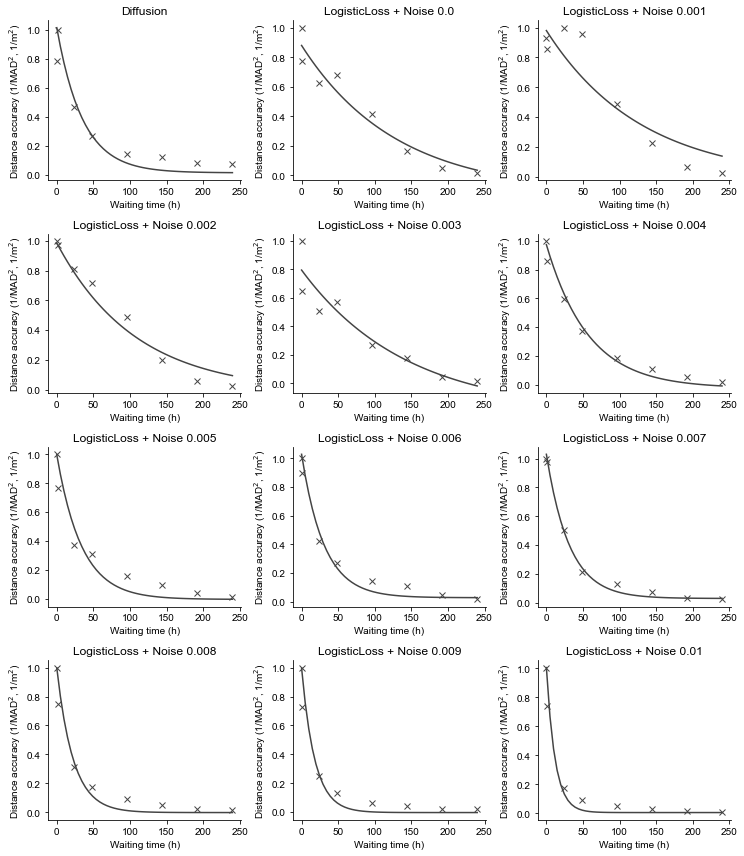

In [127]:
# Plot the homing distance error spread vs waiting time

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_exp1, 'func_str': func_exp1_str, 'init_vals': [-0.1, 0.0]} for i in range(len(wait_noise_sd_values)+1)]
make_plot_func_list[0]['init_vals'] = [-0.1, 0.0]
make_plot_func_list[1]['init_vals'] = [-0.1, 0.0]
make_plot_func_list[2]['init_vals'] = [-0.1, 0.0]

plot_data_analysis(measure               = "Distance_to_Nest_Dispersion",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 8,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = True,                  # Raise the y values to the power or 2
                   inverse               = True,                 # Plot the 1 / y of the data
                   normalise             = True,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Distance accuracy (1/MAD$^2$, 1/m$^2$)', 
                   y_lim                 = [None, None],          # Do not limit the y axis range
                   #y_lim                 = [0, 15],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_distance_accuracy_MAD2-1_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = None,            # Function for producing target y values
                   func_plot_predictions = None           # Function to plot the target y values
)


Noise(t)
The fitted curve parameters a * exp(-b*x) + c are: -1.1344978054327233 0.003170340217519664 1.3343819298374147
R^2 = 0.9899135654808122

LogisticLoss(t) + Noise =  0.0
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 1.056294677081615 -0.03748694279323786 69991.27858582551
R^2 = 0.9927102908468028

LogisticLoss(t) + Noise =  0.001
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 1.0814871290855104 -0.031342147316657964 12174.57847754137
R^2 = 0.9930946615465521

LogisticLoss(t) + Noise =  0.002
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 1.0793940888992946 -0.030610198575087833 6368.529492946393
R^2 = 0.9876622741310491

LogisticLoss(t) + Noise =  0.003
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 1.0580600565436296 -0.031975299113234004 5569.125308365891
R^2 = 0.9854671847599981

LogisticLoss(t) + Noise =  0.004
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 1.1233802823713759 -0.020093823062145674 183.6605888016309

/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_22392/204587548.py:19: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b*x) + c
/var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_22392/204587548.py:34: RuntimeWarning: overflow encountered in exp
  return a / (1 + k * np.exp(r*x))


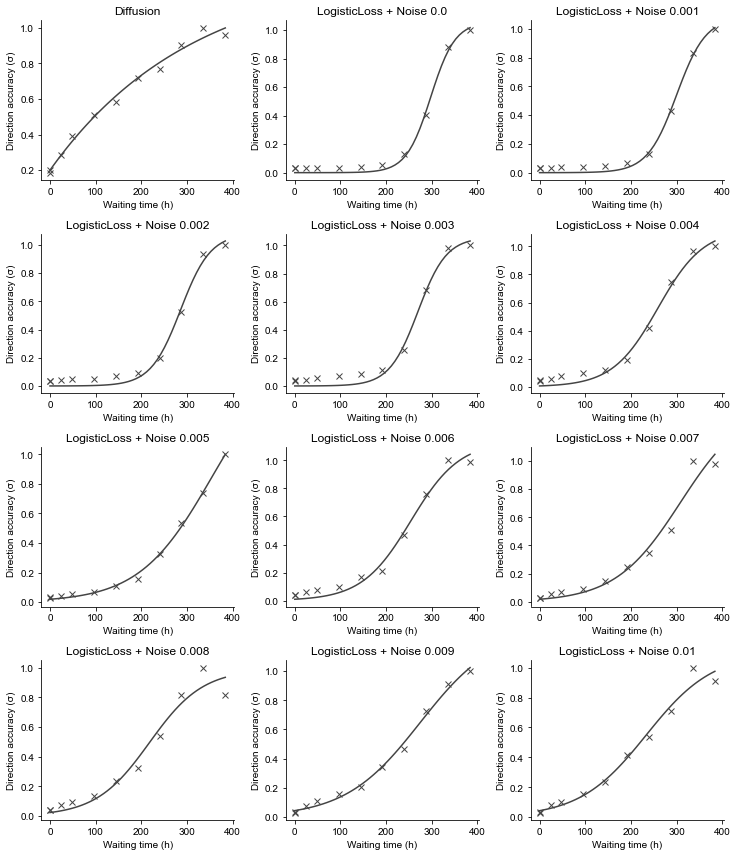

In [128]:
# Plot homing direction dispersion vs waiting time

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_sigmoid_logistic_modified_2, 'func_str': func_sigmoid_logistic_modified_2_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]
make_plot_func_list[0] = {'func': func_exp, 'func_str': func_exp_str, 'init_vals': None}

plot_data_analysis(measure               = "Angle_Dispersion",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 11,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = False,                  # Raise the y values to the power or 2
                   inverse               = False,                 # Plot the 1 / y of the data
                   normalise             = True,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Direction accuracy (σ)', 
                   y_lim                 = [None, None],          # Do not limit the y axis range
                   #y_lim                 = [0, 15],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_angle_accuracy_sigma_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = None,            # Function for producing target y values
                   func_plot_predictions = None           # Function to plot the target y values
)


Noise(t)
The fitted curve parameters a * exp(-b*x) + c are: 0.743132629187511 0.020212805568423108 0.22323030874580663
R^2 = 0.9878810085401982
MSE = 0.01400429176018045

LogisticLoss(t) + Noise =  0.0
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 0.9785229325886357 0.029840753642412142 0.002151512952323721
R^2 = 0.9973290827180433
MSE = 0.09028232533714198

LogisticLoss(t) + Noise =  0.001
The fitted curve parameters a / (1 + k * np.exp(r*x)) are: 0.9722982307444948 0.020148456071877593 0.0245540927368885
R^2 = 0.9908108368193131
MSE = 0.05050008106276988

LogisticLoss(t) + Noise =  0.002
The fitted curve parameters a * exp(-b*x) + c are: 1.3189001861658687 0.003340652784607359 -0.3799947315439102
R^2 = 0.9804919549693228
MSE = 0.01415084980611677

LogisticLoss(t) + Noise =  0.003
The fitted curve parameters a * exp(-b*x) + c are: 1.1957708312904234 0.004347434810675617 -0.228941026724179
R^2 = 0.9890462373595026
MSE = 0.010288574384087621

LogisticLoss(t) + Noise =  0.00

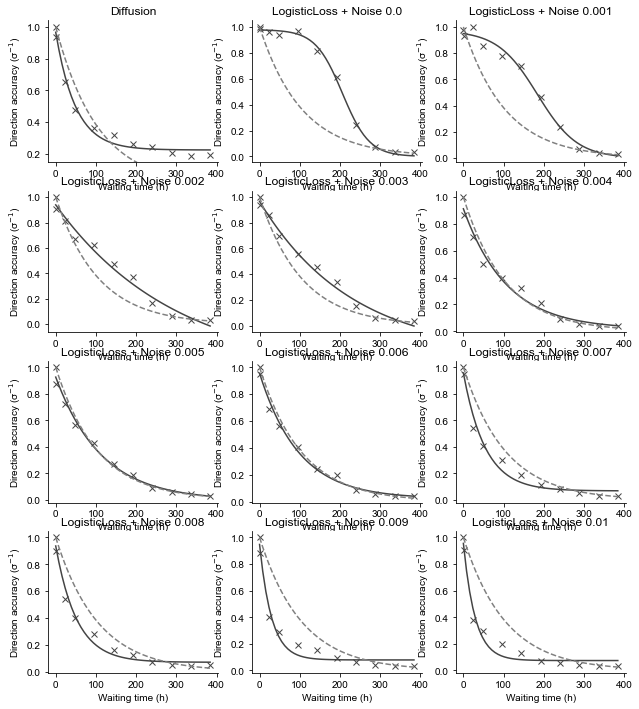

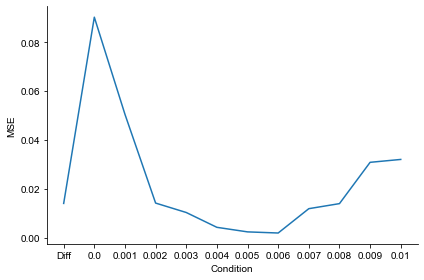

In [129]:
# Plot homing direction dispersion vs waiting time

# Plot the ant data slope
def plot_ant_homing_angle_accuracy_1_over_sigma_squared(ax, wait_t):
    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
    y_1 = np.exp(-0.23/24*x_1)
    ax.plot(x_1, y_1, '--', color='grey')

def predict_ant_homing_angle_accuracy_1_over_sigma_squared(x_1):
    y_1 = np.exp(-0.23/24*x_1)
    return y_1

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_exp, 'func_str': func_exp_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]
make_plot_func_list[1] = {'func': func_sigmoid_logistic_modified_2, 'func_str': func_sigmoid_logistic_modified_2_str, 'init_vals': None}
make_plot_func_list[2] = {'func': func_sigmoid_logistic_modified_2, 'func_str': func_sigmoid_logistic_modified_2_str, 'init_vals': None}

plot_data_analysis(measure               = "Angle_Dispersion",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 11,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = False,                  # Raise the y values to the power or 2
                   inverse               = True,                 # Plot the 1 / y of the data
                   normalise             = True,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Direction accuracy (σ$^{-1}$)', 
                   y_lim                 = [None, None],          # Do not limit the y axis range
                   #y_lim                 = [0, 15],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_angle_accuracy_sigma-1_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = predict_ant_homing_angle_accuracy_1_over_sigma_squared,            # Function for producing target y values
                   func_plot_predictions = plot_ant_homing_angle_accuracy_1_over_sigma_squared           # Function to plot the target y values
)


Noise(t)
The fitted curve parameters a * exp(-b*x) + c are: 0.04245113041879012 20.879072761505792 0.8853298926574373
R^2 = 0.2516108990881982

LogisticLoss(t) + Noise =  0.0
Exception: Issue plotting for noise = 0.0

LogisticLoss(t) + Noise =  0.001
Exception: Issue plotting for noise = 0.001

LogisticLoss(t) + Noise =  0.002
Exception: Issue plotting for noise = 0.002

LogisticLoss(t) + Noise =  0.003
Exception: Issue plotting for noise = 0.003

LogisticLoss(t) + Noise =  0.004
Exception: Issue plotting for noise = 0.004

LogisticLoss(t) + Noise =  0.005
Exception: Issue plotting for noise = 0.005

LogisticLoss(t) + Noise =  0.006
Exception: Issue plotting for noise = 0.006

LogisticLoss(t) + Noise =  0.007
Exception: Issue plotting for noise = 0.007

LogisticLoss(t) + Noise =  0.008
Exception: Issue plotting for noise = 0.008

LogisticLoss(t) + Noise =  0.009
Exception: Issue plotting for noise = 0.009

LogisticLoss(t) + Noise =  0.01
Exception: Issue plotting for noise = 0.01


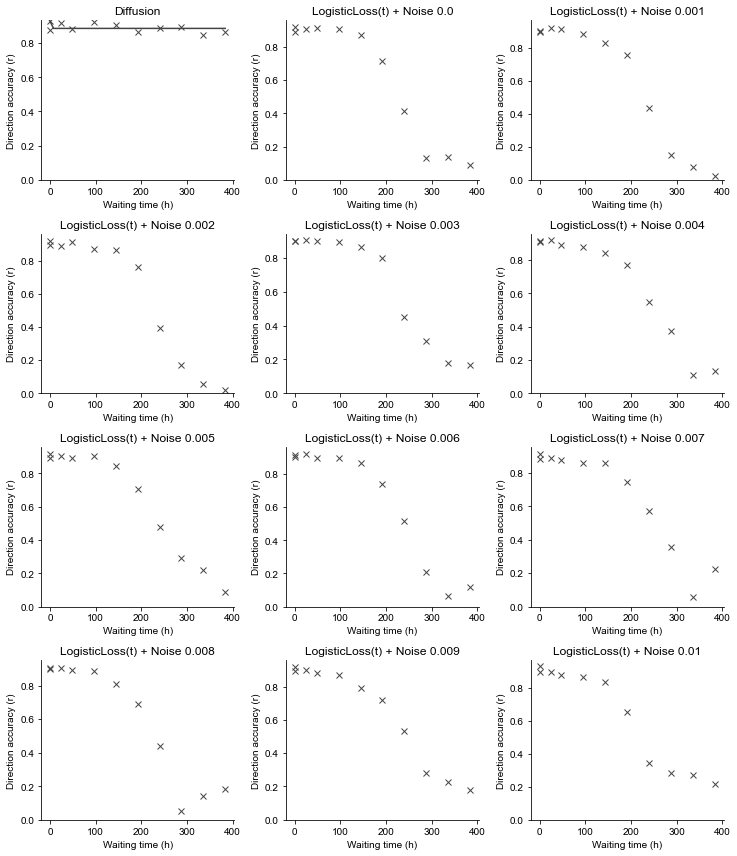

In [130]:
# Plot homing direction dispersion vs waiting time

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_exp, 'func_str': func_exp_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]

plot_data_analysis(measure               = "Mean_vector_v",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 11,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = False,                  # Raise the y values to the power or 2
                   inverse               = False,                 # Plot the 1 / y of the data
                   normalise             = False,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Direction accuracy (r)', 
                   #y_lim                 = [None, None],          # Do not limit the y axis range
                   y_lim                 = [0, None],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_angle_accuracy_r_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = None,            # Function for producing target y values
                   func_plot_predictions = None           # Function to plot the target y values
)


Noise(t)
The fitted curve parameters a * exp(-b*x) + c are: -0.044427361390339606 22.4798379980492 0.9585413791705558
R^2 = 0.23885008122856088

LogisticLoss(t) + Noise =  0.0
Exception: Issue plotting for noise = 0.0

LogisticLoss(t) + Noise =  0.001
The fitted curve parameters a * exp(-b*x) + c are: -2347.555952567122 6.474691880794199e-07 2347.472191738904
R^2 = 0.5115487984692836

LogisticLoss(t) + Noise =  0.002
Exception: Issue plotting for noise = 0.002

LogisticLoss(t) + Noise =  0.003
Exception: Issue plotting for noise = 0.003

LogisticLoss(t) + Noise =  0.004
The fitted curve parameters a * exp(-b*x) + c are: -2138.756918125196 8.261321398324595e-07 2138.762613147733
R^2 = 0.6160172070328087

LogisticLoss(t) + Noise =  0.005
The fitted curve parameters a * exp(-b*x) + c are: -1645.7172444355303 9.208676765002277e-07 1645.7117808688529
R^2 = 0.5908702089768374

LogisticLoss(t) + Noise =  0.006
Exception: Issue plotting for noise = 0.006

LogisticLoss(t) + Noise =  0.007
The f

/Users/john/miniconda3/envs/brian2/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


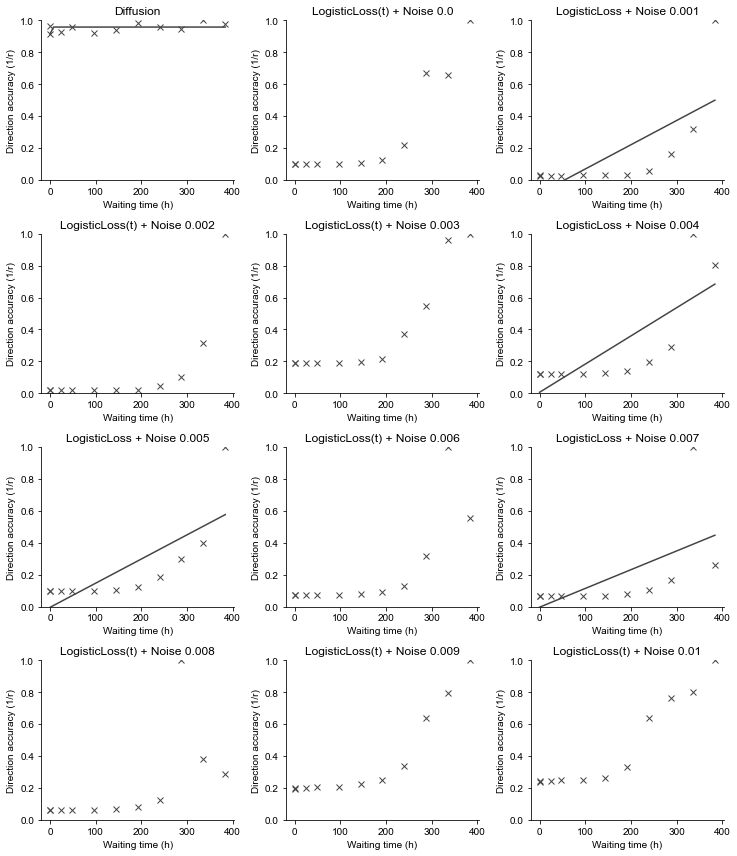

In [131]:
# Plot homing direction dispersion vs waiting time

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01] # The added noise SD

# Create list of dicts specifying the regression function to use for make_plot functions
make_plot_func_list = [{'func': func_exp, 'func_str': func_exp_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]

plot_data_analysis(measure               = "Mean_vector_v",     # Dict key of measure data points to use 
                   wait_noise_sd_values  = wait_noise_sd_values, 
                   slice_t_max           = 11,                     # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                   squared               = False,                  # Raise the y values to the power or 2
                   inverse               = True,                 # Plot the 1 / y of the data
                   normalise             = True,                 # Normalise data by plotting the y/max(y)
                   y_label               = 'Direction accuracy (1/r)', 
                   #y_lim                 = [None, None],          # Do not limit the y axis range
                   y_lim                 = [0, 1],               # Limit the y axis to this range
                   make_plot_func_list   = make_plot_func_list,   # list of dicts specifying the regression function to use for make_plot functions
                   # common_figure       = None,                  # Plot each plot in a separate figure
                   common_figure         = {'cols': 3},           # Plot all plots in one figure
                   file_spec_str         = 'homing_angle_accuracy_vs_waiting_time', # Filename substring to use in the saved figures
                   func_predict          = None,            # Function for producing target y values
                   func_plot_predictions = None           # Function to plot the target y values
)


The fitted curve parameters exp(b*x)+c are: -0.5329518489127709 0.00739715601212961
R^2 = 0.9999470784313123


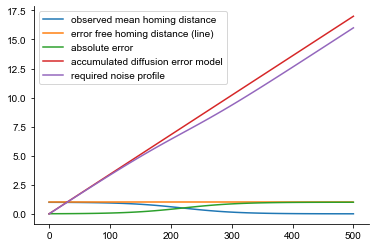

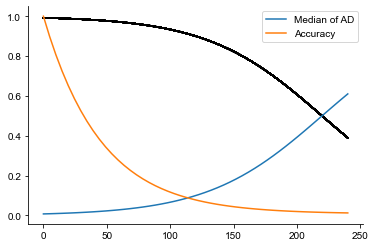

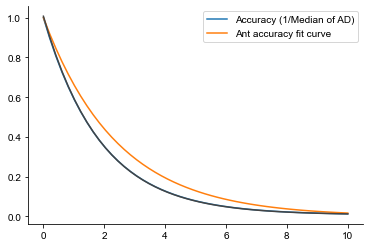

In [163]:
def reduce_pop_loss(time_in_hours):
    # The logistic reduction
    # Fitted parameters from ants homing distance
    a = 1.0
    k = 0.00784362457
    r = 0.0220667871
    y = a / (1 + k * np.exp((r * time_in_hours)))
    return y

def reduce_pop_loss_and_noise(time_in_hours, base_sd=0.0055):
    # The logistic reduction
    # Fitted parameters from ants homing distance
    a = 1.0
    k = 0.00784362457
    r = 0.0220667871
    y = a / (1 + k * np.exp((r * time_in_hours)))
    # The noise
    sd = np.sqrt(time_in_hours*60*60) * base_sd / 128
    noise = np.random.normal(loc=0.0, scale=sd, size=x.shape)
    out = np.clip(y + noise, 0, 1)
    out = y + noise
    return out

def func_exp1(x, b, c):
    return np.exp(b*x) + c


# Estimate required noise profile for producing the ants MAD
x = np.linspace(0, 500)
y = reduce_pop_loss(x)
fig = plt.figure()
plt.plot(x, y, label='observed mean homing distance')
y_1 = np.ones(x.shape)
plt.plot(x, y_1, label='error free homing distance (line)')
e_y_1 = y_1 - y
plt.plot(x, e_y_1, label='absolute error')

y_034 = 0.034 * x + 0
plt.plot(x, y_034, label='accumulated diffusion error model')

n_034 = y_034 - e_y_1
plt.plot(x, n_034, label='required noise profile')
plt.legend()


# Look into time series progression of logistic decay plus noise level
fig = plt.figure()
x = np.linspace(0, 240) # Time in hours
out = [] # Store trials
# Collect trials
for i in range(100): # 100 trials
    y = reduce_pop_loss_and_noise(x, base_sd=0.0) # Model of memory decay with given noise
    plt.plot(x, y, color='black') # Plot the progressions
    out.append(y)
MADout = np.median(np.abs(np.array(out)-1.0), axis=0) # Calculate MAD
plt.plot(x, MADout, label='Median of AD') # Plot MAD
acc = 1/(MADout) # Homing distance accuracy
acc = acc / np.max(acc) # Normalise to 0-1
plt.plot(x, acc, label='Accuracy') # Plot accuracy
#plt.plot(x, np.exp(-.41*x), label='Ant accuracy') # Plot the ants homing accuracy
plt.legend()

# Compare the expontial drop in accuracy of the ants and the model
fig, ax = plt.subplots(1, 1)
x = x/24 # Ant data are in days
ax.plot(x, acc, label='Accuracy (1/Median of AD)')
ax.plot(x, np.exp(-.41*x), label='Ant accuracy fit curve')
fit_data_points(ax, x, acc, func_exp1, func_str='exp(b*x)+c', init_vals=[-0.41, 0], color='#444444')
ax.legend()

By applying only stochastic diffusion noise and not memory loss the angular error increases faster than the distance error which is in constrast to the Zieler1997 findings. 

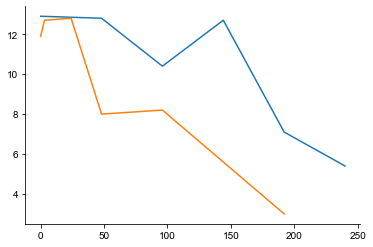

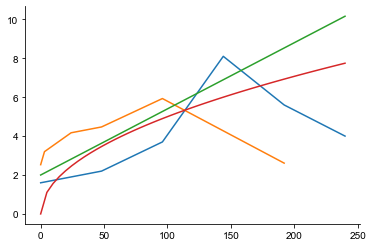

In [15]:
# Data from paper
str_Ziegler1997 = 'Ziegler et al. (1997)'
str_Ziegler1997 = 'Ziegler et al.'
Z_DaysInCaptivity = np.array([0, 2, 4, 6, 8, 10])
Z_HoursInCaptivity = Z_DaysInCaptivity * 24
Z_Homing_Distance_Median_12m=np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
Z_Homing_Distance_MAD_12m=np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m=np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])

# Data from paper
str_Cheng2005 = 'Cheng et al. (2005)'
str_Cheng2005 = 'Cheng et al.'
C_HoursInCaptivity = np.array([0, 3, 24, 48, 96, 192])
C_Homing_Distance_Median_12m=np.array([11.9, 12.7, 12.8, 8.0, 8.2, 3.0])
C_Homing_Distance_SD_12m=np.array([2.53, 3.20, 4.17, 4.47, 5.93, 2.61])
C_Homing_Distance_CV_12m=np.array([0.21, 0.26, 0.34, 0.54, 0.64, 0.89])
C_Homing_Distance_Median_6m=np.array([6.6, 6.6, 6.6, 6.5, 8.4, 1.1])
C_Homing_Distance_CV_6m=np.array([0.38, 0.28, 0.62, 0.55, 0.64, 1.41])

fig = plt.figure()
x = np.linspace(0, 240)
plt.plot(Z_DaysInCaptivity*24, Z_Homing_Distance_Median_12m)
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_12m)

fig = plt.figure()
plt.plot(Z_DaysInCaptivity*24, Z_Homing_Distance_MAD_12m)
plt.plot(C_HoursInCaptivity, C_Homing_Distance_SD_12m)
plt.plot(x, 0.034*x+2)
plt.plot(x, 0.5*np.sqrt(x))

## Plot the collected ant trajectories (DGPS recordings)

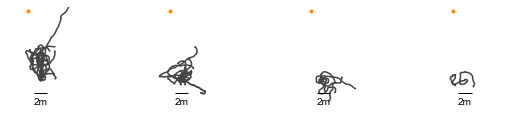

In [2]:
# This plots the whole DGPS trajectories without rediscritisation
show_labels = False
show_axis = False

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full, column_full/5))

# Calculate actual position of the nest
nest_distance     = 10.5 # m
nest_heading_deg  = 100  # degrees
nest_heading_rads = np.radians(nest_heading_deg)
nest_x = nest_distance * np.cos(nest_heading_rads)
nest_y = nest_distance * np.sin(nest_heading_rads)

# Creat lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob('../Ant_Cooling_Data/Converted_to_CSV/*' + condition + '*.csv')

# Plot only the DGPS recordings
recording_method_i = 1

# Plot the trajectories
for idx_i,condition in enumerate(conditions):
    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs

    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # If recording method is camera plot the grey circle
    if recording_method == 'fps':
        circ = plt.Circle((0, 0), 0.2, edgecolor='r', facecolor='#CCCCCC', linewidth=1.5, alpha=0.8)
        ax.add_patch(circ)
    else:
        pass
    
    # Plot the data in each of the filtered files
    for i,file in enumerate(filtered_files_list):
        pd_i = pd.read_csv(file)
        ax.plot(pd_i["x"], pd_i["y"], color='#444444', alpha=1)
    ax.axis('scaled')
    
    if recording_method == 'fps':
        ax.set_xlim([-0.25, 0.25])
        ax.set_ylim([-0.25, 0.25])
        draw_sizebar(ax, size=0.1, label='10cm', location='lower center')
    else:
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 11])
        
        if condition == 'treeFV':
            ax.set_xlim([-5, 5])
            ax.set_ylim([-1, 12])
        
        draw_sizebar(ax, size=2.0, label='2m', location='lower center')
    
    # Plot the nest location
    ax.plot(nest_x, nest_y, '.', color='darkorange')
    
    # Beautify the axes
    if show_axis:
        adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-5, 5]), y_values=np.array([-5, 10]), margin=1)
    else:
        ax.set_axis_off()
    
    if show_labels:
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_title(condition)
    
    ax.set_aspect('equal')
    ax.grid(color="0.9", linestyle='-', linewidth=1)

if save_figures:
    fig.savefig(images_path + 'ants_fullRelease_' + 'routes' + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0

## Plot the collected ant trajectories on the platform (camera recordings) with coloured depiction of time

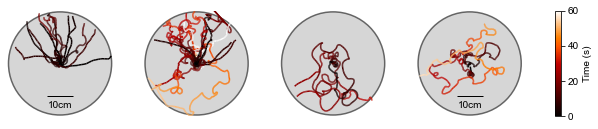

In [3]:
# Colour lines by time

show_labels = False
show_axis = False

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

colormap='gist_heat'

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=False, figsize=(column_full/4*len(conditions)+2, column_full/5))

# Creat lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Plot only the camera recordings
recording_method_i = 0

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):

    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs
    
    circ = plt.Circle((0, 0), 0.2, edgecolor='#444444', facecolor='#CCCCCC', linewidth=1.5, alpha=0.8)
    ax.add_patch(circ)
    
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]

        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        # Create a continuous norm to map from data points to colors
        #norm = plt.Normalize(t.min(), t.max())
        # Sets the range of the t (colorbar) range
        norm = plt.Normalize(0, 60)
        lc = LineCollection(segments, cmap=colormap, norm=norm)
        # Set the values used for colormapping
        lc.set_array(t)

        line = ax.add_collection(lc)

    ax.set_aspect('equal')
    ax.set_xlim([-0.205, 0.205])
    ax.set_ylim([-0.205, 0.205])
    
    if show_axis:
        if idx_i == 0:
            adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-0.2, 0.2]), y_values=np.array([-0.2, 0.2]), margin=1)
        else: 
            adjust_spines(ax, ['bottom'], x_values=np.array([-0.2, 0.2]), margin=1)
            ax.set_yticks([])
    else:
        ax.set_axis_off()
        if idx_i == 0 or idx_i == 3:
            draw_sizebar(ax, size=0.1, label='10cm', location='lower center')    
    
    if show_labels:
        ax.set_title(condition)
    
cbar = fig.colorbar(line, ax=axs_row.ravel().tolist())
cbar.ax.set_ylabel('Time (s)')

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'routes_time_coloured' + save_figures_as_filetype, bbox_inches='tight', transparent=True)

Conditions: 
 FVNoIce  FVIce  ZVNoIce  ZVIce 
FVNoIce: n=2752 FVIce: n=15961 ZVNoIce: n=1975 ZVIce: n=3023 

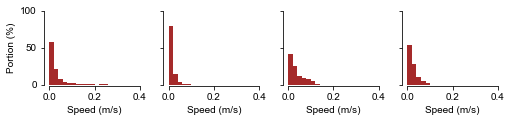

In [4]:
# Speed histograms on platform (r=20cm)
show_labels = False

conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

colour2 = 'brown'

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_210mm/4*len(conditions), column_210mm/6))

# Creat lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Use the camera recordings
recording_method_i = 0

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):
    
    v_set = np.array([])
    
    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs
    
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]

        dx = np.diff(x)
        dy = np.diff(y)
        dh = np.hypot(dx, dy)
        dt = np.diff(t)
        
        v = dh / dt        
        v_set = np.append(v_set, v)
    
    weights = np.ones_like(v_set) / float(len(v_set)) * 100
    n, bins, _ = ax.hist(v_set, bins=20, range=[0,0.4], weights=weights, color=colour2) 
    
    print(condition + ': n=' + str(len(v_set)), end=' ')
    
    adjust_spines(ax, ['left', 'bottom'], x_values=np.array([0.0, 0.4]), y_values=np.array([0.0, 100]), margin=1)
    
    ax.set_ylim([0, 0.4])
    ax.set_ylim([0, 100])
    
    if idx_i == 0:
        ax.set_ylabel("Portion (%)")
    ax.set_xlabel("Speed (m/s)")

    if show_labels:
        ax.set_title(condition)    

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'speed_histograms' + save_figures_as_filetype, bbox_inches='tight', transparent=True)
    

Conditions: 
 FVNoIce  FVIce  ZVNoIce  ZVIce 
FVNoIce: n=13
FVIce: n=16
ZVNoIce: n=3
ZVIce: n=3


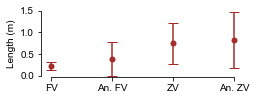

In [5]:
# Length of paths on the platform (r=20cm)

show_labels = False

conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

# Plot styling 
markersize=5
capsize=5

colour2 = 'brown'

condition_label = {
    'FVNoIce' : 'FV', 
    'FVIce'   : 'An. FV', 
    'ZVNoIce' : 'ZV', 
    'ZVIce'   : 'An. ZV'
}

def conditionsToLabels(lst):
    """ Gets a list of strings and returns a list of 
        the corresponding labels for printing """
    if not isinstance(lst, list):
        lst = [lst]
    return [condition_label[item] for item in lst]
    

fig = plt.figure(figsize=(column_double/2, column_double/3/2))
ax = plt.gca()

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Use the camera recordings
recording_method_i = 0

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Create dictionary to store the path lengths
traj_lengths = {}
traj_lengths['condition'] = []
traj_lengths['median'] = []
traj_lengths['sd'] = []

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):

    lengths_set = np.array([])
    
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]
        
        # Find the first crossing of the 20cm radius
        h = np.hypot(x, y)
        indx_k = np.argmin(np.abs(h - 0.20))
        indx_k = min(indx_k+1, len(h))
        
        dx = np.diff(x[:indx_k])
        dy = np.diff(y[:indx_k])
        dh = np.hypot(dx, dy)
        length = np.sum(dh)
        lengths_set = np.append(lengths_set, length)

    traj_lengths['condition'].append(condition)
    traj_lengths['median'].append(np.median(lengths_set))
    traj_lengths['sd'].append(np.std(lengths_set))
    # Also store the individual path lengths samples for statistical significance calculation
    traj_lengths[condition] = lengths_set
    
    print(condition + ': n=' + str(len(lengths_set)))
    
ax.errorbar(x=np.arange(len(conditions))+1, y=traj_lengths['median'], yerr=traj_lengths['sd'], fmt='o', color=colour2, markersize=markersize, capsize=capsize)
ax.set_ylabel('Length (m)');
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
ax.set_ylim([0, 1.5]);

adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 1.5]), margin=1)

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'path_lengths' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## Plot the mean vectors of the trajectories


fps
           FVNoIce    FVIce    ZVNoIce    ZVIce   
Mean th (^o)    96.754   105.182   248.680   142.244
Mean theta     1.689     1.836     4.340     2.483
 SD theta      0.947     1.249     1.316     1.371
  Mean r       0.551     0.219     0.134     0.061

Circular uniformity test

              FVNoIce      FVIce      ZVNoIce      ZVIce    
   V test      0.000       0.000       0.912       0.326    
 V test(n)     13.000      16.000      3.000       3.000    


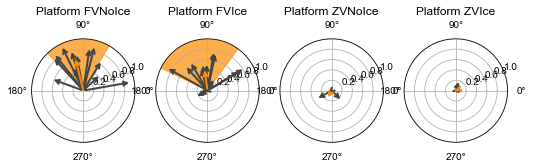

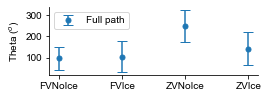

In [14]:
# Polar plots and heading angles

# Style the polar plots
arrowprops_mean_arrow = dict(color='#444444', linewidth=2, alpha=1.0)
arrowprops_all_arrow = dict(color='darkorange', linewidth=2, alpha=1.0)
arrowprops_all_arrow_2 = dict(color='darkorange', linewidth=2, alpha=1.0)
arrowprops_all_sector_2 = dict(color='darkorange', alpha=0.7)

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}
recording_methods_names = ['Full path', 'First 20cm']
sampling_interval_step = 0.001

recording_method_i = 0

circ_stats_dic = {}

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob('../Ant_Cooling_Data/Converted_to_CSV_rediscretisised/*' + condition + '*.csv')

fig, axs = plt.subplots(1, len(conditions), figsize=(column_full/1.14, column_full/1.14/1.5/2), subplot_kw=dict(polar=True))
fig2, axs2_ = plt.subplots(1, 1, figsize=(column_full/2/1.3, column_full/2/1.3/3)); axs2 = [axs2_, axs2_];

data_thetas = {}
data_mean_thetas = {}
for recording_method_i in range(0,1):
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    circ_stats_dic[recording_method] = {}
    #circ_stats_dic2[recording_method] = {}
    data_thetas[recording_method] = {}
    data_mean_thetas[recording_method] = {}
    for plt_i,condition in enumerate(conditions):
        circ_stats_dic[recording_method][condition] = {}
        #circ_stats_dic2[recording_method][condition] = {}
        ax = axs[plt_i]
        # Get the sublist of filenames with the desired recording method string
        filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
        # Get the sublist of filenames with the desired rediscritization length
        filtered_files_list = [string for string in filtered_files_list if str(sampling_interval_step).replace('.', '_') in string]
        dx_array = np.array([])
        dy_array = np.array([])
        vector_r_mean_array     = np.array([])
        vector_theta_mean_array = np.array([])
        
        # Plot the data in each of the filtered files
        for file in filtered_files_list:
            pd_i = pd.read_csv(file)
            dx = np.diff(pd_i["x"])
            dy = np.diff(pd_i["y"])
            theta = np.arctan2(dy, dx) # The angle of the vector
            theta[theta<0] += 2*np.pi # Convert all angles to be only positive 0 to 2*pi
            r = np.sqrt(dx**2 + dy**2) # The length of the vector
            # Some redundant calculations used to check if all methods use the same results
            theta_mean = scipy.stats.circmean(theta) ####
            r_mean = circ_r_xy(dx, dy)
            r_mean = circ_r_alpha(theta)
            dx_array = np.append(dx_array, dx)
            dy_array = np.append(dy_array, dy)
            vector_r_mean_array     = np.append(vector_r_mean_array, r_mean)
            vector_theta_mean_array = np.append(vector_theta_mean_array, theta_mean) ####
            
            # Plot one vectors per trajectory
            compass([r_mean*np.cos(theta_mean)], [r_mean*np.sin(theta_mean)], ax, arrowprops=arrowprops_mean_arrow)
        
        theta_array = np.arctan2(dy_array, dx_array) ####
        theta_array[theta_array<0] += 2*np.pi
        data_thetas[recording_method][condition] = theta_array
        data_mean_thetas[recording_method][condition] = vector_theta_mean_array
        r_array = np.sqrt(dx_array**2 + dy_array**2)
        theta_mean_array = scipy.stats.circmean(theta_array) ####
        theta_std_array = scipy.stats.circstd(theta_array)
        theta_std_array = astropy.stats.circstats.circstd(theta_array)
        r_mean_array = circ_r_xy(dx_array, dy_array)
        r_mean_array = circ_r_alpha(theta_array)
        
        vector_x_mean = np.median(vector_r_mean_array*np.cos(vector_theta_mean_array))
        vector_y_mean = np.median(vector_r_mean_array*np.sin(vector_theta_mean_array))
        vector_angle_mean = scipy.stats.circmean(vector_theta_mean_array) ####
        vector_angle_std = scipy.stats.circstd(vector_theta_mean_array)
        vector_angle_std = astropy.stats.circstats.circstd(vector_theta_mean_array)
        
        compass([vector_x_mean], [vector_y_mean], ax, arrowprops=arrowprops_all_arrow_2)
        # Plot the orange sector
        if condition in ['FVNoIce', 'FVIce']:
            compass_sector_pol(vector_angle_mean-vector_angle_std, vector_angle_mean+vector_angle_std, 1.0, ax, sectorprops=arrowprops_all_sector_2)
        
        ax.set_rmax(1) # Sets the radius of the plot
        ax.set_xticks(np.pi/180. * np.linspace(0,  360, 4, endpoint=False))
        
        if recording_method_i == 0:
            ax.set_title("Platform " + condition)
        else:
            ax.set_title("Long range " + condition)
        circ_stats_dic[recording_method][condition]["theta_mean"] = theta_mean_array
        circ_stats_dic[recording_method][condition]["theta_std"] = theta_std_array
        circ_stats_dic[recording_method][condition]["r_mean"] = r_mean_array
        
    # Print the stats
    theta_mean_list = ['Mean theta']
    theta_mean_deg_list = ['Mean th (^o)']
    theta_std_list = ['SD theta']
    r_mean_list = ['Mean r']
    header_format_placeholder = '{:^10s}' * (len(conditions)+1)
    row_format_placeholder = '{:^10s}' + '{:10.3f}' * len(conditions)
    print()
    print(recording_method)
    print(header_format_placeholder.format(*([''] + conditions)))
    for plt_i,condition in enumerate(conditions):
        theta_mean_list.append(circ_stats_dic[recording_method][condition]["theta_mean"])
        theta_mean_deg_list.append(np.degrees(circ_stats_dic[recording_method][condition]["theta_mean"]))
        theta_std_list.append(circ_stats_dic[recording_method][condition]["theta_std"])
        r_mean_list.append(circ_stats_dic[recording_method][condition]["r_mean"])

    # Print the stats
    print(row_format_placeholder.format(*theta_mean_deg_list))
    print(row_format_placeholder.format(*theta_mean_list))
    print(row_format_placeholder.format(*theta_std_list))
    print(row_format_placeholder.format(*r_mean_list))

    # Plot the stats
    ax = axs2[recording_method_i]
    ax.errorbar(x=np.arange(len(conditions))+1, y=np.degrees(theta_mean_list[1:]), yerr=np.degrees(theta_std_list[1:]), fmt='o', markersize=5, capsize=5, label=recording_methods_names[recording_method_i]) # linewidth=2.5, 
    ax.set_ylabel('Theta ($^o$)');
    ax.set_xticks(np.arange(len(conditions))+1);
    ax.set_xticklabels(conditions);
    ax.legend()
    
    print('')
    print('Circular uniformity test')
    circ_stat_tests(data=data_mean_thetas[recording_method])


if save_figures:
    fig.savefig(images_path + 'ants_platformAndfullRelease_' + 'routes_polar_vectors' + save_figures_as_filetype, bbox_inches='tight', transparent=True)
    fig2.savefig(images_path + 'ants_platformAndfullRelease_' + 'mean_and_sd_theta' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## How long does it take for ants to cross the 20cm radius platform


Mann-Whitney U
              FVNoIce      FVIce      ZVNoIce      ZVIce    
  FVNoIce      0.490       0.002       0.005       0.016    
   FVIce       0.002       0.492       0.348       0.234    
  ZVNoIce      0.005       0.348       0.410       0.331    
   ZVIce       0.016       0.234       0.331       0.410    

           FVNoIce     FVIce       ZVNoIce     ZVIce      
   Mean    8.436923076923078  28.765333333333334  26.253333333333334  38.973333333333336 
    SD     5.902770385577612  21.39778862925378  3.915144385020246  19.641108816855414 



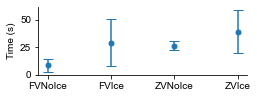

In [12]:
# Plot the time to cross the platform circumferance

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

# Which types of plots to use can be one of the two or both
plot_type = ['barplot', 'errorplot', 'dont_show_outliers'][1:]

# Use the camera recordings
recording_methods_num = 1

dict_files = {}
dict_crossing_time = {}
dict_crossing_time_stats = {}

# Creat lists of the files
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Calculate the platform radius crossing time
for condition in conditions:
    dict_crossing_time[condition] = {}
    for recording_method_i in range(0,recording_methods_num):
        # Get recording method string used in file names
        recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
        # Get the sublist of filenames with the desired recording method string
        filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
        list_of_t_measurements = []
        # Plot the data in each of the filtered files
        for file in filtered_files_list:
            pd_i = pd.read_csv(file)
            x = pd_i["x"] - pd_i["x"][0]
            y = pd_i["y"] - pd_i["y"][0]
            h = np.hypot(x, y)
            
            t = pd_i["Time"]
            #cross_t = t[np.argmax(h>0.2)] # The problem with this is that for the ants that never cross the 0.2m it returns 0s
            cross_t = t[np.argmin(np.abs(h-0.2))] # This approach returns the nearest value at the 0.2m even if they do not cross it.
            list_of_t_measurements.append(cross_t)
        dict_crossing_time[condition][recording_method] = np.array(list_of_t_measurements)

# Calculate the time stats
for condition in conditions:
    dict_crossing_time_stats[condition] = {}
    for recording_method_i in range(0,recording_methods_num):
        # Get recording method string used in file names
        recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
        data_points = dict_crossing_time[condition][recording_method]
        dict_crossing_time_stats[condition][recording_method] = {}
        dict_crossing_time_stats[condition][recording_method]['median'] = np.median(data_points)
        dict_crossing_time_stats[condition][recording_method]['std'] = np.std(data_points)

# Test statistical significance of means difference
data = {}
for recording_method_i in range(0,recording_methods_num):
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    for condition in conditions:
        data[condition] = dict_crossing_time[condition][recording_method]
    stat_tests(data=data)

# Plot the boxplot
fig, ax = plt.subplots(1, 1, figsize=(column_full/2/1.3, column_full/2/1.3/3))

# Prepare the data
for recording_method_i in range(0,recording_methods_num):
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    data_list = []
    for i, condition in enumerate(conditions):
        data_list.append(dict_crossing_time[condition][recording_method])

if 'barplot' in plot_type:
    bp = ax.boxplot(data_list, labels=conditions)
    # Set the colour of thew boxes
    for b_i, b in enumerate(bp['boxes']):
        bp["medians"][b_i].set_color('black')
    ax.set_xlabel('Condition');
    ax.set_ylabel('Time (s)');

if 'errorplot' in plot_type:
    m = []
    sd = []
    outliers = []
    for idx_i,d in enumerate(data_list):
        d_without_outliers, d_outliers = reject_outliers(d)
        m.append(np.mean(d_without_outliers))
        sd.append(np.std(d_without_outliers))
        outliers.append(d_outliers)
        if 'show_outliers' in plot_type and len(d_outliers):
            ax.scatter([idx_i+1]*len(d_outliers), d_outliers)
    ax.errorbar(x=np.arange(len(conditions))+1, y=m, yerr=sd, fmt='o', markersize=5, capsize=5)
    #ax.set_xlabel('Condition');
    ax.set_ylabel('Time (s)');
    ax.set_xticks(np.arange(len(conditions))+1);
    ax.set_xticklabels(conditions);

    print()
    print(('          ' + ' {:10} ' * len(conditions)).format(*conditions))
    print(('   Mean   ' + ' {:10} ' * len(conditions)).format(*m))
    print(('    SD    ' + ' {:10} ' * len(conditions)).format(*sd))
    print()

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'time_within_20cm' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## Plot the collected ant trajectories for the Tree release conditions

Conditions: 
 tree-FV-NoIce  tree-FV-Ice  tree-NoIce-ZV-ReRelease  tree-Ice-ZV-ReRelease 


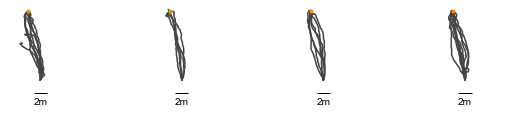

In [17]:
# This plots the whole DGPS trajectories without rediscritisation
show_labels = False
show_axis = False

# Conditions
conditions = ['tree-FV-NoIce', 'tree-FV-Ice', 'tree-NoIce-ZV-ReRelease', 'tree-Ice-ZV-ReRelease']
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full, column_full/5))

# Calculate actual position of the nest
nest_distance     = 10.5 # m
nest_heading_deg  = 100  # degrees
nest_heading_rads = np.radians(nest_heading_deg)
nest_x = nest_distance * np.cos(nest_heading_rads)
nest_y = nest_distance * np.sin(nest_heading_rads)

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob('../Ant_Cooling_Data/Converted_to_CSV/*' + condition + '*.csv')

# Use the DGPS recordings
recording_method_i = 1

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Plot the trajectories
for idx_i,condition in enumerate(conditions):
    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs

    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Get the sublist of filenames with the desired rediscritization length
    if recording_method == 'fps':
        circ = plt.Circle((0, 0), 0.2, edgecolor='r', facecolor='#CCCCCC', linewidth=1.5, alpha=0.8)
        ax.add_patch(circ)
    else:
        pass
    
    # Plot the data in each of the filtered files
    for i,file in enumerate(filtered_files_list):
        pd_i = pd.read_csv(file)
        ax.plot(pd_i["x"], pd_i["y"], color='#444444', alpha=1)
    ax.axis('scaled')
    
    if recording_method == 'fps':
        ax.set_xlim([-0.25, 0.25])
        ax.set_ylim([-0.25, 0.25])
        draw_sizebar(ax, size=0.1, label='10cm', location='lower center')
    else:
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 11])
        if condition == 'treeFV':
            ax.set_xlim([-5, 5])
            ax.set_ylim([-1, 12])
        draw_sizebar(ax, size=2.0, label='2m', location='lower center')
    
    # Plot the nest location
    ax.plot(nest_x, nest_y, '.', color='darkorange')
    
    # Beautify the axes
    if show_axis:
        adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-5, 5]), y_values=np.array([-5, 10]), margin=1)
    else:
        ax.set_axis_off()
    
    if show_labels:
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_title(condition)
    ax.set_aspect('equal')
    ax.grid(color="0.9", linestyle='-', linewidth=1)

if save_figures:
    fig.savefig(images_path + 'ants_fullRelease_' + 'atTree_' + 'routes' + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0

Conditions: 
 tree-FV-NoIce  tree-FV-Ice  tree-NoIce-ZV-ReRelease  tree-Ice-ZV-ReRelease 
tree-FV-NoIce: n=784 tree-FV-Ice: n=5334 tree-NoIce-ZV-ReRelease: n=11509 tree-Ice-ZV-ReRelease: n=11611 

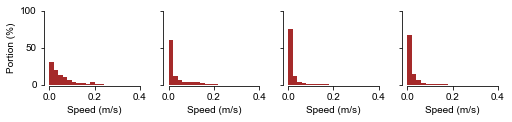

In [18]:
# Speed histogram on platform for the Tree release conditions (r=20cm)

show_labels = False

# Conditions
conditions = ['tree-FV-NoIce', 'tree-FV-Ice', 'tree-NoIce-ZV-ReRelease', 'tree-Ice-ZV-ReRelease']
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

colour2 = 'brown'

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_210mm/4*len(conditions), column_210mm/6))

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Use the camera recordings
recording_method_i = 0

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):
    
    v_set = np.array([])
    
    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs
    
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]

        dx = np.diff(x)
        dy = np.diff(y)
        dh = np.hypot(dx, dy)
        dt = np.diff(t)
        
        v = dh / dt        
        v_set = np.append(v_set, v)
    
    weights = np.ones_like(v_set) / float(len(v_set)) * 100
    n, bins, _ = ax.hist(v_set, bins=20, range=[0,0.4], weights=weights, color=colour2) 
    #print(len(n), bins)
    
    print(condition + ': n=' + str(len(v_set)), end=' ')
    
    adjust_spines(ax, ['left', 'bottom'], x_values=np.array([0.0, 0.4]), y_values=np.array([0.0, 100]), margin=1)
    
    ax.set_ylim([0, 0.4])
    ax.set_ylim([0, 100])
    
    if idx_i == 0:
        ax.set_ylabel("Portion (%)")
    ax.set_xlabel("Speed (m/s)")

    if show_labels:
        ax.set_title(condition)    

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'atTree_' + 'speed_histograms' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


Conditions: 
 tree-FV-NoIce  tree-FV-Ice  tree-NoIce-ZV-ReRelease  tree-Ice-ZV-ReRelease 
tree-FV-NoIce: n=8
tree-FV-Ice: n=7
tree-NoIce-ZV-ReRelease: n=6
tree-Ice-ZV-ReRelease: n=9


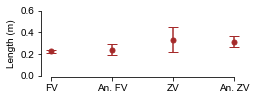

In [19]:
# Path length on platform for Tree releases(r=20cm)

show_labels = False

# Conditions
conditions = ['tree-FV-NoIce', 'tree-FV-Ice', 'tree-NoIce-ZV-ReRelease', 'tree-Ice-ZV-ReRelease']
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

# Plot styling
markersize=5
capsize=5

colour2 = 'brown'

condition_label = {
    'FVNoIce' : 'FV', 
    'FVIce'   : 'An. FV', 
    'ZVNoIce' : 'ZV', 
    'ZVIce'   : 'An. ZV',
    'tree-FV-NoIce'           : 'FV',
    'tree-FV-Ice'             : 'An. FV', 
    'tree-NoIce-ZV-ReRelease' : 'ZV', 
    'tree-Ice-ZV-ReRelease'   : 'An. ZV'
}

def conditionsToLabels(lst):
    """ Gets a list of strings and returns a list of 
    the corresponding labels for printing """
    if not isinstance(lst, list):
        lst = [lst]
    return [condition_label[item] for item in lst]
    

fig = plt.figure(figsize=(column_double/2, column_double/3/2))
ax = plt.gca()

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# use the camera recordings
recording_method_i = 0

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Dictionary for storing the path lengths
traj_lengths = {}
traj_lengths['condition'] = []
traj_lengths['median'] = []
traj_lengths['sd'] = []

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):

    lengths_set = np.array([])    

    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]
        
        # Find the first crossing of the 20cm radius
        h = np.hypot(x, y)
        indx_k = np.argmin(np.abs(h - 0.20))
        indx_k = min(indx_k+1, len(h))
        
        dx = np.diff(x[:indx_k])
        dy = np.diff(y[:indx_k])
        dh = np.hypot(dx, dy)
        length = np.sum(dh)
        lengths_set = np.append(lengths_set, length)

    traj_lengths['condition'].append(condition)
    traj_lengths['median'].append(np.median(lengths_set))
    traj_lengths['sd'].append(np.std(lengths_set))
    
    # Also store the individual path lengths samples for statistical significance calculation
    traj_lengths[condition] = lengths_set
    
    print(condition + ': n=' + str(len(lengths_set)))
    
ax.errorbar(x=np.arange(len(conditions))+1, y=traj_lengths['median'], yerr=traj_lengths['sd'], fmt='o', color=colour2, markersize=markersize, capsize=capsize)
ax.set_ylabel('Length (m)');
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
ax.set_ylim([0,0.6]);
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0.0, 0.6]), margin=1)

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'atTree_' + 'path_lengths' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## Plot trajectories of simulated agents

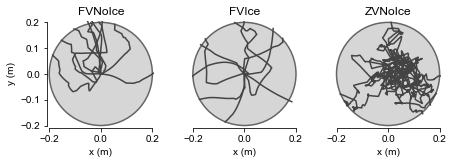

In [22]:
# Plots the simulated agents paths within the first 20cm for all conditions
path = 'Simulation/path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce']
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

# Use the within 20cm recordings
recording_method_i = 0

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=False, figsize=(column_full/4*len(conditions), column_full/5))

# Plot the trajectories of simulated agent
# ----------------------------------------
# Plot the simulated trajectories
for idx_i,condition in enumerate(conditions):
    ax = axs[idx_i]
    axs_row = axs

    circ = plt.Circle((0, 0), 0.2, edgecolor='#444444', facecolor='#CCCCCC', linewidth=1.5, alpha=0.8)
    ax.add_patch(circ)
    
    start = 1015
    num = 10
    noise_syn=0.1
    noise_rot = 7.0
    noiseSlope = 9.0
    sampling_rate = 25
    plot_npz_or_csv = 'csv' # 'npz' or 'csv' which files to use original or preprocessed
    condition_sim = condition
    if condition_sim == 'FVNoIce':
        condition_sim = 'FV'
    if condition_sim == 'ZVNoIce':
        condition_sim = 'FVIce=0.5'
    if condition_sim == 'FVIce':
        condition_sim = 'FVIce-0.35'
    for i in range(start, start+num):
        filename = path + condition_sim + '/with_Pontin_Holonomic_noiseSyn' + str(noise_syn) + '_noiseRot' + str(noise_rot) + '_noiseSlope' + str(noiseSlope) + '_route_' + condition_sim + '_' + str(i) + '.npz'

        # If we are using the already processed files (data/Converted_to_CSV/)
        if plot_npz_or_csv == 'csv':
            # Load instead the csv converted files that have only the first portion of the routes until they cross the 20cm radius
            filename_csv = filename.replace('.npz', '_platformReleases.csv')

            # Plot the already converted to csv files cut off at 20cm radius from release point in red
            pd_i = pd.read_csv(filename_csv)
            x = pd_i["x"]
            y = pd_i["y"]
            t = pd_i["Time"]
            ax.plot(x, y, color='#444444', alpha=1.0)
    
    ax.set_aspect('equal')
    ax.set_xlim([-0.205, 0.205])
    ax.set_ylim([-0.205, 0.205])
    
    # Style the plots
    if idx_i == 0:
        adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-0.2, 0.2]), y_values=np.array([-0.2, 0.2]), margin=1)
    else: 
        adjust_spines(ax, ['bottom'], x_values=np.array([-0.2, 0.2]), margin=1)
        ax.set_yticks([])
    
    ax.set_xlabel("x (m)")
    if idx_i == 0:
        ax.set_ylabel("y (m)")
    ax.set_title(condition)

if save_figures:
    fig.savefig(images_path + 'simulated_platformRelease_' + 'routes' + save_figures_as_filetype, bbox_inches='tight', transparent=True)

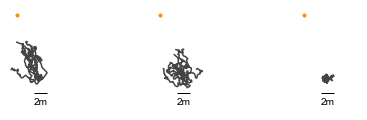

In [23]:
# Plots the full trajectories of simulated agents for all conditions

path = 'Simulation/path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'

show_labels = False
show_axis = False

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce']

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=False, figsize=(column_full/4*len(conditions), column_full/5))

# Calculate actual position of the nest
nest_distance     = 10.5 # m
nest_heading_deg  = 110 # degrees
nest_heading_rads = np.radians(nest_heading_deg)
nest_x = nest_distance * np.cos(nest_heading_rads)
nest_y = nest_distance * np.sin(nest_heading_rads)

# Plot the trajectories of simulated agent
# ----------------------------------------
# Plot the simulated trajectories
for idx_i,condition in enumerate(conditions):
    ax = axs[idx_i]
    axs_row = axs

    start = 1010
    num = 10
    noise_syn=0.1
    noise_rot = 7.0
    noiseSlope = 9.0
    sampling_rate = 25
    plot_npz_or_csv = 'csv' # 'npz' or 'csv' which files to use original or preprocessed
    condition_sim = condition
    if condition_sim == 'FVNoIce':
        condition_sim = 'FV'
    if condition_sim == 'ZVNoIce':
        condition_sim = 'FVIce=0.5'
        condition_sim = 'ZV'
    if condition_sim == 'FVIce':
        condition_sim = 'FVIcex0.85'
    for i in range(start, start+num):
        filename = path + condition_sim + '/with_Pontin_Holonomic_noiseSyn' + str(noise_syn) + '_noiseRot' + str(noise_rot) + '_noiseSlope' + str(noiseSlope) + '_route_' + condition_sim + '_' + str(i) + '.npz'
        
        # If we use the already processed files (data/Converted_to_CSV/)
        if plot_npz_or_csv == 'csv':
            filename_csv = filename.replace('.npz', '.csv')            
            pd_i = pd.read_csv(filename_csv)
            x = pd_i["x"]
            y = pd_i["y"]
            x = x * 3
            y = y * 3
            ax.plot(x, y, color='#444444', alpha=1.0)
    
    ax.axis('scaled')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 11])
    draw_sizebar(ax, size=2.0, label='2m', location='lower center')
    
    # Plot the nest location
    ax.plot(nest_x, nest_y, '.', color='darkorange')

    # Beautify the axes
    if show_axis:
        adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-5, 5]), y_values=np.array([-5, 10]), margin=1)
    else:
        ax.set_axis_off()
    
    if show_labels:
        ax.set_xlabel("x (m)")
        if idx_i == 0:
            ax.set_ylabel("y (m)")
    
    if show_labels:
        ax.set_title(condition)

    ax.set_aspect('equal')
    ax.grid(color="0.9", linestyle='-', linewidth=1)

if save_figures:
    fig.savefig(images_path + 'simulated_fullRelease_' + 'routes' + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0

## Print and plot the path characteristic measures for the ant paths


Recording method: camera , Sampling intervals (m): 0.02 , File: stats_fps_step0.020m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.057902,0.004360,15.906937,8.475682,0.318139,0.037685,0.009488,0.677025,0.054162,10.856112,21.5,0.024662,0.559584,1.0,0.038237,19.767604,5.820340,5.772392,0.690276,0.687513
FVNoIce,0.063823,0.005242,14.168330,8.721148,0.283367,0.116940,0.026905,0.829444,0.066356,10.850800,7.0,0.055583,NaN,NaN,0.047577,13.272741,3.927758,3.763897,0.866013,0.839456
ZVIce,0.053535,0.003668,1.474639,14.366930,0.029493,0.002996,0.015209,0.569840,0.045587,10.906646,34.0,0.026417,NaN,NaN,0.021738,11.615593,7.389782,7.351989,0.180268,0.585290
ZVNoIce,0.054714,0.003840,1.837826,13.164320,0.036757,-0.003062,0.025423,0.600595,0.048048,10.942387,31.0,0.038238,NaN,NaN,0.028028,11.771789,7.026914,7.048168,0.357045,0.613055


Emax_b
--------------------------------------------------------------------------------
stats_fps_step0.020m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median      0.295257465729703     0.0268466040291783    0.0253730461967362    0.0272578229438287  
SD         0.23582902963980523   0.15973204957610238   0.021587664509003856  0.012407302415902953 

Recording method: DGPS , Sampling intervals (m): 0.1 , File: stats_gps_step0.100m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.334634,0.142843,16.996661,5.379035,1.699666,0.054344,0.311749,0.907829,0.363131,9.756321,24.5,1.240450,NaN,NaN,0.665852,3.131616,1.319593,1.070339,0.516317,0.929083
FVNoIce,0.345872,0.152355,32.298259,10.041187,3.229826,0.153211,0.645171,0.960678,0.384271,7.566437,8.5,1.542917,NaN,NaN,0.593714,1.987354,0.861351,0.572549,0.577596,0.963722
ZVIce,0.337387,0.144941,12.024977,6.236122,1.202498,-0.011027,0.286701,0.921620,0.368648,9.927593,39.5,1.147006,NaN,NaN,0.479702,2.538210,1.274314,0.994367,0.255351,0.925009
ZVNoIce,0.338625,0.146112,16.533296,8.280490,1.653330,-0.014533,0.496676,0.927000,0.370800,10.488474,35.5,1.466552,0.871364,12.0,0.520574,2.063284,1.190124,0.915084,0.451625,0.929925


Emax_b
--------------------------------------------------------------------------------
stats_gps_step0.100m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median       3.15302582218356      1.03176102312622     1.6275036432144399     1.20249773396948   
SD          1.4325383352300423   0.44875311086868297    0.7144758119095183   0.18637133480715007  

Statistical significance of two sample means of path lengths:

Mann-Whitney U
              FVNoIce      FVIce      ZVNoIce      ZVIce    
  FVNoIce      0.492       0.002       0.012       0.040    
   FVIce       0.002       0.492       0.219       0.472    
  ZVNoIce      0.012       0.219       0.468       0.202    
   ZVIce       0.040       0.472       0.202       0.333    

Recording method: camera , Sampling intervals (m): 0.02 , File: stats_fps_step0.020m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.057902,0.004360,15.906937,8.475682,0.318139,0.037685,0.009488,0.677025,0.054162,10.856112,21.5,0.024662,0.559584,1.0,0.038237,19.767604,5.820340,5.772392,0.690276,0.687513
FVNoIce,0.063823,0.005242,14.168330,8.721148,0.283367,0.116940,0.026905,0.829444,0.066356,10.850800,7.0,0.055583,NaN,NaN,0.047577,13.272741,3.927758,3.763897,0.866013,0.839456
ZVIce,0.053535,0.003668,1.474639,14.366930,0.029493,0.002996,0.015209,0.569840,0.045587,10.906646,34.0,0.026417,NaN,NaN,0.021738,11.615593,7.389782,7.351989,0.180268,0.585290
ZVNoIce,0.054714,0.003840,1.837826,13.164320,0.036757,-0.003062,0.025423,0.600595,0.048048,10.942387,31.0,0.038238,NaN,NaN,0.028028,11.771789,7.026914,7.048168,0.357045,0.613055


Emax_b_100deg
--------------------------------------------------------------------------------
stats_fps_step0.020m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median      0.0470660959365058    0.0289277913927777   -0.0032046822250189   -0.0001055093088228  
SD         0.05282091522429156   0.034739456518125794  0.0014073200527677675  0.004421915321972047 

Recording method: DGPS , Sampling intervals (m): 0.1 , File: stats_gps_step0.100m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.334634,0.142843,16.996661,5.379035,1.699666,0.054344,0.311749,0.907829,0.363131,9.756321,24.5,1.240450,NaN,NaN,0.665852,3.131616,1.319593,1.070339,0.516317,0.929083
FVNoIce,0.345872,0.152355,32.298259,10.041187,3.229826,0.153211,0.645171,0.960678,0.384271,7.566437,8.5,1.542917,NaN,NaN,0.593714,1.987354,0.861351,0.572549,0.577596,0.963722
ZVIce,0.337387,0.144941,12.024977,6.236122,1.202498,-0.011027,0.286701,0.921620,0.368648,9.927593,39.5,1.147006,NaN,NaN,0.479702,2.538210,1.274314,0.994367,0.255351,0.925009
ZVNoIce,0.338625,0.146112,16.533296,8.280490,1.653330,-0.014533,0.496676,0.927000,0.370800,10.488474,35.5,1.466552,0.871364,12.0,0.520574,2.063284,1.190124,0.915084,0.451625,0.929925


Emax_b_100deg
--------------------------------------------------------------------------------
stats_gps_step0.100m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median      0.0600632623424949    0.0174183380698823   -0.0240606366865208    -0.011026657077781  
SD         0.04987695857567853   0.06342166645023738   0.009383912485339539   0.0028780313523546  

Statistical significance of two sample means of path lengths:

Mann-Whitney U
              FVNoIce      FVIce      ZVNoIce      ZVIce    
  FVNoIce      0.492       0.020       0.001       0.015    
   FVIce       0.020       0.492       0.025       0.181    
  ZVNoIce      0.001       0.025       0.468       0.309    
   ZVIce       0.015       0.181       0.309       0.333    

Recording method: camera , Sampling intervals (m): 0.02 , File: stats_fps_step0.020m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.057902,0.004360,15.906937,8.475682,0.318139,0.037685,0.009488,0.677025,0.054162,10.856112,21.5,0.024662,0.559584,1.0,0.038237,19.767604,5.820340,5.772392,0.690276,0.687513
FVNoIce,0.063823,0.005242,14.168330,8.721148,0.283367,0.116940,0.026905,0.829444,0.066356,10.850800,7.0,0.055583,NaN,NaN,0.047577,13.272741,3.927758,3.763897,0.866013,0.839456
ZVIce,0.053535,0.003668,1.474639,14.366930,0.029493,0.002996,0.015209,0.569840,0.045587,10.906646,34.0,0.026417,NaN,NaN,0.021738,11.615593,7.389782,7.351989,0.180268,0.585290
ZVNoIce,0.054714,0.003840,1.837826,13.164320,0.036757,-0.003062,0.025423,0.600595,0.048048,10.942387,31.0,0.038238,NaN,NaN,0.028028,11.771789,7.026914,7.048168,0.357045,0.613055


sinuosity_redisc
--------------------------------------------------------------------------------
stats_fps_step0.020m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median       2.55965745922281      6.49178802540813      7.51932345741891      7.32666375151968   
SD          2.270146269395501     2.9560749398484205    1.4180696377206659    1.166951565282718   

Recording method: DGPS , Sampling intervals (m): 0.1 , File: stats_gps_step0.100m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.334634,0.142843,16.996661,5.379035,1.699666,0.054344,0.311749,0.907829,0.363131,9.756321,24.5,1.240450,NaN,NaN,0.665852,3.131616,1.319593,1.070339,0.516317,0.929083
FVNoIce,0.345872,0.152355,32.298259,10.041187,3.229826,0.153211,0.645171,0.960678,0.384271,7.566437,8.5,1.542917,NaN,NaN,0.593714,1.987354,0.861351,0.572549,0.577596,0.963722
ZVIce,0.337387,0.144941,12.024977,6.236122,1.202498,-0.011027,0.286701,0.921620,0.368648,9.927593,39.5,1.147006,NaN,NaN,0.479702,2.538210,1.274314,0.994367,0.255351,0.925009
ZVNoIce,0.338625,0.146112,16.533296,8.280490,1.653330,-0.014533,0.496676,0.927000,0.370800,10.488474,35.5,1.466552,0.871364,12.0,0.520574,2.063284,1.190124,0.915084,0.451625,0.929925


sinuosity_redisc
--------------------------------------------------------------------------------
stats_gps_step0.100m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median      0.755121149514665      1.31327905768908      1.03937750982939      1.27431383037291   
SD         0.13730884099125706   0.26715541675332033   0.13383796822542393   0.09533947255978004  

Statistical significance of two sample means of path lengths:

Mann-Whitney U
              FVNoIce      FVIce      ZVNoIce      ZVIce    
  FVNoIce      0.492       0.002       0.012       0.040    
   FVIce       0.002       0.492       0.219       0.472    
  ZVNoIce      0.012       0.219       0.468       0.202    
   ZVIce       0.040       0.472       0.202       0.333    


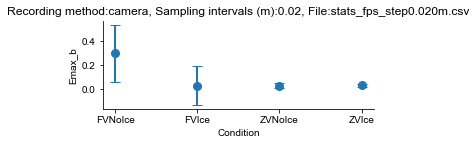

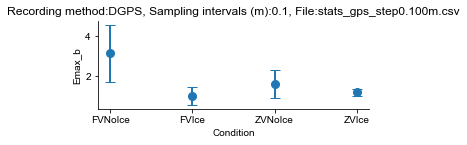

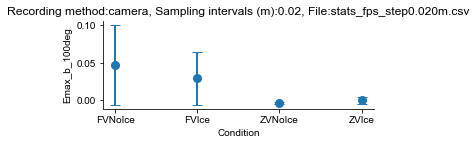

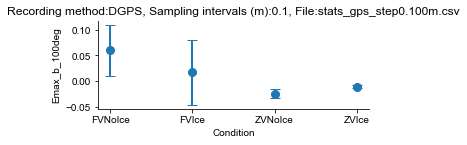

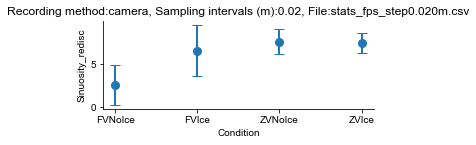

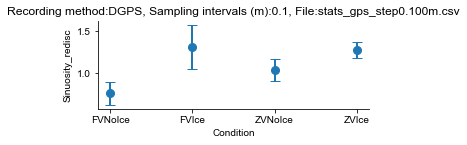

In [25]:
measures = ['Emax_a', 'Emax_b', 'TrajNestNearest', 'Emax_a_unrediscretised', 'Emax_b_unrediscretised', 'EDiffusionDistance', 'ESqDiffusionDistance', 'TrajExpDrift', 'TrajExpDriftDist', 'mean_speed', 'min_C', 'min_deltaS', 'sd_speed', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc', 'straightness_DL_ratio', 'straightness_r', 'Emax_b_100deg']

measures_labels = {
    'Emax_a': 'Emax_a', 
    'Emax_b': 'Emax_b', 
    'Emax_b_100deg': 'Emax_b_100deg', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity_redisc', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness_r'
}

# Which types of plots to use can be one of the two or both
plot_type = ['errorplot', 'show_outliers'][0]

path = '../Results/Stats/'

files = {
    # Ant data
    "stats_fps_step0.020m.csv": {"sampling_interval_distance": 0.02, "recording_method": "camera"}, 
    "stats_gps_step0.100m.csv": {"sampling_interval_distance": 0.10, "recording_method": "DGPS"} 
}

def plotMeansOfMeasure(files, stat_significance=False):
    dic_of_df = {}
    for filename in files.keys():
        try:
            df = pd.read_csv(path + filename)
        except:
            print('File {} not available.'.format(path + filename))
            continue
        
        if 'condition' in df and 'noiseSyn' not in df and 'noiseRot' not in df:
            df_pivot = pd.pivot_table(df, index=['condition'])
        if 'condition' in df and 'noiseSyn' in df and 'noiseRot' in df:
            df_pivot = pd.pivot_table(df, index=['condition', 'noiseSyn', 'noiseRot'], aggfunc=np.median)
        print()
        print('Recording method:', files[filename]["recording_method"], ', Sampling intervals (m):', files[filename]["sampling_interval_distance"], ', File:', filename)
        
        display(HTML(df_pivot.to_html()))

        conditions = df.condition.unique().tolist()
        # Do not show this condition
        try:
            conditions.remove('treeFV') # Do not show this condition
        except:
            pass 
        
        try:
            data_list = []
            for i, condition in enumerate(conditions):
                data_list.append(df.loc[df['condition'] == condition][measure])

            fig, ax = plt.subplots(1, 1, figsize=(column_full/2, column_full/2/3))

            if 'errorplot' in plot_type:
                m = []
                sd = []
                min_val = []
                outliers = []
                for idx_i,d in enumerate(data_list):
                    d_without_outliers, d_outliers = reject_outliers(d)
                    m.append(np.median(d_without_outliers))
                    min_val.append(np.min(d_without_outliers))
                    sd.append(np.std(d_without_outliers))
                        
                    outliers.append(d_outliers)
                ax.errorbar(x=np.arange(len(conditions))+1, y=m, yerr=sd, fmt='o', linewidth=2, markersize=8, capsize=5, zorder=1)
                if 'show_outliers' in plot_type and len(d_outliers):
                    ax.scatter([idx_i+1]*len(d_outliers), d_outliers, marker='x', color='red', zorder=2)
                ax.set_xticks(np.arange(len(conditions))+1)
                ax.set_xticklabels(conditions)
                
                # Print out values
                print(measure)
                print('-' * 80)
                print(filename)
                print('{:<10s}'.format(' ')      + str(' {:^20} ' * len(conditions)).format(*conditions))
                print('{:<10s}'.format('Median') + str(' {:^20} ' * len(conditions)).format(*m))
                print('{:<10s}'.format('SD')     + str(' {:^20} ' * len(conditions)).format(*sd))
            
            # If too many conditions try to fit them
            if len(conditions) > 6:
                for label in ax.get_xticklabels():
                    label.set_rotation(45)
                    label.set_ha('center')
            ax.set_xlabel('Condition');
            ax.set_ylabel(measures_labels[measure]);
            ax.set_title('Recording method:' + files[filename]["recording_method"] + ', Sampling intervals (m):' + str(files[filename]["sampling_interval_distance"]) + ', File:' + filename)

            if save_figures:
                if 'fps' in filename:
                    fig.savefig(images_path + 'ants_platformRelease_' + filename.replace('.csv', '') + '_' + measure + save_figures_as_filetype, bbox_inches='tight', transparent=True)
                elif 'gps' in filename:
                    fig.savefig(images_path + 'ants_fullRelease_' + filename.replace('.csv', '') + '_' + measure + save_figures_as_filetype, bbox_inches='tight', transparent=True)
                elif 'simulated'in filename and 'platformReleases' in filename:
                    fig.savefig(images_path + 'simulated_fullRelease_' + filename.replace('.csv', '') + '_' + measure + save_figures_as_filetype, bbox_inches='tight', transparent=True)
            
            if filename == "stats_gps_step0.100m.csv" and stat_significance:
                print()
                print('Statistical significance of two sample means of path lengths:')
                #st = stat_tests(data=data_list, print_data=True)
                data_list_dict = {}
                for i, condition in enumerate(conditions):
                    data_list_dict[condition] = data_list[i]
                st = stat_tests(data=data_list_dict, print_data=True)
        except:
            pass

for m_i in [1, 18, 14]:
    measure = measures[m_i]
    plotMeansOfMeasure(files, stat_significance=True)


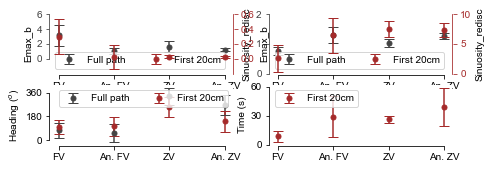

In [26]:
# Plots the ant errorbar plots all together for the paper. 

# Copied here from above for plotting altogether the ants statistics
real_ants_data = {
    'GPS': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [31.5302582218356, 10.3176102312622, 16.2750364321444, 12.0249773396948],
            'sd'      : [14.325383352300426, 4.487531108686829, 7.144758119095181, 1.8637133480714994]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [3.15302582218356, 1.03176102312622, 1.6275036432144399, 1.20249773396948],
            'sd'      : [1.4325383352300423, 0.44875311086868297, 0.7144758119095183, 0.18637133480715007]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [7.127161413461475, 10.22697574128825,  10.57343933722575,   9.92759283939856],
            'sd'      : [1.528755439698783,  1.1267538367441179, 0.3391111283899937, 0.13449016007264003]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.755121149514665, 1.31327905768908, 1.03937750982939, 1.27431383037291],
            'sd'      : [0.13730884099125706, 0.26715541675332033, 0.13383796822542393, 0.09533947255978004]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.973524952011658, 0.953394099346797, 0.949879743369715, 0.9250088788923895],
            'sd'      : [0.013542570956998536, 0.024457530862177862, 0.011255014492325839, 0.014381310574671513]
        },
        'heading': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'mean'    : [1.282,             0.949,             5.785,             4.597], 
            'sd'      : [0.980,             1.219,             1.089,             1.314], 
            'r'       : [0.520,             0.257,             0.408,             0.137]
        }
    }, 
    'camera': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [14.7628732864851, 1.34233020145891, 1.26865230983681, 1.36289114719143],
            'sd'      : [11.791451481990247, 7.986602478805116, 1.079383225450193, 0.6203651207951459]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.295257465729703, 0.0268466040291783, 0.0253730461967362, 0.0272578229438287],
            'sd'      : [0.23582902963980523, 0.15973204957610238, 0.021587664509003856, 0.012407302415902953]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [10.8266502737215,    10.8294962206449,    10.9540688207057,     10.9265272442551],
            'sd'      : [0.033684654044847245, 0.06106366808014325, 0.020711684455312983, 0.03312569267991858]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [2.55965745922281, 6.49178802540813, 7.51932345741891, 7.32666375151968],
            'sd'      : [2.270146269395501, 2.9560749398484205, 1.4180696377206659, 1.166951565282718]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.943027856885317, 0.6552366909224889, 0.594538075964726, 0.576832747214129],
            'sd'      : [0.1561190119835832, 0.21302056450214446, 0.12294651192982278, 0.12446565449696617]
        },
        'heading': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'mean'    : [1.689,             1.836,             4.340,             2.483], 
            'sd'      : [0.947,             1.249,             1.316,             1.371],
            'r'       : [0.551,             0.219,             0.134,             0.061]
        },
        'time': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'mean'    : [8.436923076923078, 28.765333333333334, 26.253333333333334, 38.973333333333336], 
            'sd'      : [5.902770385577612, 21.39778862925378,  3.915144385020246,  19.641108816855414]            
        }
    }    
}


condition_label = {
    'FVNoIce' : 'FV', 
    'FVIce'   : 'An. FV', 
    'ZVNoIce' : 'ZV', 
    'ZVIce'   : 'An. ZV'
}

def conditionsToLabels(lst):
    if not isinstance(lst, list):
        lst = [lst]
    return [condition_label[item] for item in lst]
    
recording_methods_names = ['Full path', 'First 20cm']

markersize=5
capsize=5

colour1 = 'tab:blue'
colour1 = '#444444'
colour2 = 'tab:orange'
colour2 = 'tab:red'
colour2 = 'brown'
#colour2 = 'darkred'

fig, axs = plt.subplots(2, 2, figsize=(column_double, column_double/3))
#fig, axs = plt.subplots(2, 2, figsize=(12, 7))

ax = axs[0,0]
twin1 = ax.twinx()
measure    = 'Emax_b'
recording_method_i = 0
conditions = real_ants_data['GPS'][measure]['condition']
median     = real_ants_data['GPS'][measure]['median']
std        = real_ants_data['GPS'][measure]['sd']
p1 = ax.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour1, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
recording_method_i = 1
conditions = real_ants_data['camera'][measure]['condition']
median     = np.array(real_ants_data['camera'][measure]['median'])
std        = np.array(real_ants_data['camera'][measure]['sd'])
p2 = twin1.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour2, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel(measures_labels[measure]);
twin1.set_ylabel(measures_labels[measure]);
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
#ax.legend(ncol=2)
lns = [p1, p2]
ax.legend(handles=lns, loc='best', ncol=len(lns))
#ax.yaxis.label.set_color(colour1)
#twin1.yaxis.label.set_color(colour2)
tkw = dict(size=4, width=1.5)
tkw = dict()
ax.tick_params(axis='y', colors=colour1, **tkw)
twin1.tick_params(axis='y', colors=colour2, **tkw)
ax.tick_params(axis='x', **tkw)
ax.spines['left'].set_color(colour1)
ax.spines['right'].set_color(colour2)
ax.set_yticks([0, 2, 4, 6]);
ax.set_ylim([-2, 6])
twin1.set_yticks([0.0, 0.2, 0.4, 0.6]);
twin1.set_ylim([-0.2, 0.6])
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 6]), margin=1)
adjust_spines(twin1, ['right'], x_values=np.array([1, 4]), y_values=np.array([0.0, 0.6]), margin=1)
ax.spines['right'].set_visible(True)

ax = axs[0,1]
twin1 = ax.twinx()
measure    = 'sinuosity_redisc'
recording_method_i = 0
conditions = real_ants_data['GPS'][measure]['condition']
median     = np.array(real_ants_data['GPS'][measure]['median'])
std        = np.array(real_ants_data['GPS'][measure]['sd'])
p1 = ax.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour1, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
recording_method_i = 1
conditions = real_ants_data['camera'][measure]['condition']
median     = real_ants_data['camera'][measure]['median']
std        = real_ants_data['camera'][measure]['sd']
p2 = twin1.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour2, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel(measures_labels[measure]);
twin1.set_ylabel(measures_labels[measure]);
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
#ax.legend(ncol=2)
lns = [p1, p2]
ax.legend(handles=lns, loc='best', ncol=len(lns))
#ax.yaxis.label.set_color(colour1)
#twin1.yaxis.label.set_color(colour2)
tkw = dict(size=4, width=1.5)
tkw = dict()
ax.tick_params(axis='y', colors=colour1, **tkw)
twin1.tick_params(axis='y', colors=colour2, **tkw)
ax.tick_params(axis='x', **tkw)
ax.spines['left'].set_color(colour1)
ax.spines['right'].set_color(colour2)
ax.set_yticks([0, 1, 2]);
ax.set_ylim([0, 2])
twin1.set_yticks([0, 5, 10]);
twin1.set_ylim([0, 10])
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 2]), margin=1)
adjust_spines(twin1, ['right'], x_values=np.array([1, 4]), y_values=np.array([0, 10]), margin=1)
ax.spines['right'].set_visible(True)

ax = axs[1,0]
measure    = 'heading'
recording_method_i = 0
conditions = real_ants_data['GPS'][measure]['condition']
median     = real_ants_data['GPS'][measure]['mean']
std        = real_ants_data['GPS'][measure]['sd']
ax.errorbar(x=np.arange(len(conditions))+1, y=np.degrees(median), yerr=np.degrees(std), fmt='o', color=colour1, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
recording_method_i = 1
conditions = real_ants_data['camera'][measure]['condition']
median     = real_ants_data['camera'][measure]['mean']
std        = real_ants_data['camera'][measure]['sd']
ax.errorbar(x=np.arange(len(conditions))+1, y=np.degrees(median), yerr=np.degrees(std), fmt='o', color=colour2, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel('Heading ($^o$)');
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
ax.legend(ncol=2)
ax.set_yticks([0, 180, 360]);
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 360]), margin=1)

ax = axs[1,1]
measure    = 'time'
conditions = real_ants_data['camera'][measure]['condition']
median     = real_ants_data['camera'][measure]['mean']
std        = real_ants_data['camera'][measure]['sd']
ax.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour2, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel('Time (s)');
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
ax.legend()
ax.set_yticks([0, 30, 60]);
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 60]), margin=1)

if save_figures:
    fig.savefig(images_path + 'ants_allReleases_' + 'Emax_Sinuosity_Theta_Time_within_20cm' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


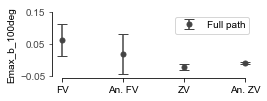

In [27]:
# Plots the Emaxb for the DGPS ant paths with assumed direction to 100deg. 

# Copied here from above for plotting the ants statistics
real_ants_data = {
    'GPS': {
        # Emax_b_100deg values from above
        'Emax_b_100deg': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.0600632623424949, 0.0174183380698823, -0.0240606366865208, -0.011026657077781],
            'sd'      : [0.04987695857567853, 0.06342166645023738, 0.009383912485339539, 0.0028780313523546]
        } 
    }
}


condition_label = {
    'FVNoIce' : 'FV', 
    'FVIce'   : 'An. FV', 
    'ZVNoIce' : 'ZV', 
    'ZVIce'   : 'An. ZV'
}

def conditionsToLabels(lst):
    if not isinstance(lst, list):
        lst = [lst]
    return [condition_label[item] for item in lst]
    
recording_methods_names = ['Full path', 'First 20cm']

# Plot styling
markersize=5
capsize=5

colour1 = '#444444'

fig = plt.figure(figsize=(column_double/2, column_double/3/2))
ax = plt.gca()

measure    = 'Emax_b_100deg'
recording_method_i = 0
conditions = real_ants_data['GPS'][measure]['condition']
median     = real_ants_data['GPS'][measure]['median']
std        = real_ants_data['GPS'][measure]['sd']
p1 = ax.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour1, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel(measures_labels[measure]);
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));

lns = [p1]
ax.legend(handles=lns, loc='best', ncol=len(lns))

tkw = dict(size=4, width=1.5)
tkw = dict()
ax.tick_params(axis='y', colors=colour1, **tkw)
ax.tick_params(axis='x', **tkw)

ax.set_yticks([-0.05, 0.05, 0.15]);

adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([-0.05, 0.15]), margin=1)

if save_figures:
    fig.savefig(images_path + 'ants_allReleases_' + 'Emax_b_100deg_fullPaths' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## Plot the path characteristics of the simulated agents superimposed with the ant data

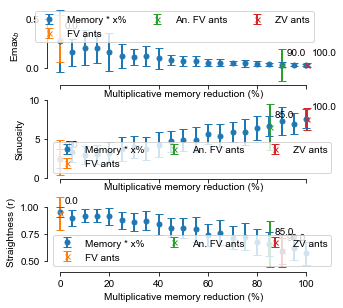

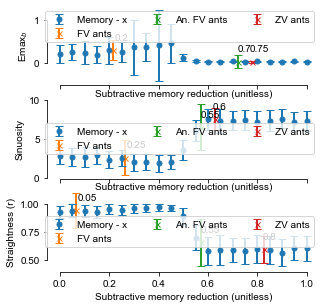

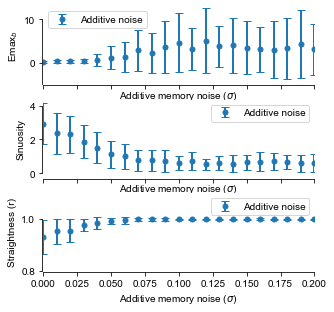

In [28]:
# Plot styling
markersize=5
capsize=4

print_numeric_stats = False
no_titles = True

show_FVNoIce = True
show_FVIce = True
show_ZVNoIce = True
show_simulated_FV = False
show_simulated_ZV = False

path = '../Results/Stats/'

measures = ['Emax_a', 'Emax_b', 'TrajNestNearest', 'Emax_a_unrediscretised', 'Emax_b_unrediscretised', 'EDiffusionDistance', 'ESqDiffusionDistance', 'TrajExpDrift', 'TrajExpDriftDist', 'mean_speed', 'min_C', 'min_deltaS', 'sd_speed', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc', 'straightness_DL_ratio', 'straightness_r']
show_measures = [1, 14, 17]

noiseSyn = 0.1
noiseRot = 7

measures_labels = {
    'Emax_a': 'Emax$_a$', 
    'Emax_b': 'Emax$_b$', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness (r)'
}

# Copied here from above the ants statistics
real_ants_data = {
    'GPS': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [31.5302582218356, 10.3176102312622, 16.2750364321444, 12.0249773396948],
            'sd'      : [14.325383352300426, 4.487531108686829, 7.144758119095181, 1.8637133480714994]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [3.15302582218356, 1.03176102312622, 1.6275036432144399, 1.20249773396948],
            'sd'      : [1.4325383352300423, 0.44875311086868297, 0.7144758119095183, 0.18637133480715007]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [7.127161413461475, 10.22697574128825,  10.57343933722575,   9.92759283939856],
            'sd'      : [1.528755439698783,  1.1267538367441179, 0.3391111283899937, 0.13449016007264003]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.755121149514665, 1.31327905768908, 1.03937750982939, 1.27431383037291],
            'sd'      : [0.13730884099125706, 0.26715541675332033, 0.13383796822542393, 0.09533947255978004]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.973524952011658, 0.953394099346797, 0.949879743369715, 0.9250088788923895],
            'sd'      : [0.013542570956998536, 0.024457530862177862, 0.011255014492325839, 0.014381310574671513]
        }
    }, 
    'camera': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [14.7628732864851, 1.34233020145891, 1.26865230983681, 1.36289114719143],
            'sd'      : [11.791451481990247, 7.986602478805116, 1.079383225450193, 0.6203651207951459]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.295257465729703, 0.0268466040291783, 0.0253730461967362, 0.0272578229438287],
            'sd'      : [0.23582902963980523, 0.15973204957610238, 0.021587664509003856, 0.012407302415902953]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [10.8266502737215,    10.8294962206449,    10.9540688207057,     10.9265272442551],
            'sd'      : [0.033684654044847245, 0.06106366808014325, 0.020711684455312983, 0.03312569267991858]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [2.55965745922281, 6.49178802540813, 7.51932345741891, 7.32666375151968],
            'sd'      : [2.270146269395501, 2.9560749398484205, 1.4180696377206659, 1.166951565282718]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.943027856885317, 0.6552366909224889, 0.594538075964726, 0.576832747214129],
            'sd'      : [0.1561190119835832, 0.21302056450214446, 0.12294651192982278, 0.12446565449696617]
        }
    }    
}


files = {
    # Simulated data
    "stats_simulated_with_Pontin_Holonomic_platformReleases_step0.020m.csv": {"sampling_interval_distance": 0.020, "recording_method": "simulated"}, 
}

# What memory manipulations to plot
memManipulationTypesList = [
    'Multiply', 
    'Subtract', 
    'Noise'
]

    
memManipulationTypes = {
    'FVNoIce' : 'FV ants', 
    'FVIce'   : 'An. FV ants', 
    'ZVNoIce' : 'ZV ants', 
    'FV'      : 'FV simulated', 
    'ZV'      : 'ZV simulated', 
    'Multiply': 'Memory * x%', 
    'Subtract': 'Memory - x', 
    'Noise'   : 'Additive noise', 
    'Equal'   : 'CPU4 = x (ZV)',         
}


def getSelectedData(df_pivot, condition, memManipulationType, measure, noiseSyn = 0.1, noiseRot = 20):
    """ 
        Select and return the memory degradation level, the median, and 
        SD data as arrays for the specified index conditions. 
    """
    
    temp1 = df_pivot.query('condition == "'+condition+'" & noiseSyn == '+str(noiseSyn)+' & noiseRot == '+str(noiseRot)+' & MemManipType == "' + memManipulationType + '"')

    # The memory manipulation levels
    MemDegradation = temp1.index.get_level_values('MemDegradation')
    
    temp = temp1.loc[:, [('median_without_outliers', measure), ('std_without_outliers', measure)]].values
    
    # The median and SD arrays
    med = temp[:,0]
    std = temp[:,1]

    return MemDegradation, med, std

def median_without_outliers(x):
    without_outliers, outliers = reject_outliers(x)
    if len(without_outliers) > 0:
        x = without_outliers
    return np.median(x)

def std_without_outliers(x):
    without_outliers, outliers = reject_outliers(x)
    if len(without_outliers) > 0:
        x = without_outliers
    return np.std(x)

for filename in files.keys():
    try:
        df = pd.read_csv(path + filename)
    except:
        print('File {} not available.'.format(path + filename))
        continue

    # Calculate the median and SD
    df_pivot = pd.pivot_table(df, index=['condition', 'noiseSyn', 'noiseRot', 'MemManipType', 'MemDegradation'], aggfunc=[median_without_outliers, std_without_outliers])

    for i, memManipulationType in enumerate(memManipulationTypesList):
        
        fig, axs = plt.subplots(len(show_measures), 1, figsize=(column_full/2, column_full/2/3*len(show_measures)), sharex=True)

        for midx, m1 in enumerate(show_measures):
            measure = measures[m1]

            if isinstance(axs, (list,np.ndarray)):
                ax = axs[midx]
            else:
                ax = axs
            
            # For shifting the errorbars horizontally so they do not overlap
            bar_trans = []
            trans_step = 0.007
            for k in range(0, 5):
                bar_trans.append(Affine2D().translate(trans_step*(k+1), 0.0) + ax.transData)

            # Select the entries with manipulated memory ("FVIce") and MemManipType==memManipulationType and get the median and SD for all MemDegradation values
            MemDegradation, m, sd = getSelectedData(df_pivot, "FVIce", memManipulationType, measure, noiseSyn = noiseSyn, noiseRot = noiseRot)
            if memManipulationType == 'Multiply':
                MemDegradation = (1 - MemDegradation) * 100
            
            ax.errorbar(x=MemDegradation, y=m, yerr=sd, fmt='o', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[memManipulationType])

            #if filename == "stats_simulated_with_Pontin_Holonomic_platformReleases_step0.020m.csv" and memManipulationType == 'GPS':
            if '_platformReleases' in filename:
                recordingType = 'camera'
            else:
                recordingType = 'GPS'

            con = real_ants_data[recordingType][measure]['condition']
            med = real_ants_data[recordingType][measure]['median']
            std = real_ants_data[recordingType][measure]['sd']
            
            if print_numeric_stats:
                print(recordingType, measure)
                print(con)
                print(med)
                print(std)
            
            if print_numeric_stats:
                print('MemDegradation', MemDegradation)
            
            k = 1
            j = 0 # FVNoIce
            if print_numeric_stats:
                print('m', m)
                print('med[j]', med[j])
                print('np.abs(m - med[j])', np.abs(m - med[j]))

            if show_FVNoIce and memManipulationType != 'Noise':
                best_match_memdeg_FVNoIce = MemDegradation[np.argmin(np.abs(m - med[j]))]
                ax.errorbar(x=[best_match_memdeg_FVNoIce], y=[med[j]], yerr=[std[j]], fmt='x', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[con[j]], transform=bar_trans[k])
                ax.annotate(f'{best_match_memdeg_FVNoIce}', xy=(best_match_memdeg_FVNoIce, med[j]), xytext=(5, 10), textcoords='offset points')

            if show_FVIce and memManipulationType != 'Noise':
                k += 1
                j = 1 # FVIce
                best_match_memdeg_FVIce = MemDegradation[np.argmin(np.abs(m - med[j]))]
                ax.errorbar(x=[best_match_memdeg_FVIce], y=[med[j]], yerr=[std[j]], fmt='x', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[con[j]], transform=bar_trans[k])
                ax.annotate(f'{best_match_memdeg_FVIce}', xy=(best_match_memdeg_FVIce, med[j]), xytext=(5, 10), textcoords='offset points')

            if show_ZVNoIce and memManipulationType != 'Noise':
                k += 1
                j = 2 # ZVNoIce
                best_match_memdeg_ZVNoIce = MemDegradation[np.argmin(np.abs(m - med[j]))]
                ax.errorbar(x=[best_match_memdeg_ZVNoIce], y=[med[j]], yerr=[std[j]], fmt='x', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[con[j]], transform=bar_trans[k])
                ax.annotate(f'{best_match_memdeg_ZVNoIce}', xy=(best_match_memdeg_ZVNoIce, med[j]), xytext=(5, 10), textcoords='offset points')

            if show_simulated_FV:
                k += 1 # FV simulated
                controlMemConditionType = 'FV'
                # Select the entries with the MemManipType==memManipulationType and get the median and SD for all MemDegradation values
                MemDegradation2, med, std = getSelectedData(df_pivot, controlMemConditionType, "None", measure, noiseSyn = noiseSyn, noiseRot = noiseRot)
                best_match_memdeg_FV2 = MemDegradation[np.argmin(np.abs(m - med))]
                ax.errorbar(x=[best_match_memdeg_FV2], y=med, yerr=std, fmt='+', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[controlMemConditionType], transform=bar_trans[k])

            if show_simulated_ZV:
                k += 1 # ZV simulated
                controlMemConditionType = 'ZV'
                # Select the entries with the MemManipType==memManipulationType and get the median and SD for all MemDegradation values
                MemDegradation3, med, std = getSelectedData(df_pivot, controlMemConditionType, "None", measure, noiseSyn = noiseSyn, noiseRot = noiseRot)
                best_match_memdeg_ZV2 = MemDegradation[np.argmin(np.abs(m - med))]
                ax.errorbar(x=[best_match_memdeg_ZV2], y=med, yerr=std, fmt='+', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[controlMemConditionType], transform=bar_trans[k])

            ax.legend(ncol=k, frameon=True) # , mode='expand'

            ax.set_ylabel(measures_labels[measure]);
            if not no_titles: 
                ax.set_title('Recording method:' + files[filename]["recording_method"] + ', Sampling intervals (m):' + str(files[filename]["sampling_interval_distance"]) + ', File:' + filename)
            
            if memManipulationType == 'Noise':
                ax.set_xlim([0, 0.2]);

            if memManipulationType == 'Multiply':
                ax.set_xlabel('Multiplicative memory reduction (%)');
                x_values=np.array([0, 100])
                if measure == 'Emax_a':
                    y_values=np.array([0,  30])
                    ax.set_ylim([None,  30])
                elif measure == 'Emax_b':
                    y_values=np.array([0,   0.5])
                elif measure == 'sinuosity_redisc':
                    y_values=np.array([0,  10])
                    ax.set_ylim([0, 10])
                elif measure == 'straightness_r':
                    y_values=np.array([0.5, 1.0])
            elif memManipulationType == 'Subtract':
                ax.set_xlabel('Subtractive memory reduction (unitless)');
                x_values=np.array([0, 1])
                if measure == 'Emax_a':
                    y_values=np.array([-25,  50])
                elif measure == 'Emax_b':
                    y_values=np.array([0,   1.0])
                    ax.set_ylim([-0.5, None])
                elif measure == 'sinuosity_redisc':
                    y_values=np.array([0,  10])
                    ax.set_ylim([0, 10])
                elif measure == 'straightness_r':
                    y_values=np.array([0.5, 1.0])
                    ax.set_ylim([0.4,  1.1])
            elif memManipulationType == 'Noise':
                ax.set_xlabel('Additive memory noise ($\sigma$)');
                x_values=np.array([0, 0.2])
                if measure == 'Emax_a':
                    y_values=np.array([-250,  500])
                elif measure == 'Emax_b':
                    y_values=np.array([-5,   10])
                    ax.set_ylim([-5, 13])
                elif measure == 'sinuosity_redisc':
                    y_values=np.array([0,  4])
                    #ax.set_ylim([0, 10])
                elif measure == 'straightness_r':
                    y_values=np.array([0.8, 1.0])
                    ax.set_ylim([0.8,  1.1])

            # Beautify the axes
            adjust_spines(ax, ['left', 'bottom'], x_values=x_values, y_values=y_values, margin=1)

            if save_figures:
                if 'platformReleases' in filename:
                    fig.savefig(images_path + 'memory_manipulation_effect_' + memManipulationType + '_' + '_ants_platformRelease_overlapping_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
                else:
                    fig.savefig(images_path + 'memory_manipulation_effect_' + memManipulationType + '_' + '_ants_fullRelease_overlapping_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)


best_match_memdeg_FVIce = 90.0
best_match_memdeg_FVIce = 85.0
best_match_memdeg_FVIce = 85.0
best_match_memdeg_FVIce = 85.0
best_match_memdeg_FVIce = 85.0
best_match_memdeg_FVIce = 0.7
best_match_memdeg_FVIce = 0.55
best_match_memdeg_FVIce = 0.55
best_match_memdeg_FVIce = 0.55
best_match_memdeg_FVIce = 0.55
best_match_memdeg_FVIce = 0.0
best_match_memdeg_FVIce = 0.0
best_match_memdeg_FVIce = 0.0
best_match_memdeg_FVIce = 0.0
best_match_memdeg_FVIce = 0.0


/Users/john/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:324: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


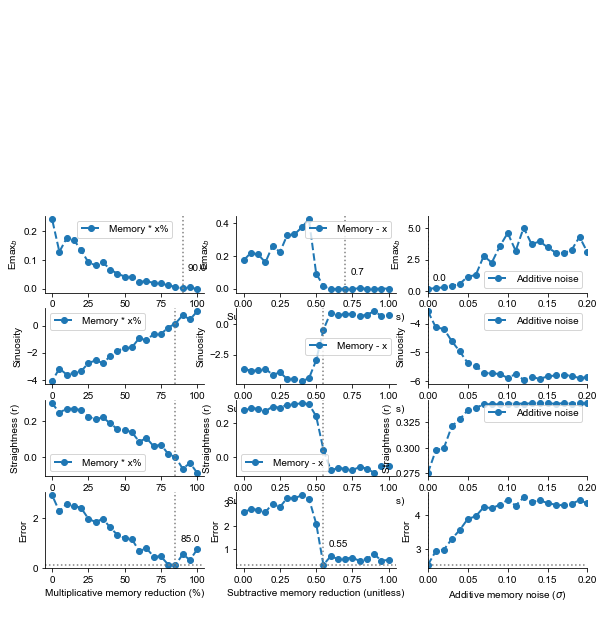

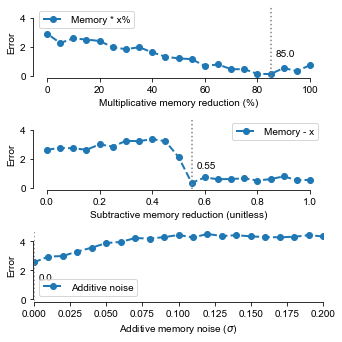

In [29]:
# Plot the ant and model match error

# Plot styling
markersize=5
capsize=4

print_numeric_stats = False
no_titles = True

show_FVNoIce = True
show_FVIce = True
show_ZVNoIce = True
show_simulated_FV = False
show_simulated_ZV = False

path = '../Results/Stats/'

measures = ['Emax_a', 'Emax_b', 'TrajNestNearest', 'Emax_a_unrediscretised', 'Emax_b_unrediscretised', 'EDiffusionDistance', 'ESqDiffusionDistance', 'TrajExpDrift', 'TrajExpDriftDist', 'mean_speed', 'min_C', 'min_deltaS', 'sd_speed', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc', 'straightness_DL_ratio', 'straightness_r']
show_measures = [1, 14, 17]

noiseSyn = 0.1
noiseRot = 7

measures_labels = {
    'Emax_a': 'Emax$_a$', 
    'Emax_b': 'Emax$_b$', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness (r)'
}

# Copied here from above the ants statistics
real_ants_data = {
    'GPS': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [31.5302582218356, 10.3176102312622, 16.2750364321444, 12.0249773396948],
            'sd'      : [14.325383352300426, 4.487531108686829, 7.144758119095181, 1.8637133480714994]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [3.15302582218356, 1.03176102312622, 1.6275036432144399, 1.20249773396948],
            'sd'      : [1.4325383352300423, 0.44875311086868297, 0.7144758119095183, 0.18637133480715007]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [7.127161413461475, 10.22697574128825,  10.57343933722575,   9.92759283939856],
            'sd'      : [1.528755439698783,  1.1267538367441179, 0.3391111283899937, 0.13449016007264003]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.755121149514665, 1.31327905768908, 1.03937750982939, 1.27431383037291],
            'sd'      : [0.13730884099125706, 0.26715541675332033, 0.13383796822542393, 0.09533947255978004]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.973524952011658, 0.953394099346797, 0.949879743369715, 0.9250088788923895],
            'sd'      : [0.013542570956998536, 0.024457530862177862, 0.011255014492325839, 0.014381310574671513]
        }
    }, 
    'camera': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [14.7628732864851, 1.34233020145891, 1.26865230983681, 1.36289114719143],
            'sd'      : [11.791451481990247, 7.986602478805116, 1.079383225450193, 0.6203651207951459]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.295257465729703, 0.0268466040291783, 0.0253730461967362, 0.0272578229438287],
            'sd'      : [0.23582902963980523, 0.15973204957610238, 0.021587664509003856, 0.012407302415902953]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [10.8266502737215,    10.8294962206449,    10.9540688207057,     10.9265272442551],
            'sd'      : [0.033684654044847245, 0.06106366808014325, 0.020711684455312983, 0.03312569267991858]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [2.55965745922281, 6.49178802540813, 7.51932345741891, 7.32666375151968],
            'sd'      : [2.270146269395501, 2.9560749398484205, 1.4180696377206659, 1.166951565282718]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.943027856885317, 0.6552366909224889, 0.594538075964726, 0.576832747214129],
            'sd'      : [0.1561190119835832, 0.21302056450214446, 0.12294651192982278, 0.12446565449696617]
        }
    }    
}

files = {
    # Simulated data
    "stats_simulated_with_Pontin_Holonomic_platformReleases_step0.020m.csv": {"sampling_interval_distance": 0.020, "recording_method": "simulated"}, 
}

# What to plot
memManipulationTypesList = [
    'Multiply', 
    'Subtract', 
    'Noise'
]
    
memManipulationTypes = {
    'FVNoIce' : 'FV ants', 
    'FVIce'   : 'An. FV ants', 
    'ZVNoIce' : 'ZV ants', 
    'FV'      : 'FV simulated', 
    'ZV'      : 'ZV simulated', 
    'Multiply': 'Memory * x%', 
    'Subtract': 'Memory - x', 
    'Noise'   : 'Additive noise', 
    'Equal'   : 'CPU4 = x (ZV)',         
}


def getSelectedData(df_pivot, condition, memManipulationType, measure, noiseSyn = 0.1, noiseRot = 20):
    """ 
        Select and return the memory degradation level, the median, and 
        SD data as arrays for the specified index conditions. 
    """
    temp1 = df_pivot.query('condition == "'+condition+'" & noiseSyn == '+str(noiseSyn)+' & noiseRot == '+str(noiseRot)+' & MemManipType == "' + memManipulationType + '"')
    
    # The memory manipulation levels
    MemDegradation = temp1.index.get_level_values('MemDegradation')
    temp = temp1.loc[:, [('median_without_outliers', measure), ('std_without_outliers', measure)]].values
    
    # The median and SD arrays
    med = temp[:,0]
    std = temp[:,1]

    return MemDegradation, med, std

def median_without_outliers(x):
    without_outliers, outliers = reject_outliers(x)
    if len(without_outliers) > 0:
        x = without_outliers
    return np.median(x)

def std_without_outliers(x):
    without_outliers, outliers = reject_outliers(x)
    if len(without_outliers) > 0:
        x = without_outliers
    return np.std(x)

def setAxesRanges(ax, memManipulationType, measure):
    if memManipulationType == 'Noise':
        ax.set_xlim([0, 0.2])

    if memManipulationType == 'Multiply':
        ax.set_xlabel('Multiplicative memory reduction (%)')
        x_values=np.array([0, 100])
        if measure == 'Emax_a':
            y_values=np.array([0,  30])
        elif measure == 'Emax_b':
            y_values=np.array([0,   0.5])
        elif measure == 'sinuosity_redisc':
            y_values=np.array([0,  10])
        elif measure == 'straightness_r':
            y_values=np.array([0.5, 1.0])
    elif memManipulationType == 'Subtract':
        ax.set_xlabel('Subtractive memory reduction (unitless)')
        x_values=np.array([0, 1])
        if measure == 'Emax_a':
            y_values=np.array([-25,  50])
        elif measure == 'Emax_b':
            y_values=np.array([0,   1.0])
        elif measure == 'sinuosity_redisc':
            y_values=np.array([0,  10])
        elif measure == 'straightness_r':
            y_values=np.array([0.5, 1.0])
    elif memManipulationType == 'Noise':
        ax.set_xlabel('Additive memory noise ($\sigma$)')
        x_values=np.array([0, 0.2])
        if measure == 'Emax_a':
            y_values=np.array([-250,  500])
        elif measure == 'Emax_b':
            y_values=np.array([-5,   10])
        elif measure == 'sinuosity_redisc':
            y_values=np.array([0,  4])
        elif measure == 'straightness_r':
            y_values=np.array([0.8, 1.0])
    return (x_values, y_values)

for filename in files.keys():
    try:
        df = pd.read_csv(path + filename)
    except:
        print('File {} not available.'.format(path + filename))
        continue

    # Calculate the median and SD
    df_pivot = pd.pivot_table(df, index=['condition', 'noiseSyn', 'noiseRot', 'MemManipType', 'MemDegradation'], aggfunc=[median_without_outliers, std_without_outliers])

    fig, axs = plt.subplots(len(show_measures)+1, len(memManipulationTypesList), figsize=(column_full, column_full/2/3*(len(show_measures)+1)))
    fig2, axs2 = plt.subplots(len(show_measures), 1, figsize=(column_full/2, column_full/2/3*len(show_measures)), sharey=True)

    for i, memManipulationType in enumerate(memManipulationTypesList):
        # Initialise the match score to 1's because we multiply matching scores
        match_score = np.array([])
        
        for midx, m1 in enumerate(show_measures):
            measure = measures[m1]

            if isinstance(axs, (list,np.ndarray)):
                ax = axs[midx,i]
            else:
                ax = axs

            # Select the entries with manipulated memory ("FVIce") and MemManipType==memManipulationType and get the median and SD for all MemDegradation values
            MemDegradation, m, sd = getSelectedData(df_pivot, "FVIce", memManipulationType, measure, noiseSyn = noiseSyn, noiseRot = noiseRot)
            if memManipulationType == 'Multiply':
                MemDegradation = (1 - MemDegradation) * 100

            #if filename == "stats_simulated_with_Pontin_Holonomic_platformReleases_step0.020m.csv" and memManipulationType == 'GPS':
            if '_platformReleases' in filename:
                recordingType = 'camera'
            else:
                recordingType = 'GPS'
            
            con = real_ants_data[recordingType][measure]['condition']
            med = real_ants_data[recordingType][measure]['median']
            std = real_ants_data[recordingType][measure]['sd']
            
            if print_numeric_stats:
                print(recordingType, measure)
                print(con)
                print(med)
                print(std)
            
            if print_numeric_stats:
                print('MemDegradation', MemDegradation)
            
            k = 1
            j = 0 # FVNoIce
            if print_numeric_stats:
                print('m', m)
                print('med[j]', med[j])
                print('np.abs(m - med[j])', np.abs(m - med[j]))

            j = 1 # FVIce
            model_error = m - med[j]
            ax.plot(MemDegradation, model_error, '--o', linewidth=2, label=memManipulationTypes[memManipulationType])
            
            # Factor error in the total score
            if match_score.size == 0:
                match_score = model_error
            else:
                match_score = match_score + model_error * model_error
            
            if show_FVIce:
                k += 1
                j = 1 # FVIce
                best_match_memdeg_FVIce = MemDegradation[np.argmin(np.abs(m - med[j]))]
                ax.annotate(f'{best_match_memdeg_FVIce}', xy=(best_match_memdeg_FVIce, med[j]), xytext=(5, 10), textcoords='offset points')
                ax.axvline(x=best_match_memdeg_FVIce, color='grey', linestyle='dotted')
                print('best_match_memdeg_FVIce =', best_match_memdeg_FVIce)
            
            ax.legend(ncol=k, frameon=True) # , mode='expand'

            ax.set_ylabel(measures_labels[measure]);
            if not no_titles: 
                ax.set_title('Recording method:' + files[filename]["recording_method"] + ', Sampling intervals (m):' + str(files[filename]["sampling_interval_distance"]) + ', File:' + filename)
            
            setAxesRanges(ax, memManipulationType, measure)
        
        if isinstance(axs, (list,np.ndarray)):
            ax = axs[midx+1,i]
        else:
            ax = axs
        
        ax.plot(MemDegradation, np.sqrt(match_score/midx), '--o', linewidth=2, label=memManipulationTypes[memManipulationType])
        ax.set_ylabel('RMSE')
        ax.set_ylabel('Error')
        
        if show_FVIce:
            k += 1
            j = 1 # FVIce
            best_match_memdeg_FVIce = MemDegradation[np.argmin(np.abs(match_score))]
            best_match_memdeg_FVIce = MemDegradation[np.argmin(np.sqrt(match_score/midx))]
            ax.annotate(f'{best_match_memdeg_FVIce}', xy=(best_match_memdeg_FVIce, med[j]), xytext=(5, 10), textcoords='offset points')
            ax.axvline(x=best_match_memdeg_FVIce, color='grey', linestyle='dotted')
            print('best_match_memdeg_FVIce =', best_match_memdeg_FVIce)
            setAxesRanges(ax, memManipulationType, measure)
        
            ax.axhline(y=np.min(np.sqrt(match_score/midx)), color='grey', linestyle='dotted')

        axs2[i].plot(MemDegradation, np.sqrt(match_score/midx), '--o', linewidth=2, label=memManipulationTypes[memManipulationType])
        axs2[i].set_ylabel('RMSE')
        axs2[i].set_ylabel('Error')
        if show_FVIce:
            k += 1
            j = 1 # FVIce
            best_match_memdeg_FVIce = MemDegradation[np.argmin(np.abs(match_score))]
            best_match_memdeg_FVIce = MemDegradation[np.argmin(np.sqrt(match_score/midx))]
            axs2[i].annotate(f'{best_match_memdeg_FVIce}', xy=(best_match_memdeg_FVIce, med[j]), xytext=(5, 10), textcoords='offset points')
            axs2[i].axvline(x=best_match_memdeg_FVIce, color='grey', linestyle='dotted')
            print('best_match_memdeg_FVIce =', best_match_memdeg_FVIce)
        x_values, y_values = setAxesRanges(axs2[i], memManipulationType, measure)
        axs2[i].legend()
        
        # Beautify the axes
        adjust_spines(axs2[i], ['left', 'bottom'], x_values=x_values, y_values=np.array([0,4]), margin=1)
        
    if save_figures:
        if 'platformReleases' in filename:
            fig.savefig(images_path + 'memory_manipulation_effect_error_' + memManipulationType + '_' + '_ants_platformRelease_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
            fig2.savefig(images_path + 'memory_manipulation_effect_total_error_only_' + memManipulationType + '_' + '_ants_platformRelease_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
        else:
            fig.savefig(images_path + 'memory_manipulation_effect_error_' + memManipulationType + '_' + '_ants_fullRelease_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
            fig2.savefig(images_path + 'memory_manipulation_effect_total_error_only_' + memManipulationType + '_' + '_ants_fullRelease_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
    else:
        fig.tight_layout()
        fig2.tight_layout()
        

FV platformRelease Diff Emax_a Min = 1.286 (slope, noise) = (5, 9)
ZV platformRelease Diff Emax_a Min = 0.471 (slope, noise) = (12, 10)
FV full trajectory Diff Emax_a Min = 0.193 (slope, noise) = (6, 10)
ZV full trajectory Diff Emax_a Min = 0.000 (slope, noise) = (5, 7)

FV platformRelease Diff Emax_b Min = 0.026 (slope, noise) = (5, 9)
ZV platformRelease Diff Emax_b Min = 0.009 (slope, noise) = (12, 10)
FV full trajectory Diff Emax_b Min = 0.019 (slope, noise) = (6, 10)
ZV full trajectory Diff Emax_b Min = 0.000 (slope, noise) = (5, 7)

FV platformRelease Diff Sinuosity_redisc Min = 0.396 (slope, noise) = (9, 1)
ZV platformRelease Diff Sinuosity_redisc Min = 0.462 (slope, noise) = (9, 1)
FV full trajectory Diff Sinuosity_redisc Min = 0.719 (slope, noise) = (18, 1)
ZV full trajectory Diff Sinuosity_redisc Min = 0.000 (slope, noise) = (5, 7)

FV platformRelease Diff Straightness_r Min = 0.586 (slope, noise) = (5, 9)
ZV platformRelease Diff Straightness_r Min = 0.349 (slope, noise) = (11

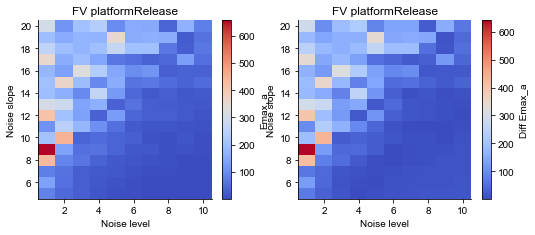

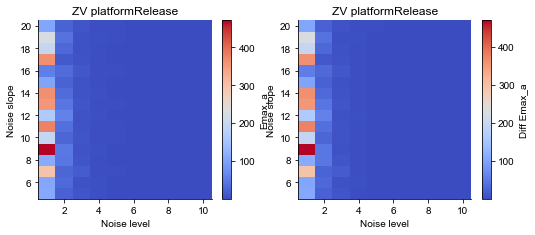

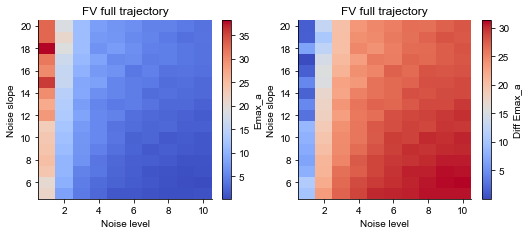

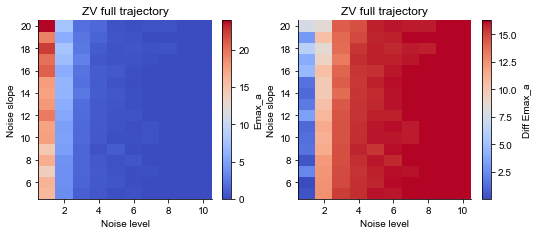

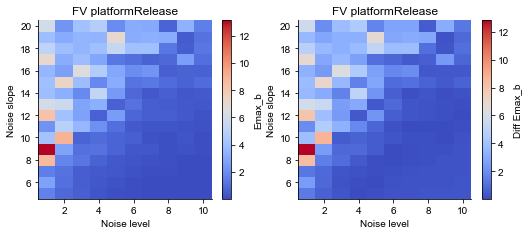

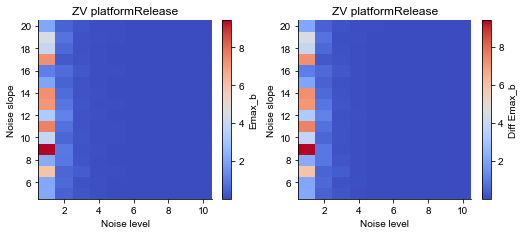

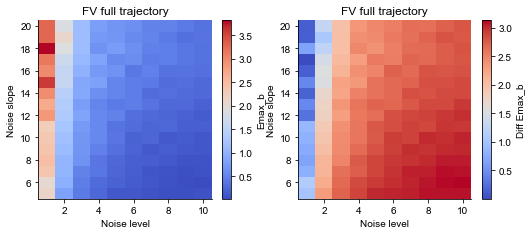

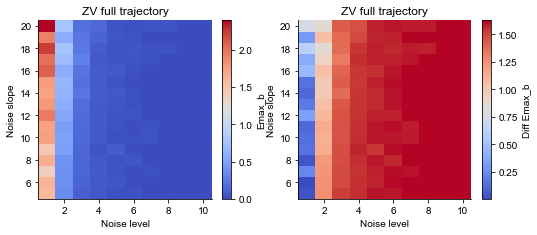

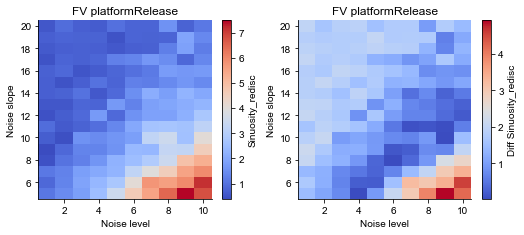

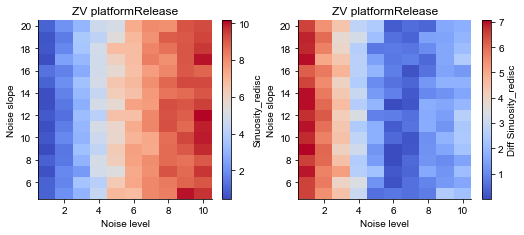

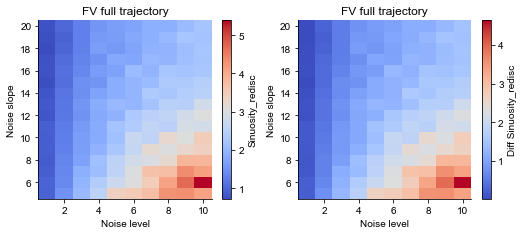

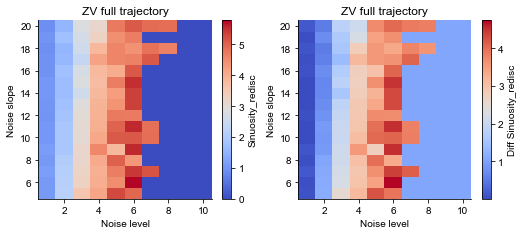

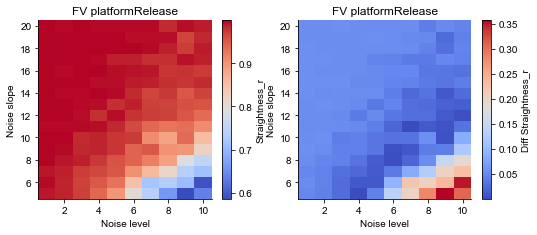

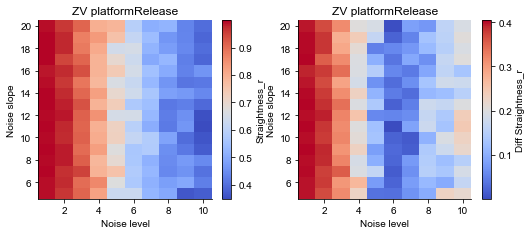

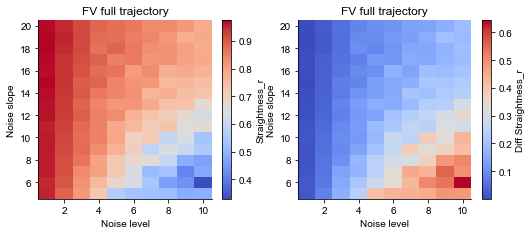

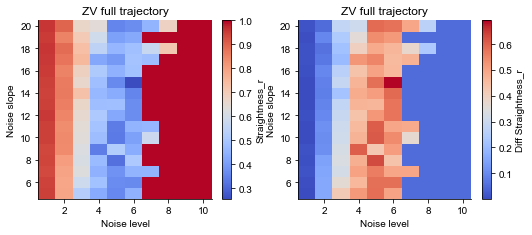

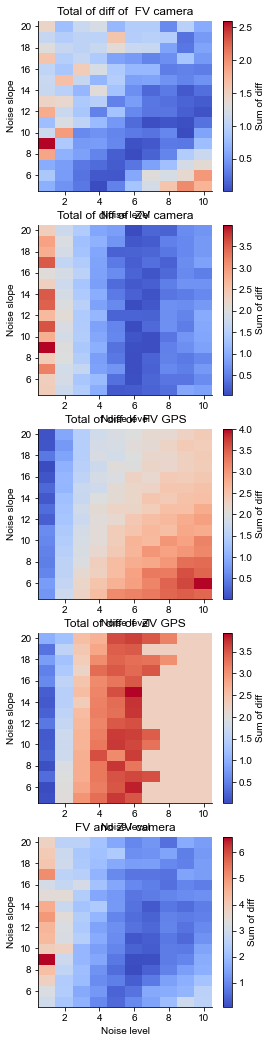

In [31]:
# This was used for exploring the noise levels and noise slope values and find the levels that produce similar statistics with the real FV and ZV ants
print_numeric_stats = False
save_to_pdf_file = False
show_all_or_high_res_focused = 'focused' # 'all' or 'focused' to show all data sparsely sampled or focused with high resolution

mm_per_in = 25.4 
fig_width  = 83 / mm_per_in + 1 # mm / mm_per_in
fig_height = 58 / mm_per_in + 1 # mm / mm_per_in

from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages

path = '../Results/Stats/Rediscetized/Simulated_scaling0.03/'
params_subdirs = ['Stats_Noise_X_slope_Y_ymax1.0_ymin0.0_600steps']
params_subdirs = [params_subdirs[0]] # Show only this one

measures = ['Emax_a', 'Emax_b', 'TrajNestNearest', 'Emax_a_unrediscretised', 'Emax_b_unrediscretised', 'EDiffusionDistance', 'ESqDiffusionDistance', 'TrajExpDrift', 'TrajExpDriftDist', 'mean_speed', 'min_C', 'min_deltaS', 'sd_speed', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc', 'straightness_DL_ratio', 'straightness_r']
show_measures = [0, 1, 14, 17]

measures_labels = {
    'Emax_a': 'Emax_a', 
    'Emax_b': 'Emax_b', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity_redisc', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness_r'
}

# Copied here from above the real ants statistics
real_ants_data = {
    'GPS': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [31.5302582218356, 10.3176102312622, 16.2750364321444, 12.0249773396948],
            'sd'      : [14.325383352300426, 4.487531108686829, 7.144758119095181, 1.8637133480714994]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [3.15302582218356, 1.03176102312622, 1.6275036432144399, 1.20249773396948],
            'sd'      : [1.4325383352300423, 0.44875311086868297, 0.7144758119095183, 0.18637133480715007]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [7.127161413461475, 10.22697574128825,  10.57343933722575,   9.92759283939856],
            'sd'      : [1.528755439698783,  1.1267538367441179, 0.3391111283899937, 0.13449016007264003]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.755121149514665, 1.31327905768908, 1.03937750982939, 1.27431383037291],
            'sd'      : [0.13730884099125706, 0.26715541675332033, 0.13383796822542393, 0.09533947255978004]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.973524952011658, 0.953394099346797, 0.949879743369715, 0.9250088788923895],
            'sd'      : [0.013542570956998536, 0.024457530862177862, 0.011255014492325839, 0.014381310574671513]
        }
    }, 
    'camera': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [14.7628732864851, 1.34233020145891, 1.26865230983681, 1.36289114719143],
            'sd'      : [11.791451481990247, 7.986602478805116, 1.079383225450193, 0.6203651207951459]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.295257465729703, 0.0268466040291783, 0.0253730461967362, 0.0272578229438287],
            'sd'      : [0.23582902963980523, 0.15973204957610238, 0.021587664509003856, 0.012407302415902953]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [10.8266502737215,    10.8294962206449,    10.9540688207057,     10.9265272442551],
            'sd'      : [0.033684654044847245, 0.06106366808014325, 0.020711684455312983, 0.03312569267991858]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [2.55965745922281, 6.49178802540813, 7.51932345741891, 7.32666375151968],
            'sd'      : [2.270146269395501, 2.9560749398484205, 1.4180696377206659, 1.166951565282718]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.943027856885317, 0.6552366909224889, 0.594538075964726, 0.576832747214129],
            'sd'      : [0.1561190119835832, 0.21302056450214446, 0.12294651192982278, 0.12446565449696617]
        }
    }    
}

files = {
    # Simulated data
    "stats_simulated_with_Pontin_Holonomic_FV_noiseRot_combined_noiseSlope_combined_platformReleases_step0.020m.csv": {"sampling_interval_distance": 0.020, "recording_method": "simulated"}, 
    "stats_simulated_with_Pontin_Holonomic_ZV_noiseRot_combined_noiseSlope_combined_platformReleases_step0.020m.csv": {"sampling_interval_distance": 0.020, "recording_method": "simulated"}, 
    "stats_simulated_with_Pontin_Holonomic_FV_noiseRot_combined_noiseSlope_combined_step0.100m.csv": {"sampling_interval_distance": 0.100, "recording_method": "simulated"}, 
    "stats_simulated_with_Pontin_Holonomic_ZV_noiseRot_combined_noiseSlope_combined_step0.100m.csv": {"sampling_interval_distance": 0.100, "recording_method": "simulated"} 
}


def getSelectedData(df_pivot, measure, condition, noiseSyn = 0.1, noiseRot = 10):
    """ 
        Select and return the memory degradation level, the median, and 
        SD data as arrays for the specified index conditions. """
    temp1 = df_pivot.query('condition == "'+condition+'" & noiseSyn == '+str(noiseSyn)+' & noiseRot == '+str(noiseRot))
    
    # The memory manipulation levels
    noiseSlope = temp1.index.get_level_values('noiseSlope')
    temp = temp1.loc[:, [('median', measure), ('std', measure)]].values
    
    # The median and SD arrays
    med = temp[:,0]
    std = temp[:,1]

    return noiseSlope, med, std

def argmin_coords(x):
    x = np.array(x)
    row, col = np.unravel_index(x.argmin(), x.shape)
    min_val = x.min()
    return (row, col, min_val)

dic_of_df = {}
if save_to_pdf_file:
    pdf = PdfPages('2D_multipage_pdf.pdf')
for subdir in params_subdirs: 
    total_data_res = {}
    for m1 in show_measures:
        if save_to_pdf_file:
            fig, axs = plt.subplots(len(files.keys()), 2, figsize=(8.25-2, 11.75-2))

        measure = measures[m1]
        for idx, filename in enumerate(files.keys()):
            try:
                df = pd.read_csv(path + subdir + '/' + filename)
            except:
                print('File {} not available.'.format(path + subdir + '/' + filename))
                continue

            if 'condition' in df and 'noiseSyn' not in df and 'noiseRot' not in df:
                df_pivot = pd.pivot_table(df, index=['condition'])
            if 'condition' in df and 'noiseSyn' in df and 'noiseRot' in df and 'noiseSlope' in df:
                df_pivot = pd.pivot_table(df, index=['condition', 'noiseSyn', 'noiseRot', 'noiseSlope'], aggfunc=[np.median, np.std])
            if print_numeric_stats:
                print()
                print('Recording method:', files[filename]["recording_method"], ', Sampling intervals (m):', files[filename]["sampling_interval_distance"], ', File:', filename)

            if not save_to_pdf_file:
                fig, ax = plt.subplots(1, 2, figsize=(fig_width*2, fig_height))
            else:
                ax = axs[idx]


            conditions = df.condition.unique().tolist()
            
            conditions = df_pivot.index.get_level_values('condition').unique().tolist()
            
            # Get the motor noise levels
            noise_conds = df_pivot.index.get_level_values('noiseRot').unique().tolist()
            noise_slopes = df_pivot.index.get_level_values('noiseSlope').unique().tolist()
            
            if show_all_or_high_res_focused == 'all':
                noise_slope_levels = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50]
                sampled_rows = noise_slope_levels
                noise_levels  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                sampled_cols = noise_levels
            elif show_all_or_high_res_focused == 'focused':                
                noise_slope_levels = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
                sampled_rows = noise_slope_levels
                noise_levels  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                sampled_cols = noise_levels
            
            if '_platformReleases' in filename:
                recordingType = 'camera'
            else:
                recordingType = 'GPS'

            data = {}
            data_res = {}
            if recordingType not in total_data_res:
                total_data_res[recordingType] = {}
            for condition in conditions:
                data[condition] = {}
                data_res[condition] = {}
                if condition not in total_data_res[recordingType]:
                    total_data_res[recordingType][condition] = {}
                data[condition]['med'] = np.ones((max(max(noise_slopes), max(sampled_rows))+1, max(max(noise_conds), max(sampled_cols))+1)) * 100
                data[condition]['std'] = np.ones((max(max(noise_slopes), max(sampled_rows))+1, max(max(noise_conds), max(sampled_cols))+1)) * 100
                data[condition]['msk'] = np.ones((max(max(noise_slopes), max(sampled_rows))+1, max(max(noise_conds), max(sampled_cols))+1)) > 2 # Create a mask of values with all set to False
                for noiseRot in noise_conds:
                    noiseSlopes, med, std = getSelectedData(df_pivot, measure, condition, noiseSyn = 0.1, noiseRot = noiseRot)
                    
                    for l, noiseSlope in enumerate(noiseSlopes):
                        data[condition]['med'][noiseSlope, noiseRot] = med[l]
                        data[condition]['std'][noiseSlope, noiseRot] = std[l]
                        data[condition]['msk'][noiseSlope, noiseRot] = True # Set to True
                
                # Set all non filled cells to the max or min value
                all_set_values_list = data[condition]['med'][data[condition]['msk']]
                all_set_values_list_min = np.min(all_set_values_list)
                all_set_values_list_max = np.max(all_set_values_list)
                if measure in ['Emax_a', 'Emax_b', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc']:
                    data[condition]['med'][~data[condition]['msk']] = all_set_values_list_min
                    data[condition]['med'][~data[condition]['msk']] = 0
                else:
                    data[condition]['med'][~data[condition]['msk']] = all_set_values_list_max
                    data[condition]['med'][~data[condition]['msk']] = 1

                # Keep only sampled rows and columns 
                data_res[condition]['med'] = data[condition]['med'][sampled_rows,:][:,sampled_cols]
                data_res[condition]['std'] = data[condition]['std'][sampled_rows,:][:,sampled_cols]

                # Find difference from real ant statistics
                real_con = real_ants_data[recordingType][measure]['condition']
                real_med = real_ants_data[recordingType][measure]['median']
                real_std = real_ants_data[recordingType][measure]['sd']

                # Get the difference
                if '_FV_' in filename:
                    data_res_diff = data_res[condition]['med'] - real_med[0]
                elif '_ZV_' in filename:
                    data_res_diff = data_res[condition]['med'] - real_med[2]
                data_res_diff = np.abs(data_res_diff)
                
                # Keep a sum of error for each condition and recordng type
                if 'diffsum' not in total_data_res[recordingType][condition]:
                    total_data_res[recordingType][condition]['diffsum'] = (data_res_diff / np.max(data_res_diff))
                else:
                    total_data_res[recordingType][condition]['diffsum'] = total_data_res[recordingType][condition]['diffsum'] + (data_res_diff / np.max(data_res_diff))
                
                # Surface plot
                X, Y = np.meshgrid(sampled_cols, sampled_rows)
                # plot_surface -> pcolor
                surf1 = ax[0].pcolor(X, Y, data_res[condition]['med'], cmap=cm.coolwarm, linewidth=0, antialiased=False, shading='auto')
                surf2 = ax[1].pcolor(X, Y, data_res_diff, cmap=cm.coolwarm, linewidth=0, antialiased=False,shading='auto')                

                ax[0].set_xlabel('Noise level');
                ax[0].set_ylabel('Noise slope');
                
                cb = fig.colorbar(surf1, ax=ax[0])
                cb.set_label(measures_labels[measure])
                ax[1].set_xlabel('Noise level');
                ax[1].set_ylabel('Noise slope');
                
                cb = fig.colorbar(surf2, ax=ax[1])
                cb.set_label('Diff ' + measures_labels[measure])

                tilte_str = ''
                if '_FV_' in filename: 
                    tilte_str += 'FV '
                else: 
                    tilte_str += 'ZV '

                if '_platformRelease' in filename:
                    tilte_str += 'platformRelease'
                else: 
                    tilte_str += 'full trajectory'
                ax[0].set_title(tilte_str)
                ax[1].set_title(tilte_str)
                
                if save_figures:
                    fig.savefig(images_path + 'motor_noise_function_grid_search_' + show_all_or_high_res_focused + '_' + tilte_str.replace(' ', '_') + '_' + measures_labels[measure] + save_figures_as_filetype, bbox_inches='tight', transparent=True)

                # Get the minimum coordinates
                row, col, min_val = argmin_coords(data_res[condition]['med'])
                
                # Print the combination of noise values that give the minimum deviation from real ant stats values
                print(tilte_str, 'Diff ' + measures_labels[measure], 'Min = {:.3f}'.format(min_val), '(slope, noise) =', (sampled_rows[row], sampled_cols[col]))

        print()

        if save_to_pdf_file:
            fig.suptitle(subdir)
            pdf.savefig(fig, bbox_inches='tight', pad_inches=0)
            plt.close(fig)

    # Calculate the total error for each condition
    fig, ax = plt.subplots(len(files.keys())+1, 1, figsize=(fig_width-0.375, (fig_height+1)*len(files.keys())+1))
    for idx, filename in enumerate(files.keys()):
        if '_platformReleases' in filename:
            recordingType = 'camera'
        else:
            recordingType = 'GPS'
        if '_FV_' in filename:
            condition = 'FV'
        elif '_ZV_' in filename:
            condition = 'ZV'
        surf4 = ax[idx].pcolor(X, Y, total_data_res[recordingType][condition]['diffsum'], cmap=cm.coolwarm, linewidth=0, antialiased=False, shading='auto')
        ax[idx].set_xlabel('Noise level');
        ax[idx].set_ylabel('Noise slope');
        
        cb = fig.colorbar(surf4, ax=ax[idx])
        cb.set_label('Sum of diff')
        
        ax[idx].set_title('Total of diff of ' + ' ' + condition + ' ' + recordingType)
        
        # Get the minimum coordinates
        row, col, min_val = argmin_coords(total_data_res[recordingType][condition]['diffsum'])
        
        # Print the combination of noise values that give the minimum deviation from real ant stats values
        print('Total of diff of', condition, recordingType, 'Min = {:.3f}'.format(min_val), '(slope, noise) =', (sampled_rows[row], sampled_cols[col]))
    
    print()
    
    idx += 1
    total_of_total_data_res = total_data_res['camera']['FV']['diffsum'] + total_data_res['camera']['ZV']['diffsum']
    surf5 = ax[idx].pcolor(X, Y, total_of_total_data_res, cmap=cm.coolwarm, linewidth=0, antialiased=False, shading='auto')                
    ax[idx].set_xlabel('Noise level');
    ax[idx].set_ylabel('Noise slope');

    cb = fig.colorbar(surf5, ax=ax[idx])
    cb.set_label('Sum of diff')
    
    ax[idx].set_title('FV and ZV' + ' ' + 'camera')
    
    if save_figures:
        fig.savefig(images_path + 'motor_noise_function_grid_search_' + show_all_or_high_res_focused + '_' + ('Total Sums of diff').replace(' ', '_') + save_figures_as_filetype, bbox_inches='tight', transparent=True)

    # Get the minimum coordinates
    row, col, min_val = argmin_coords(total_of_total_data_res)
    
    # Print the combination of noise values that give the minimum deviation from real ant stats values
    print('Total of diff of FV and ZV with camera ', 'Min = {:.3f}'.format(min_val), '(slope, noise) =', (sampled_rows[row], sampled_cols[col]))

if save_to_pdf_file:
    pdf.close()
